In [1]:
import csv
import os
import random
import sys


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import  pwlf

DATA_SIZE = 10000
BLOCK_SIZE = 10
FACTOR=10
print(os.getcwd())

/home/xzyao/code/eurusdb/playground


In [2]:
filename = os.path.join("../data/2d_lognormal_lognormal_10000.csv")
in_data = pd.read_csv(filename)
#in_data.drop(in_data.tail(990000).index,inplace=True) # drop last n rows

FileNotFoundError: [Errno 2] No such file or directory: '../../data/2d_lognormal_lognormal_10000.csv'

In [44]:
#in_data['y'] = 1395-in_data['y']
in_data.dropna(how='all',inplace=True)

In [45]:
#in_data.to_csv("data//2d_lognormal_.csv",index=False)

In [46]:
in_data

,x,y,value
0,4580,4580,1
1,11713,11713,2
2,19308,19308,3
3,21805,21805,4
4,22465,22465,5
...,...,...,...
999995,2147339439,2147339439,999996
999996,2147347670,2147347670,999997
999997,2147350196,2147350196,999998
999998,2147356533,2147356533,999999


In [47]:
in_data.shape

(1000000, 3)

In [48]:
np.set_printoptions(threshold=np.inf)
CellSize = 10
x_range = max(in_data.x)
y_range = max(in_data.y)
NuOfKeys = in_data.shape[0]
KeysPerCell =  NuOfKeys // (CellSize*CellSize)
print(x_range)
print(y_range)
print(NuOfKeys)
print(KeysPerCell)

2147356598
2147356598
1000000
10000


In [49]:
in_data_arr = in_data.to_numpy()
in_data_arr = in_data_arr.astype('float64') 

in_data_arr = in_data_arr[in_data_arr[:,0].argsort()]
# Initialize Cell Matrix, Each element of cell matrix has [(l0, u0 ), (l1, u1), Cell Id, CellId*KeysPerCell]
# We  keep cell id and CellId*KeysPerCell in 2 mappings,position 5, 6, is mapping value increasing in x direction
# position 7 8 is , mapping value increasing in y direction. 
cellMatrix = np.zeros((CellSize*CellSize, 9))
# Divie X axis into equal no of keys, and fill x values for the cell
for i in range(CellSize):
    for j in range(CellSize):
        cellMatrix[i*CellSize+j][0] =  in_data_arr[(KeysPerCell*CellSize*(j))-(not(not(j%CellSize))) ,0]
        cellMatrix[i*CellSize+j][2] =  in_data_arr[(KeysPerCell*CellSize*(j+1)) -1 ,0]
        cellMatrix[i*CellSize+j][4] =  i*CellSize+j
        cellMatrix[i*CellSize+j][5] =  (KeysPerCell*CellSize*i)+j*KeysPerCell
        cellMatrix[i*CellSize+j][6] =  i + CellSize*j
        cellMatrix[i*CellSize+j][7] =  (i*KeysPerCell)+(KeysPerCell*CellSize*j)
        

# Sort Keys along y direction
for i in range(CellSize):
    in_data_arr[KeysPerCell*CellSize*i:KeysPerCell*CellSize*(i+1)] = in_data_arr[(in_data_arr[KeysPerCell*CellSize*i:KeysPerCell*CellSize*(i+1),1].argsort())++KeysPerCell*CellSize*i]
# Divide the keys along y Axis
for i in range(CellSize):
    for j in range(CellSize):
        cellMatrix[i*CellSize+j][1] =  in_data_arr[((KeysPerCell*(i-1)) + (KeysPerCell*CellSize*j) +(KeysPerCell-1)) ,1]
        cellMatrix[i*CellSize+j][3] =  in_data_arr[((KeysPerCell*i) + (KeysPerCell*CellSize*j) +(KeysPerCell-1)) ,1]
        #print(((KeysPerCell*(i-1)) + (KeysPerCell*CellSize*(j)) +(KeysPerCell-1)))
        #print( ((KeysPerCell*(i)) + (KeysPerCell*CellSize*(j)) +(KeysPerCell-1)))
        cellMatrix[i*CellSize+j][8] =  ((cellMatrix[i*CellSize+j][3] - cellMatrix[i*CellSize+j][1])*
                                        (cellMatrix[i*CellSize+j][2] - cellMatrix[i*CellSize+j][0]))

# Bookkeeping code        
for i in range(CellSize):
    cellMatrix[i][1] =  0
    cellMatrix[i][8] =  np.abs((cellMatrix[i][3] - cellMatrix[i][1])*
                     (cellMatrix[i][2] - cellMatrix[i][0]))
    

In [50]:
cellMatrix[:]

array([[4.58000000e+03, 0.00000000e+00, 4.83254070e+07, 6.84353900e+06,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.30685464e+14],
       [4.83254070e+07, 0.00000000e+00, 1.05041549e+08, 5.33222970e+07,
        1.00000000e+00, 1.00000000e+04, 1.00000000e+01, 1.00000000e+05,
        3.02423497e+15],
       [1.05041549e+08, 0.00000000e+00, 1.78921390e+08, 1.11521827e+08,
        2.00000000e+00, 2.00000000e+04, 2.00000000e+01, 2.00000000e+05,
        8.23921485e+15],
       [1.78921390e+08, 0.00000000e+00, 2.75352488e+08, 1.87305650e+08,
        3.00000000e+00, 3.00000000e+04, 3.00000000e+01, 3.00000000e+05,
        1.80620895e+16],
       [2.75352488e+08, 0.00000000e+00, 4.01627066e+08, 2.86364263e+08,
        4.00000000e+00, 4.00000000e+04, 4.00000000e+01, 4.00000000e+05,
        3.61605265e+16],
       [4.01627066e+08, 0.00000000e+00, 5.69048216e+08, 4.16277132e+08,
        5.00000000e+00, 5.00000000e+04, 5.00000000e+01, 5.00000000e+05,
        6.9

In [51]:
# Add 1 more column in input data array to hold mapped value. 
in_data_arr =np.hstack((in_data_arr, np.zeros((in_data_arr.shape[0], 1), dtype=in_data_arr.dtype)))

In [52]:
in_data_arr.shape

(1000000, 4)

In [53]:
'''
Calculate Mapping Value using Lebesgue Measurement
Following step are followed
a) For each key value pair in input np array
    Find the corresponding cell
    Mapped Value = i+area(ui)/area(ci)
    Store the mapped value in data array
'''
j = 0
k = 0
l = 0
for i in range(0,in_data_arr.shape[0]):
    Idx = (((i% KeysPerCell)))
    CellIdx = j*CellSize +k
    #print(' i = %d idx = %d, cellIdx = %d'%(i, Idx, CellIdx))
    KeyArea = ((in_data_arr[i][1] - cellMatrix[CellIdx][1])*
               (in_data_arr[i][0] - cellMatrix[CellIdx][0]))
     
    in_data_arr[i, 3] =   cellMatrix[CellIdx][7] + ((KeyArea/cellMatrix[CellIdx][8])*KeysPerCell)
    #print('KeyArea = %d , m_v = %f' %(KeyArea, in_data_arr[i][3]))
    #print('x1 = %d y1 = %d x0 = %d y0 = %d ' %(in_data_arr[i][0], in_data_arr[i][1], cellMatrix[CellIdx][0], cellMatrix[CellIdx][1]))
    if(Idx ==(KeysPerCell -1) ):
        #print('\n\n')
        j  = j+1
        if(j == CellSize):
            k = k+1
            j = 0
        

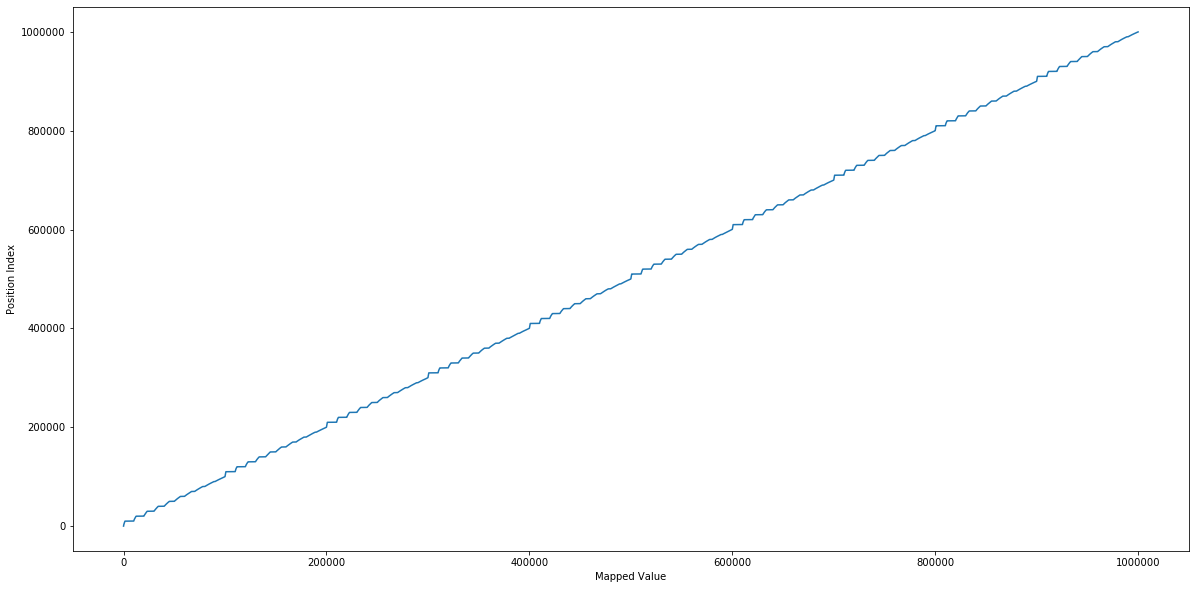

In [55]:
plt.figure(figsize=(20,10))
plt.plot(in_data_arr[:,3], in_data_arr[:,2])
plt.xlabel('Mapped Value')
plt.ylabel('Position Index')
plt.show()

In [56]:
# Sort the input data array with mapped values
in_data_arr = in_data_arr[in_data_arr[:,3].argsort()]

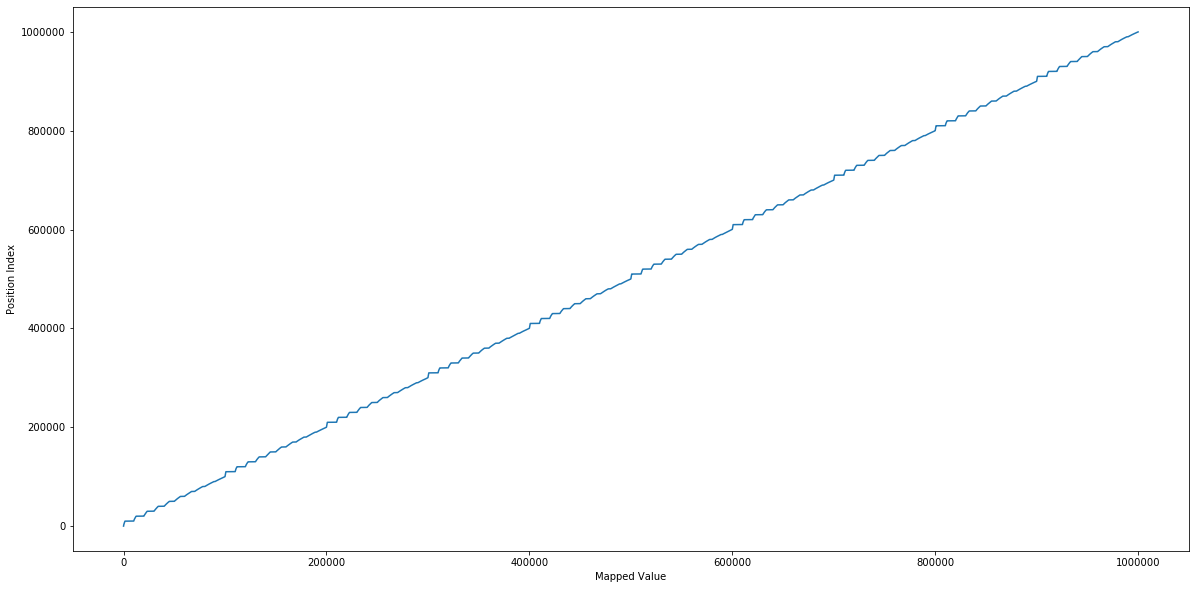

In [57]:
plt.figure(figsize=(20,10))
plt.plot(in_data_arr[:,3], in_data_arr[:,2])
plt.xlabel('Mapped Value')
plt.ylabel('Position Index')
plt.show()

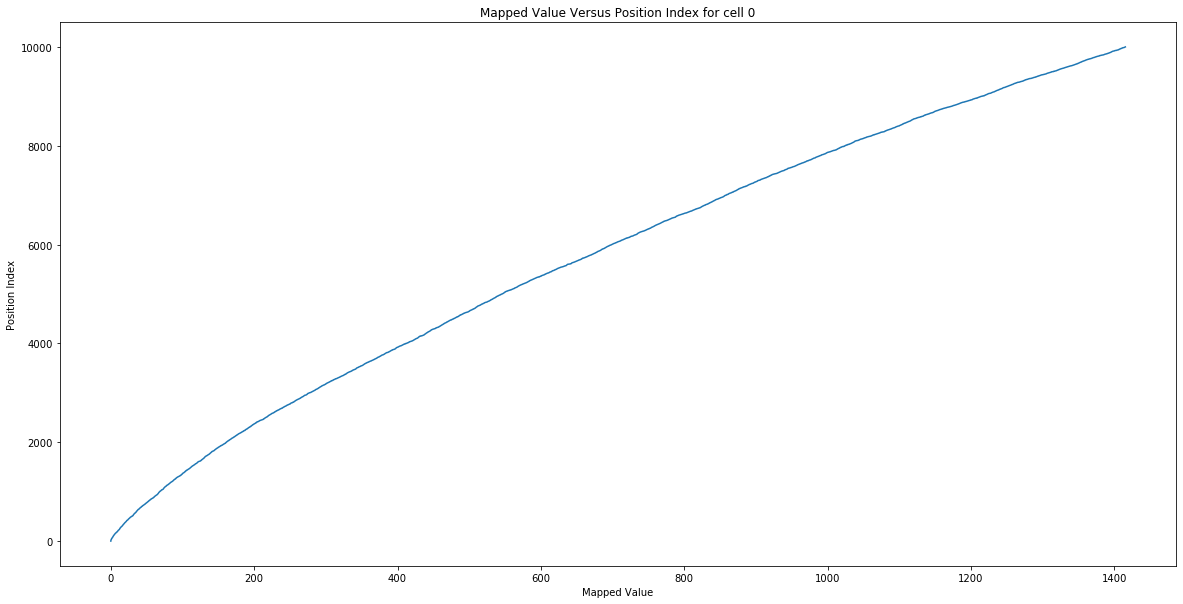

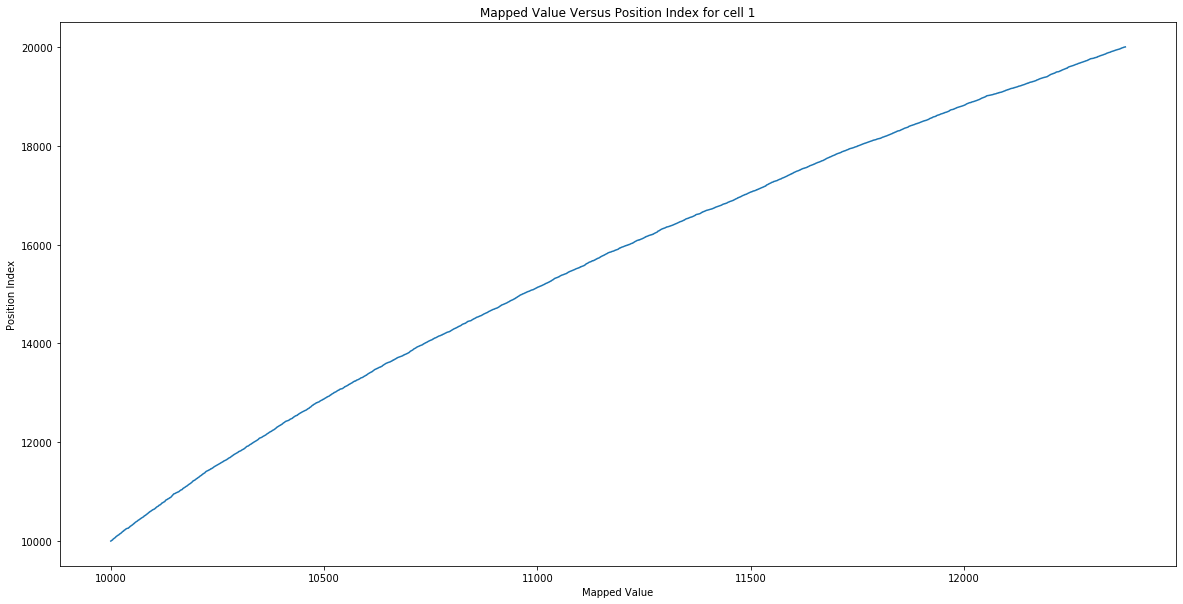

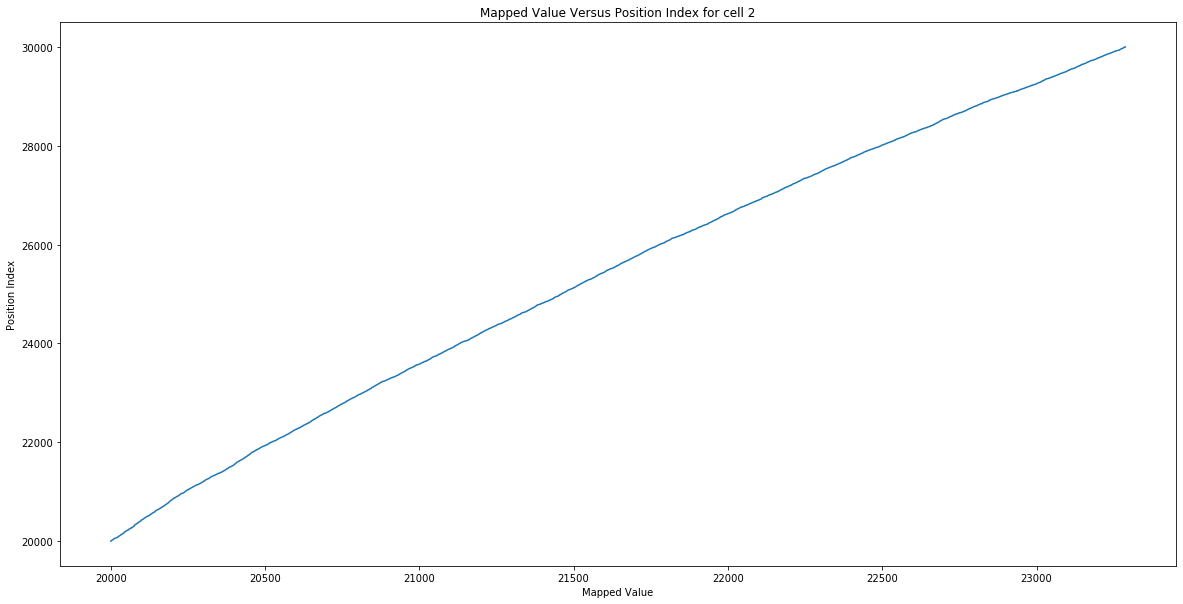

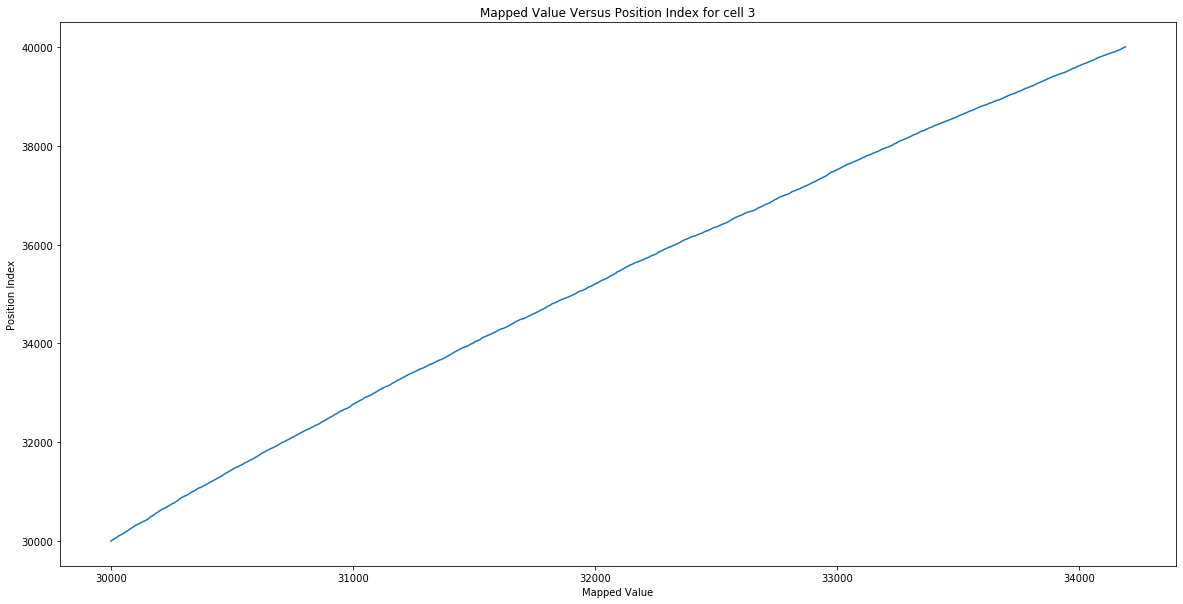

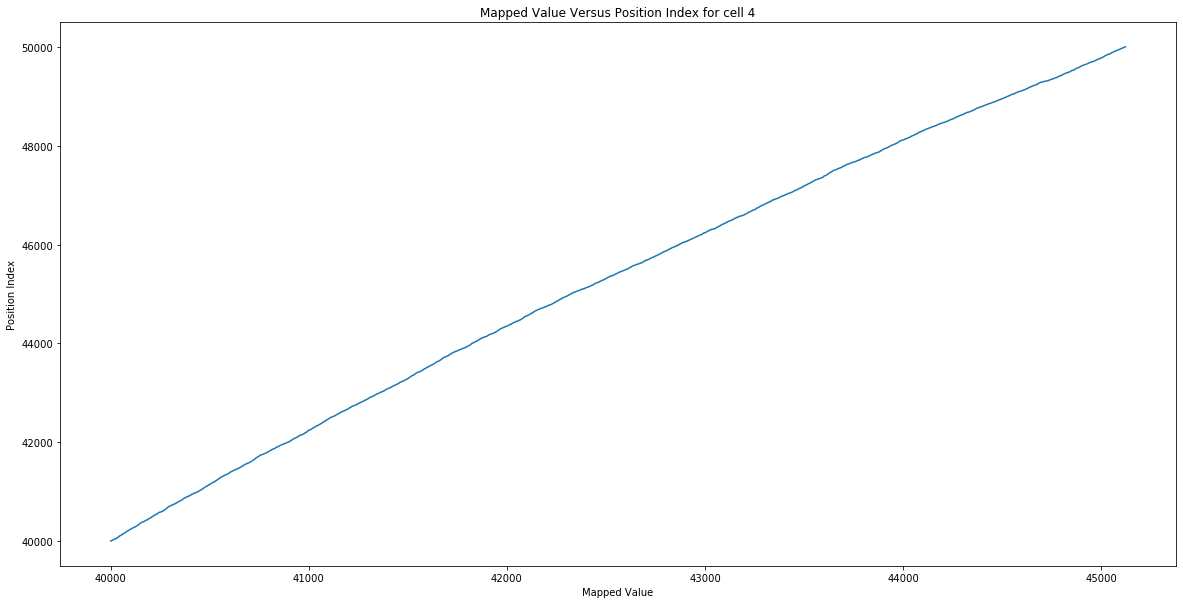

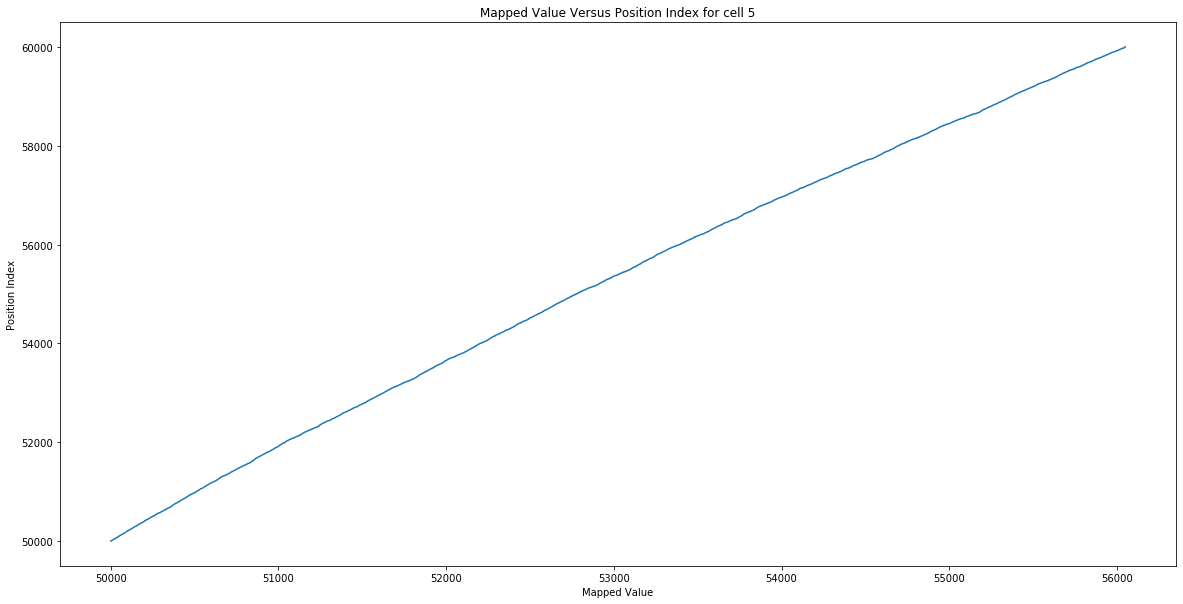

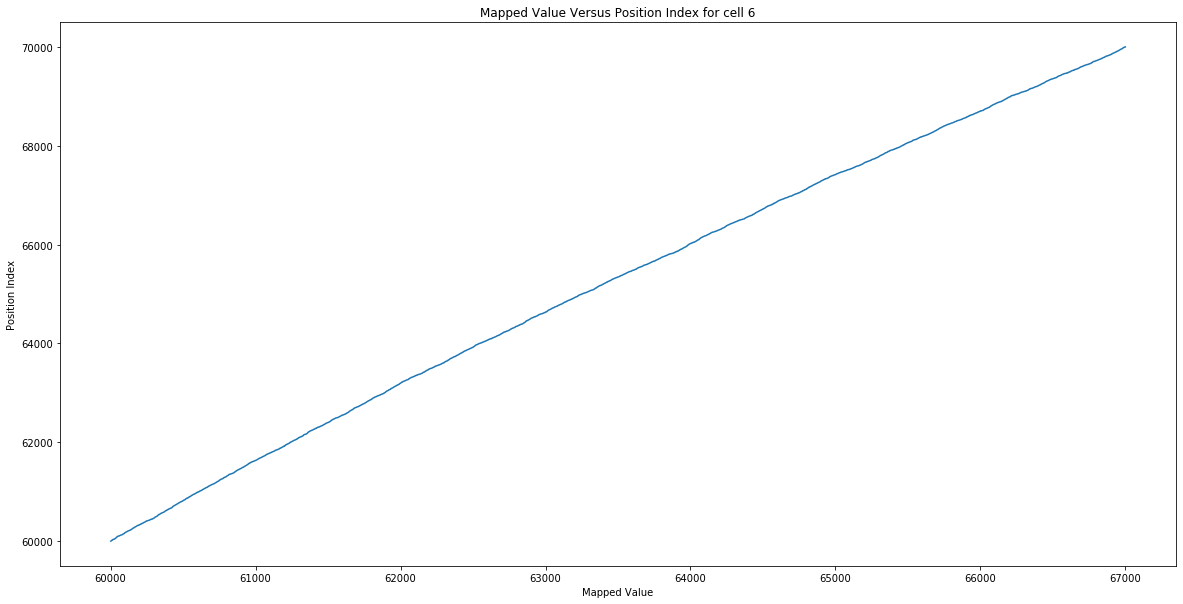

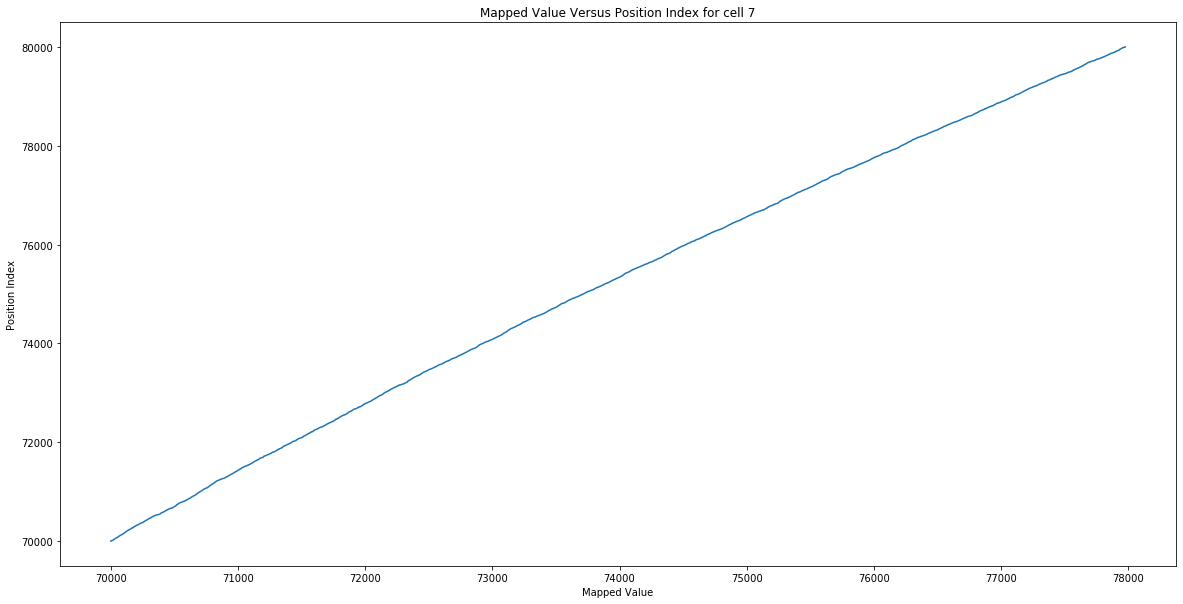

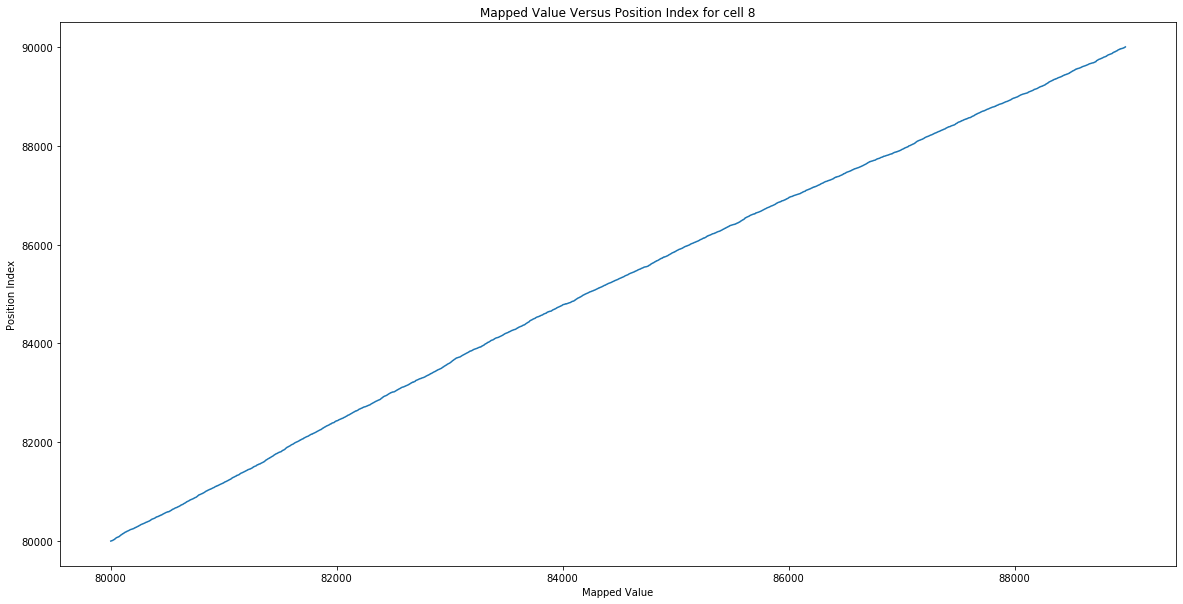

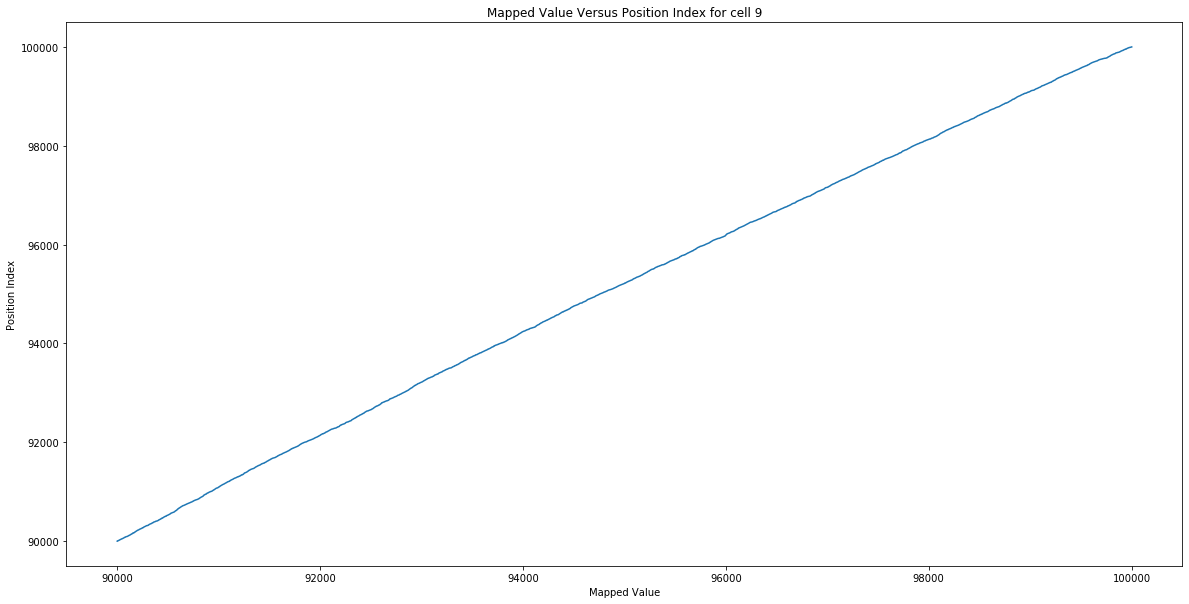

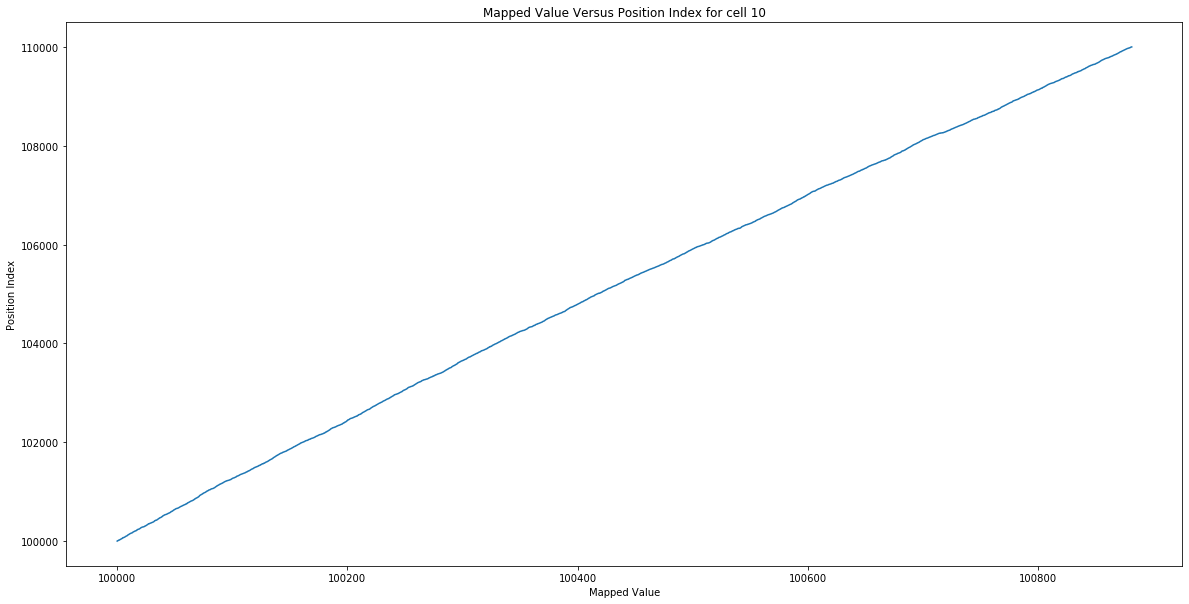

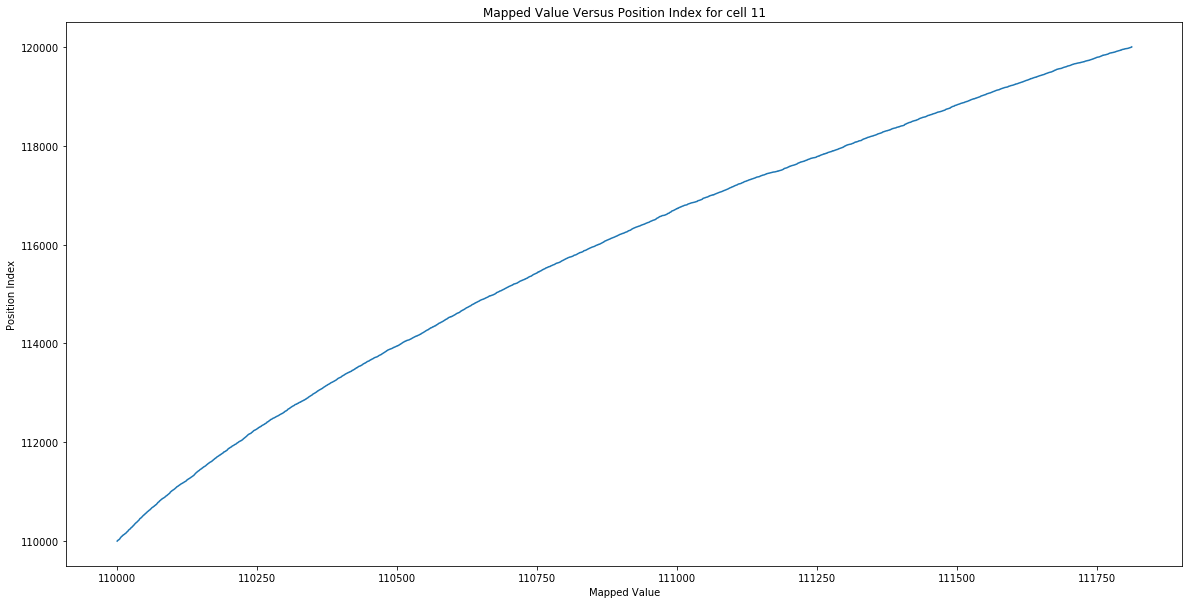

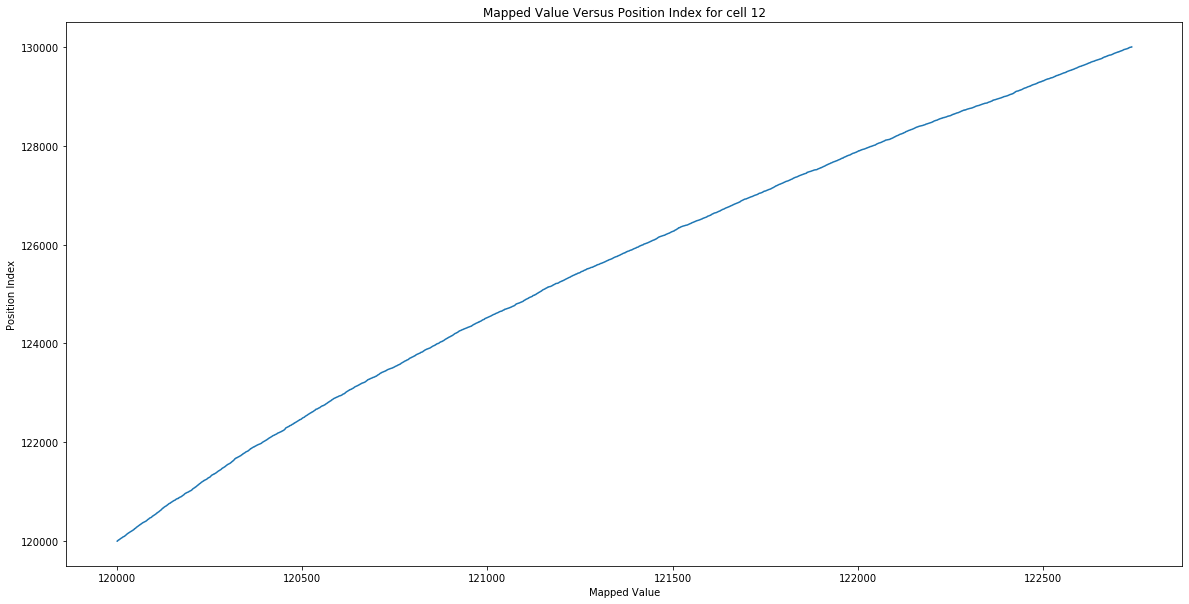

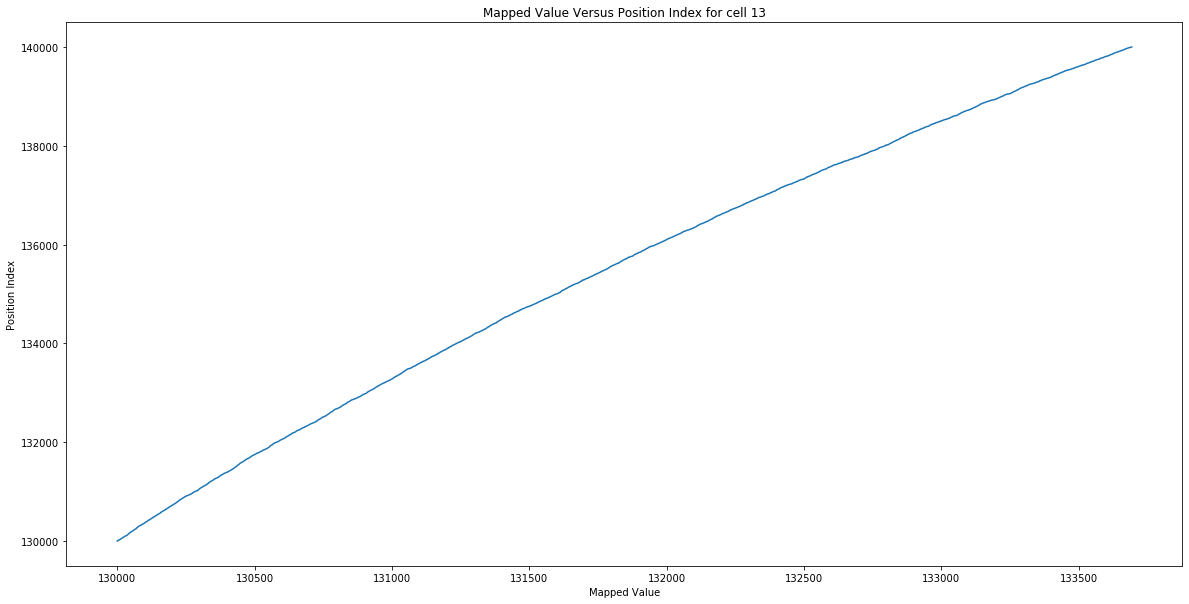

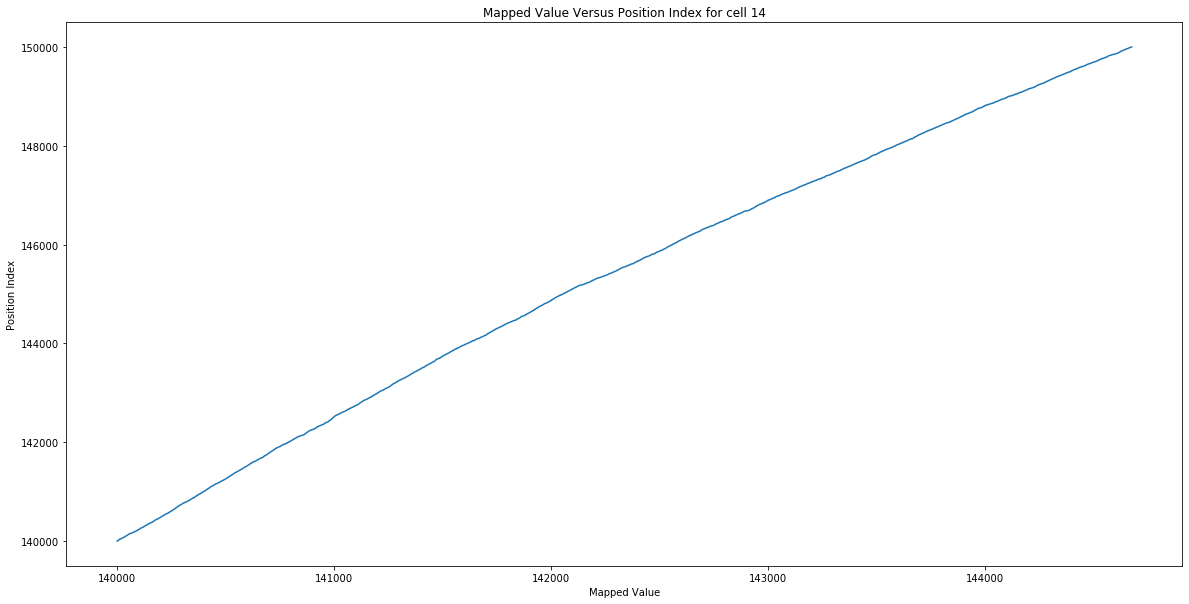

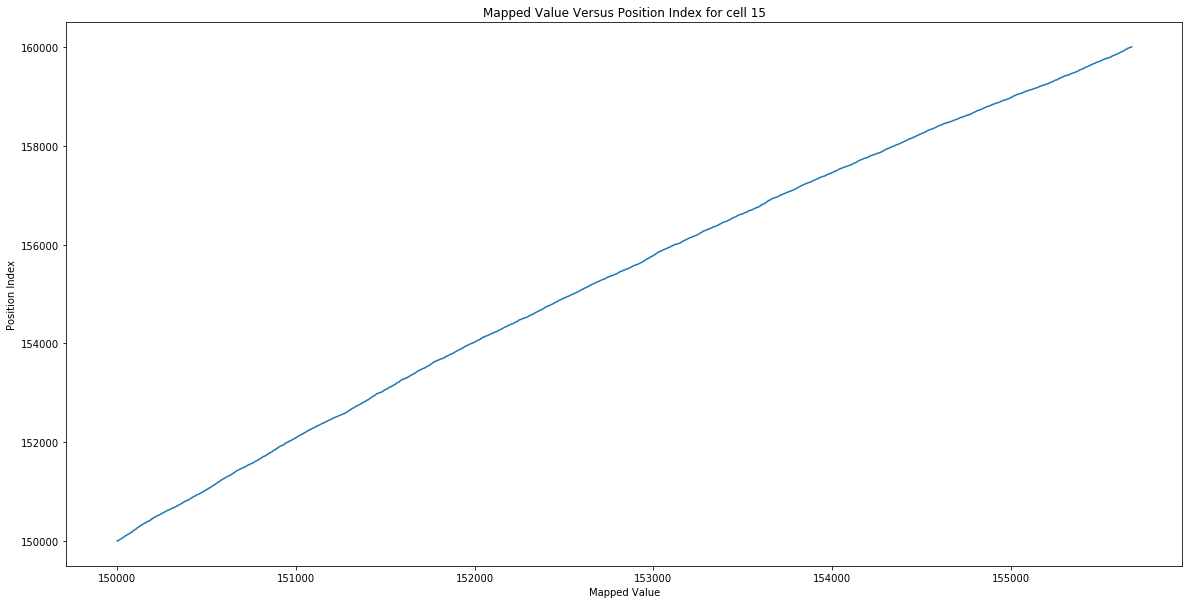

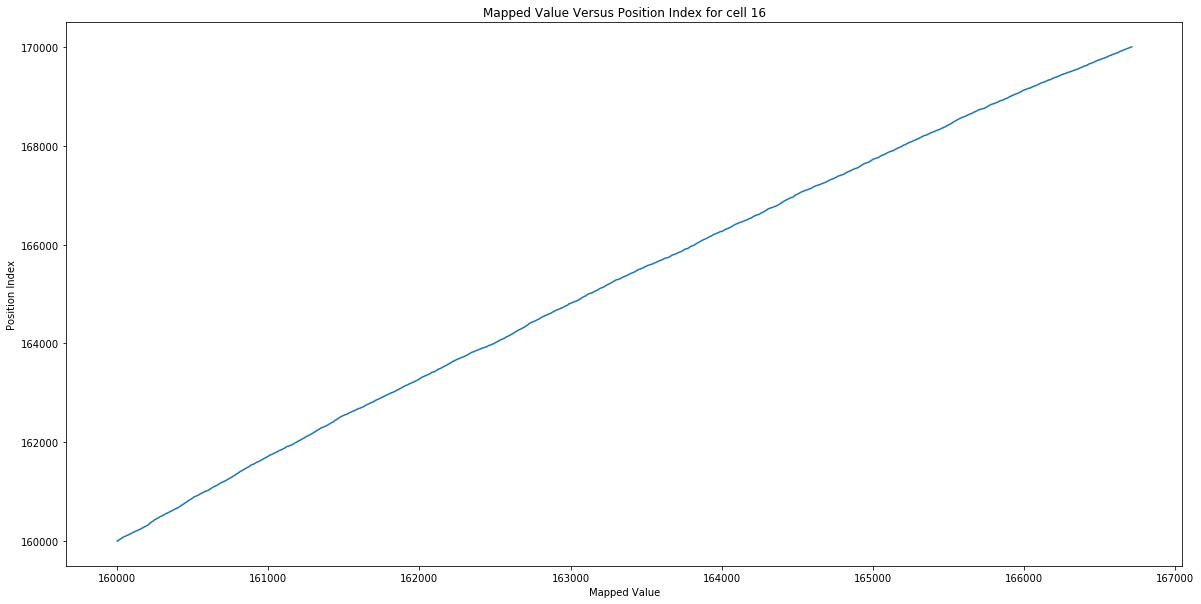

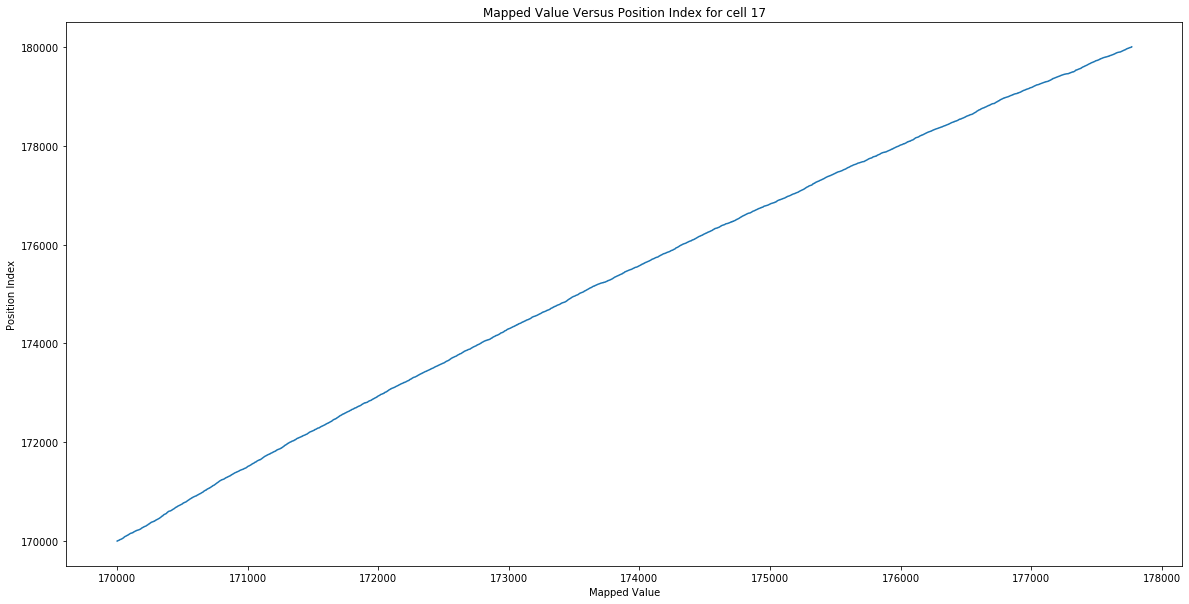

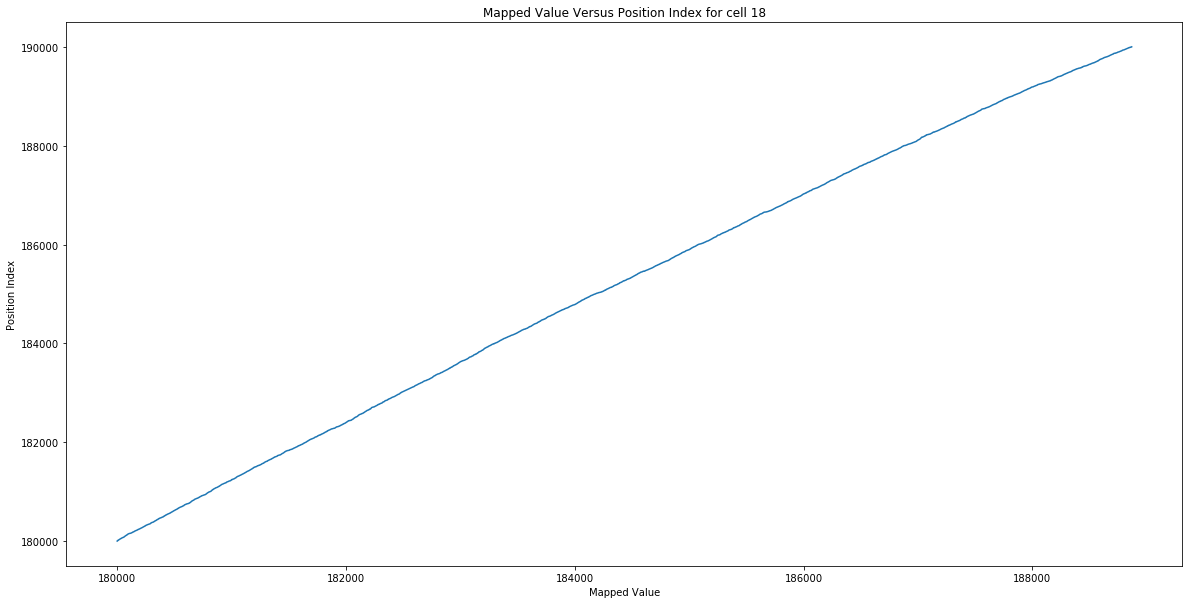

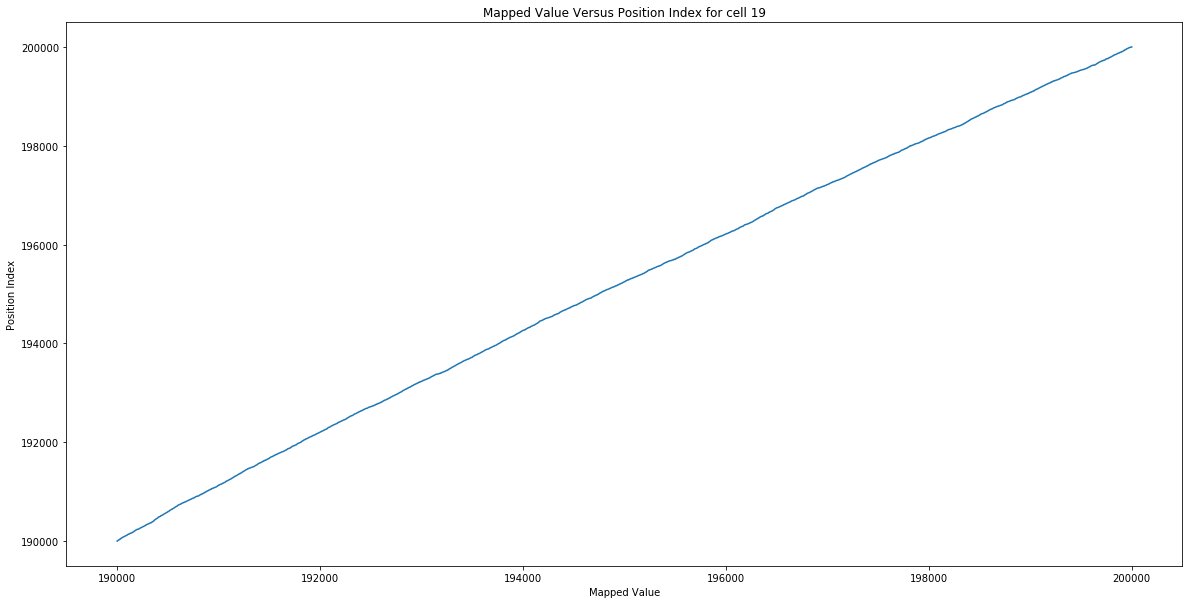

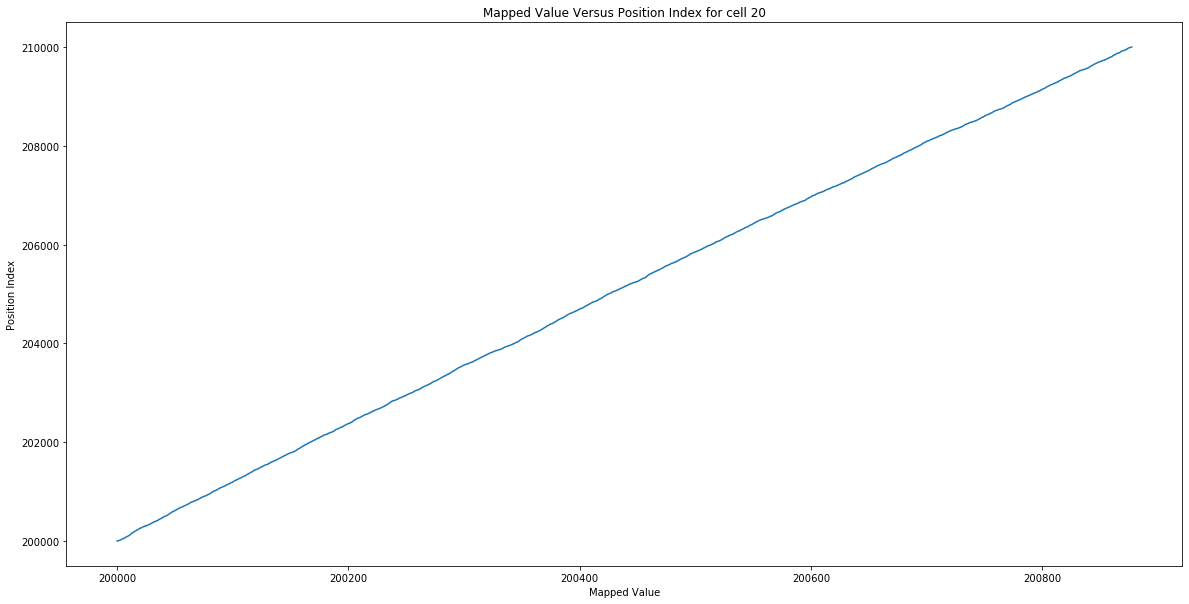

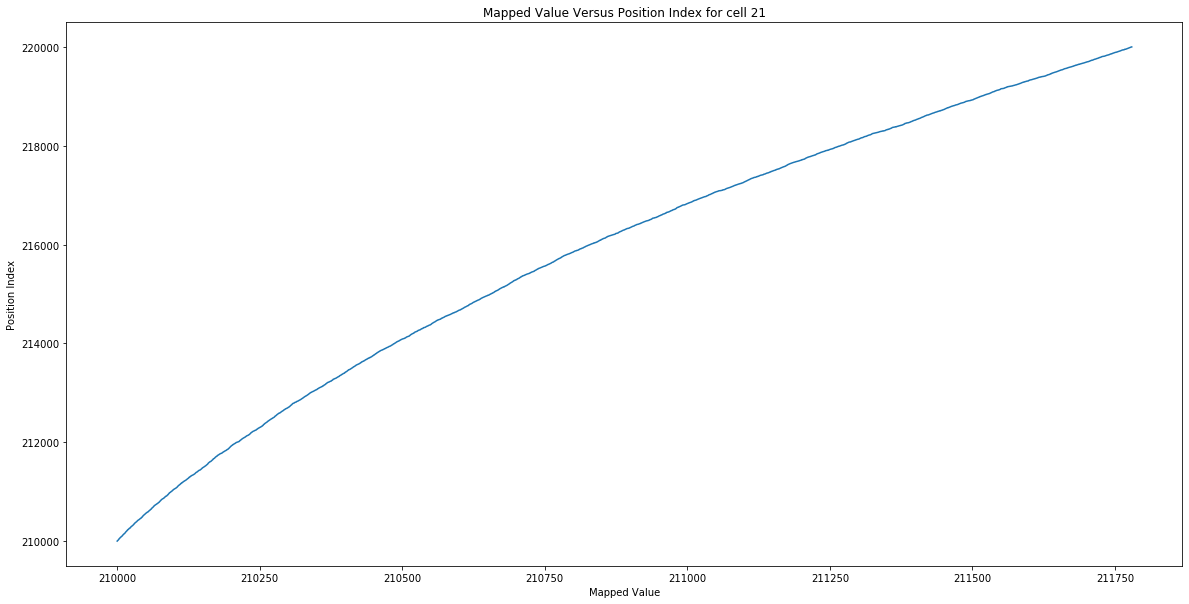

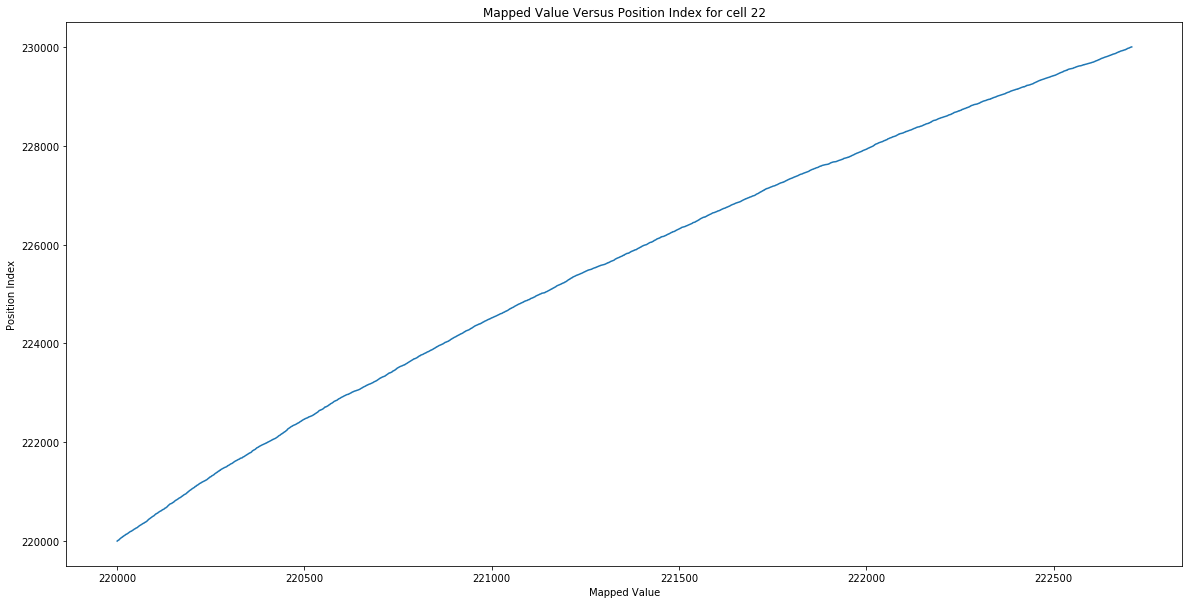

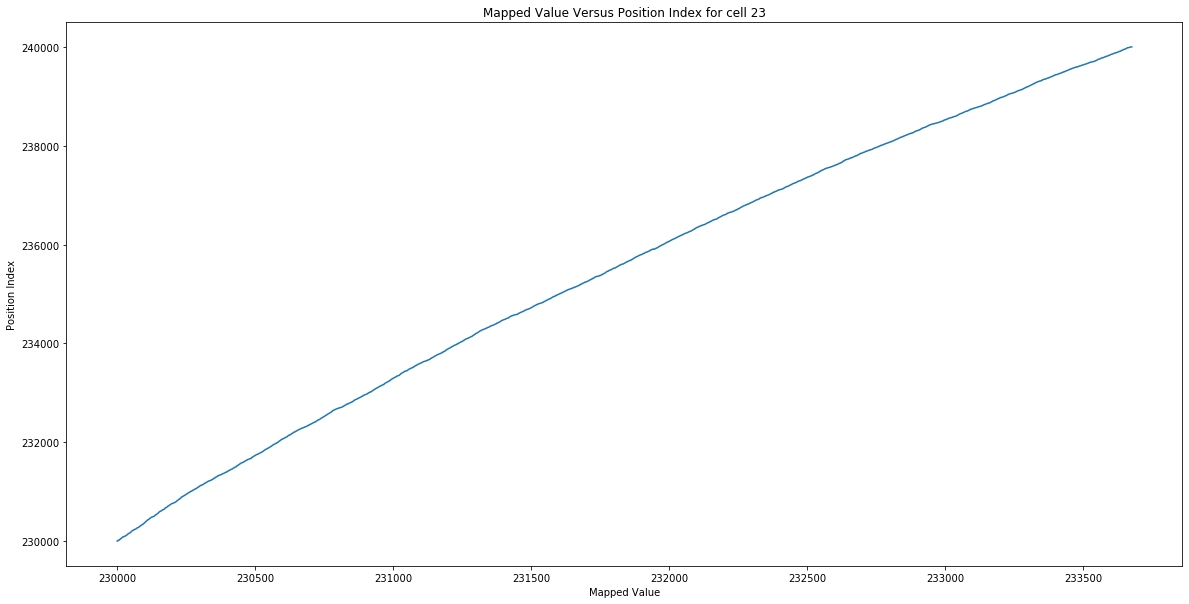

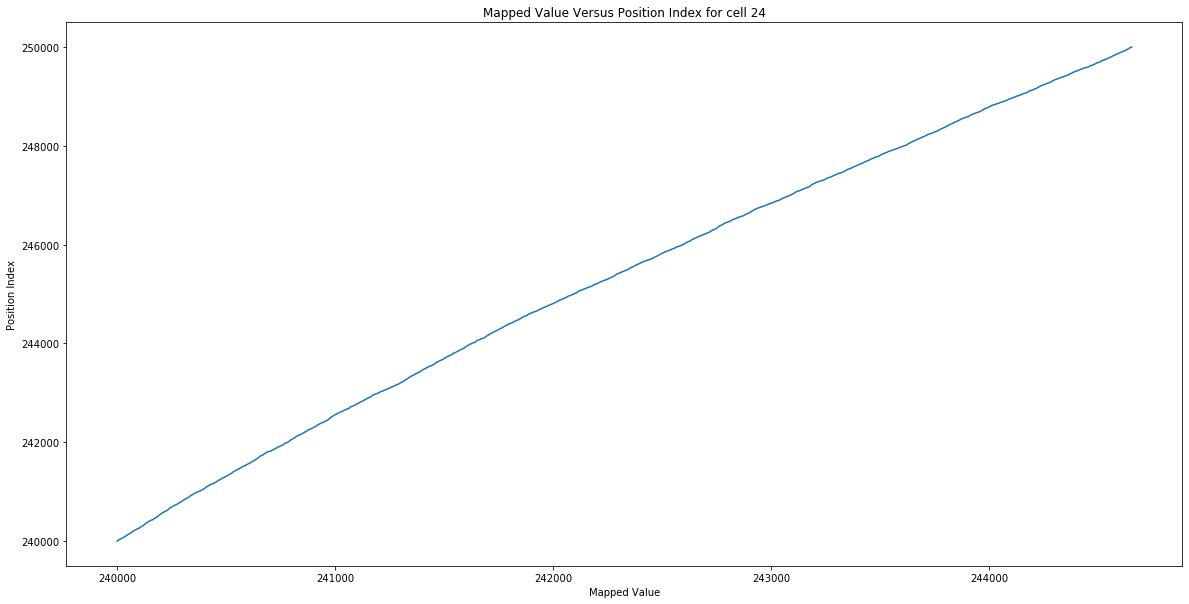

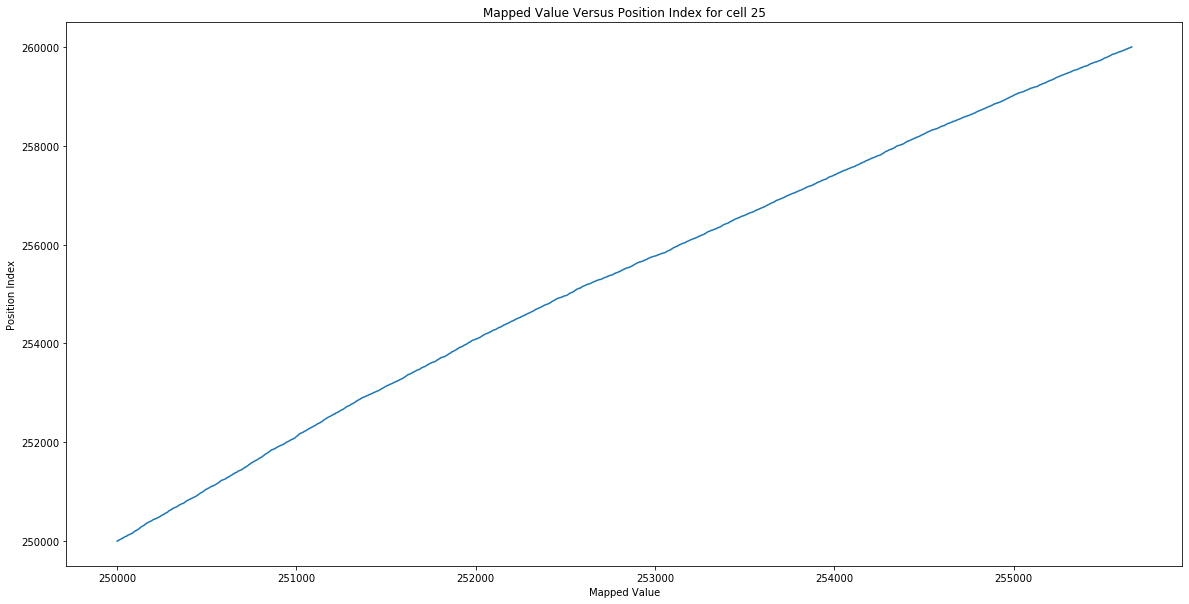

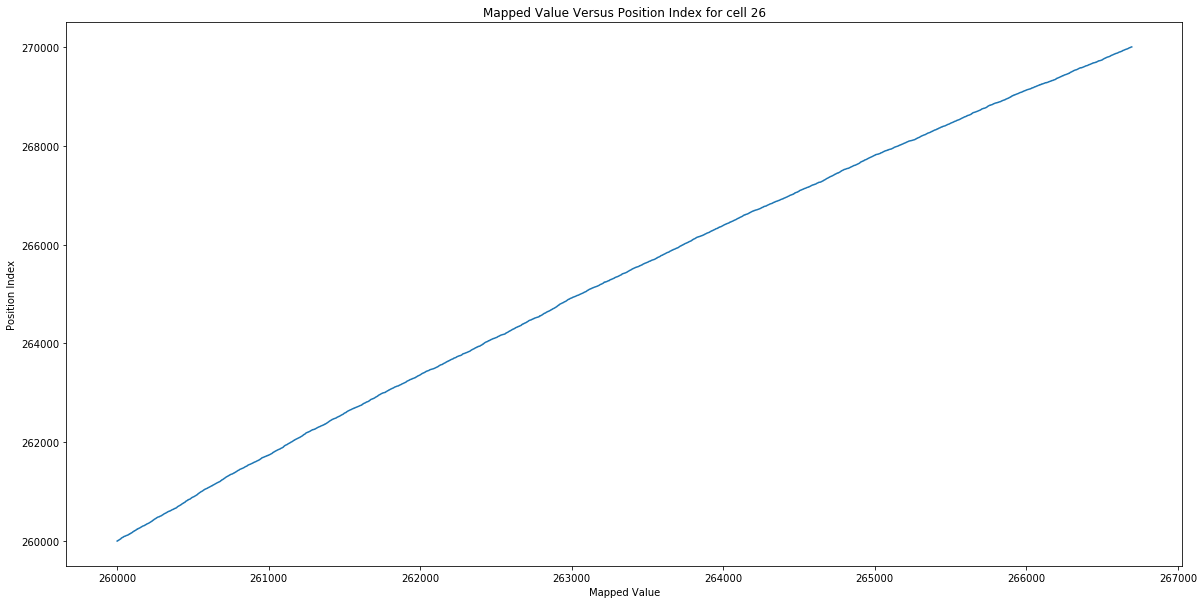

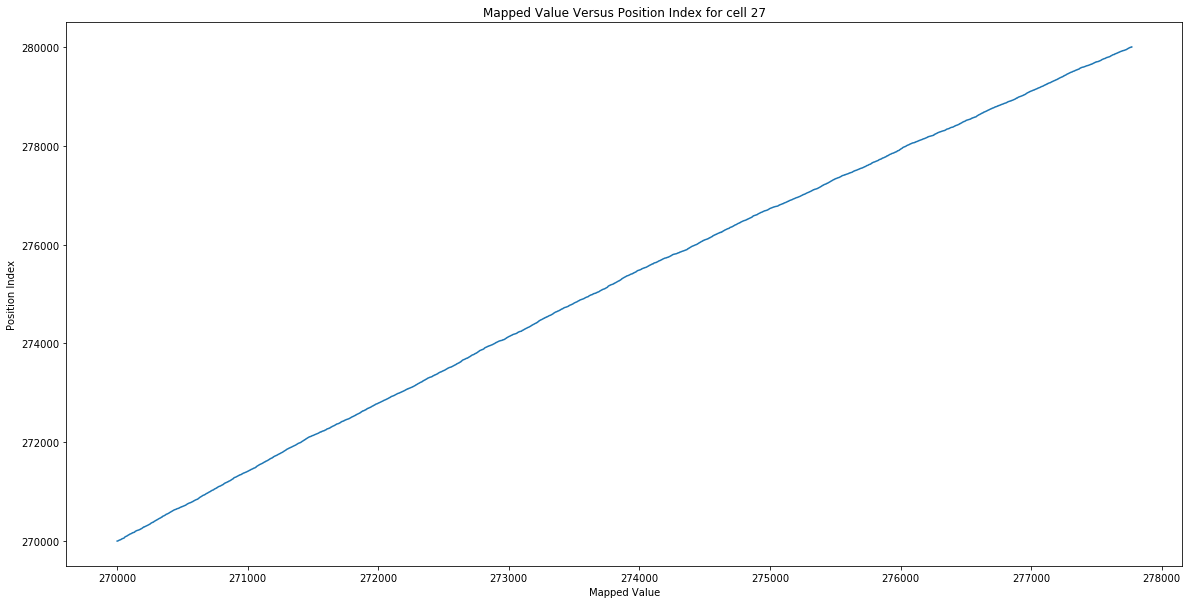

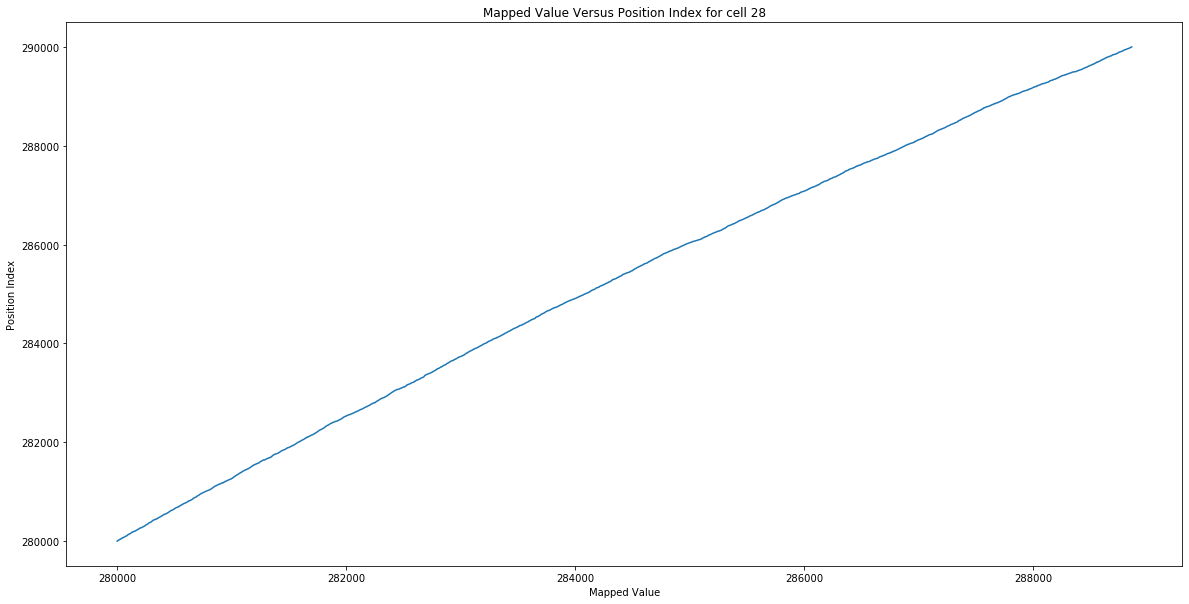

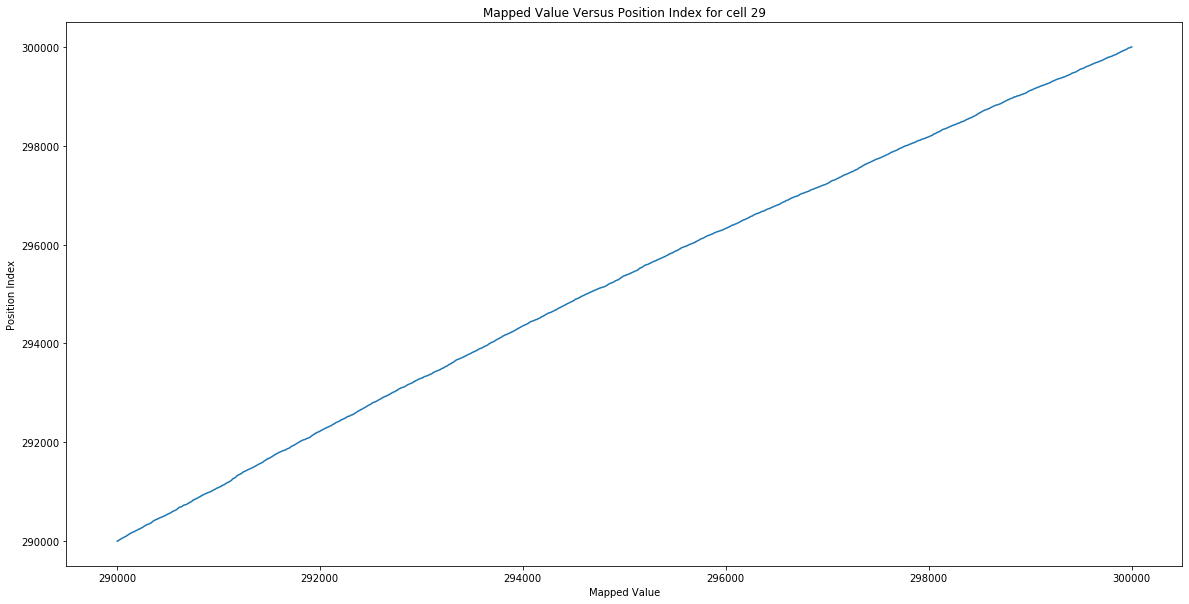

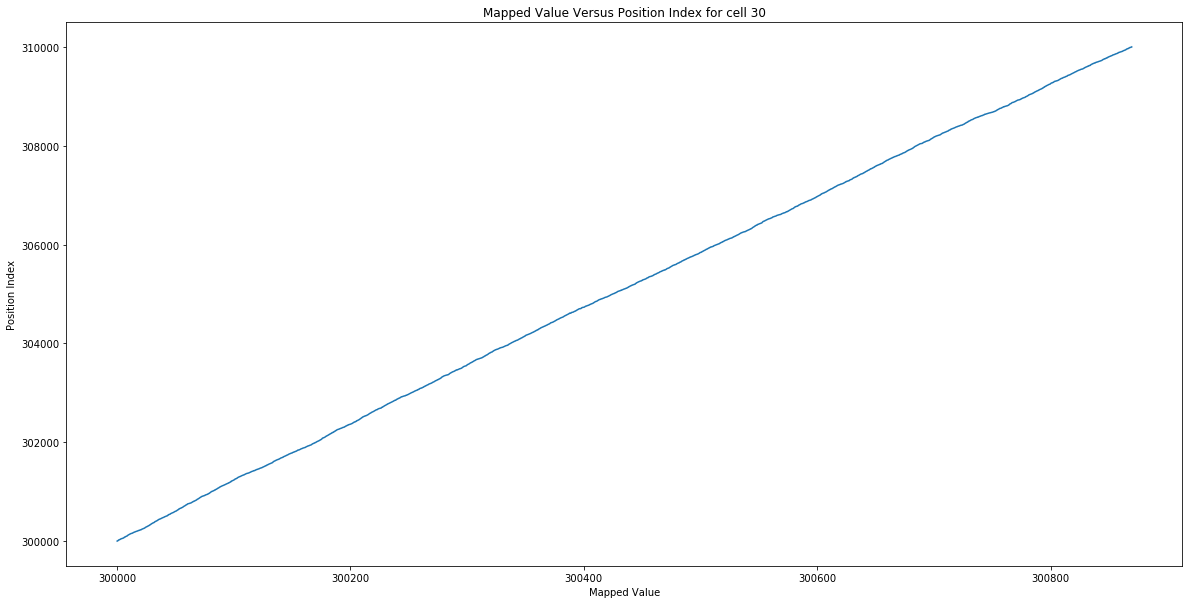

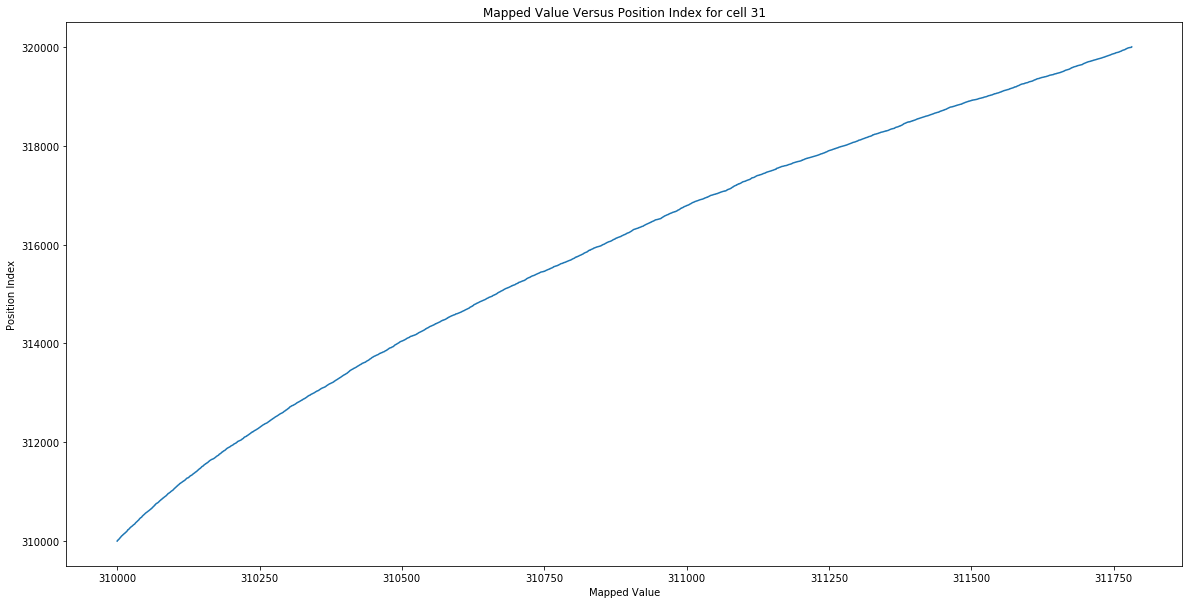

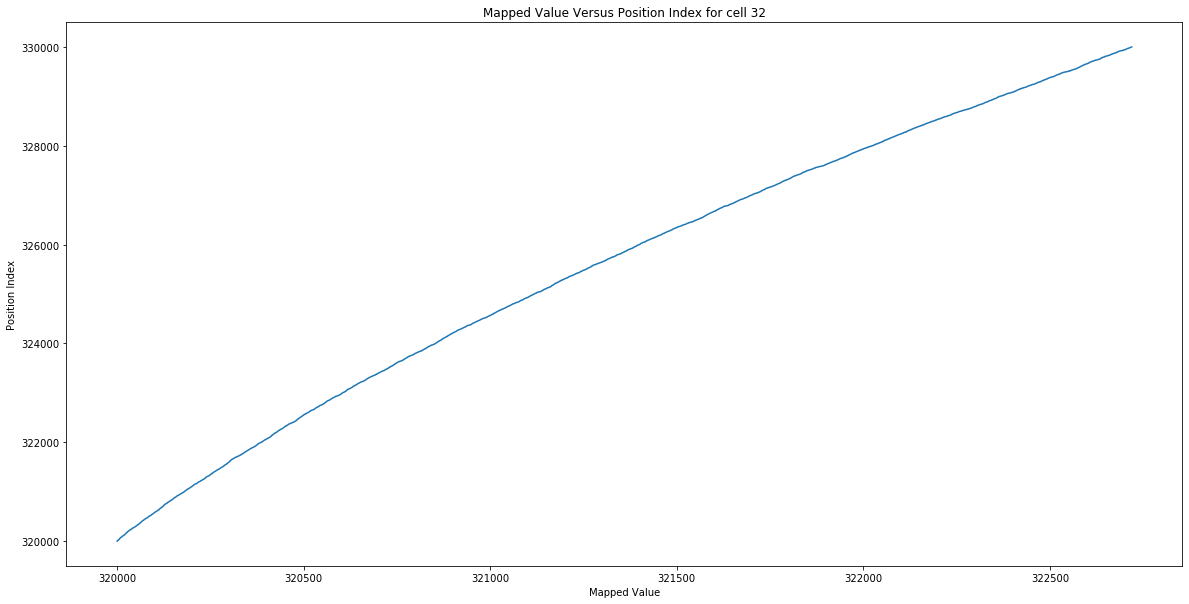

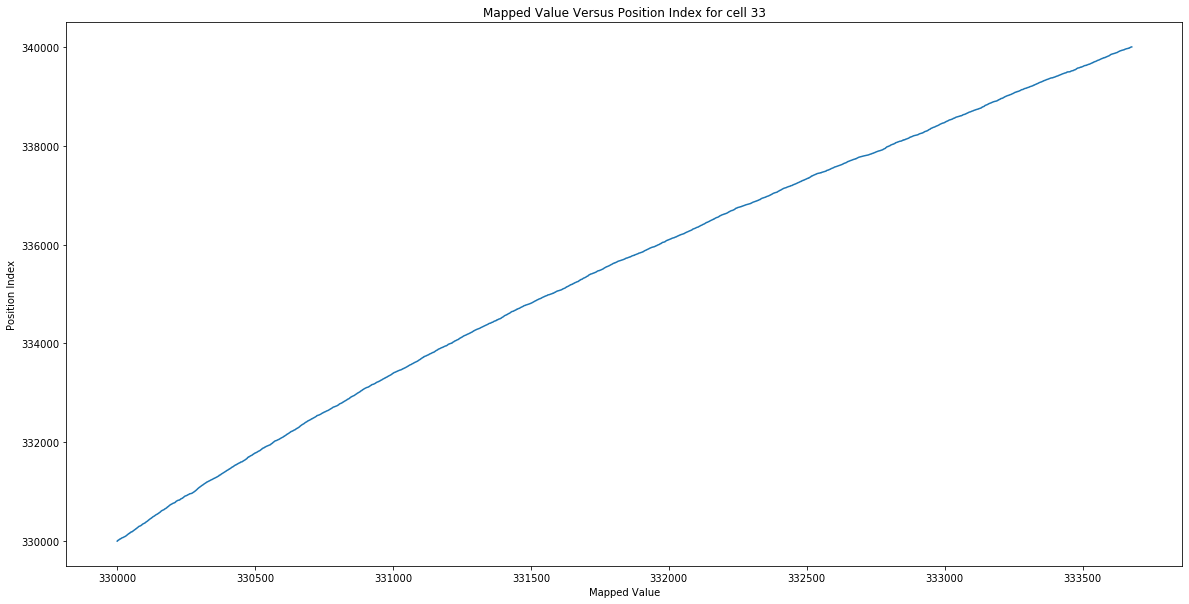

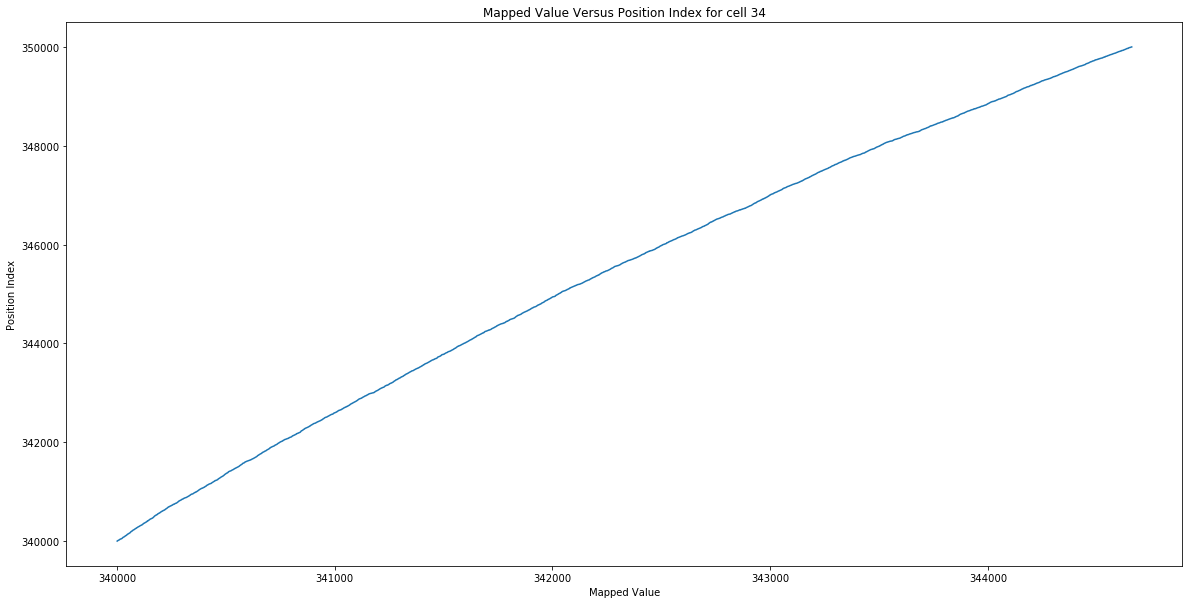

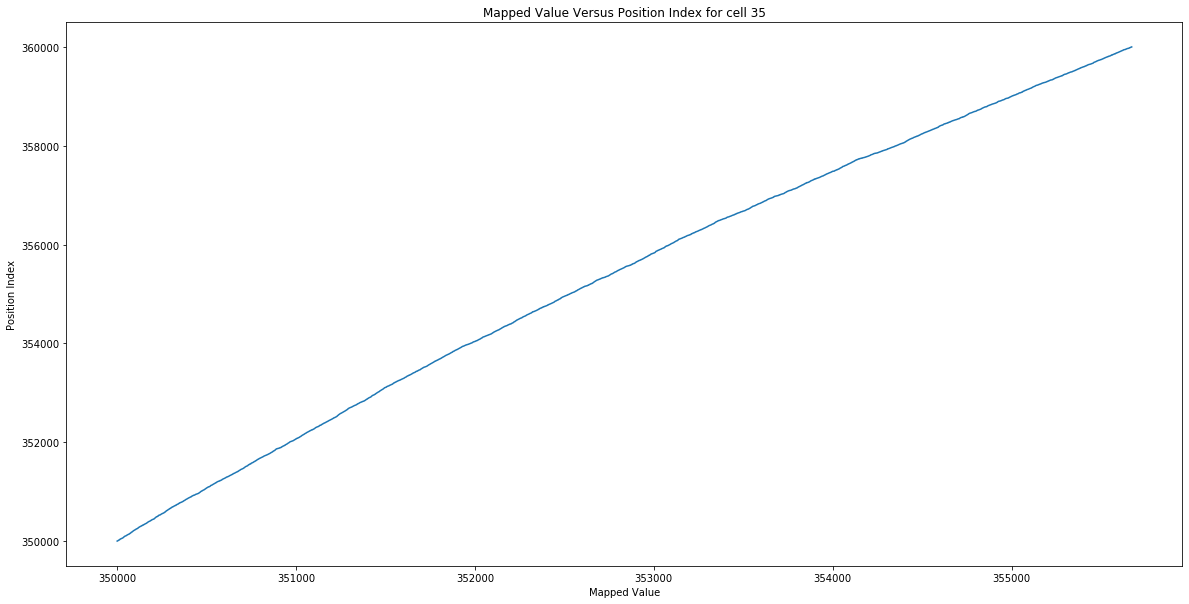

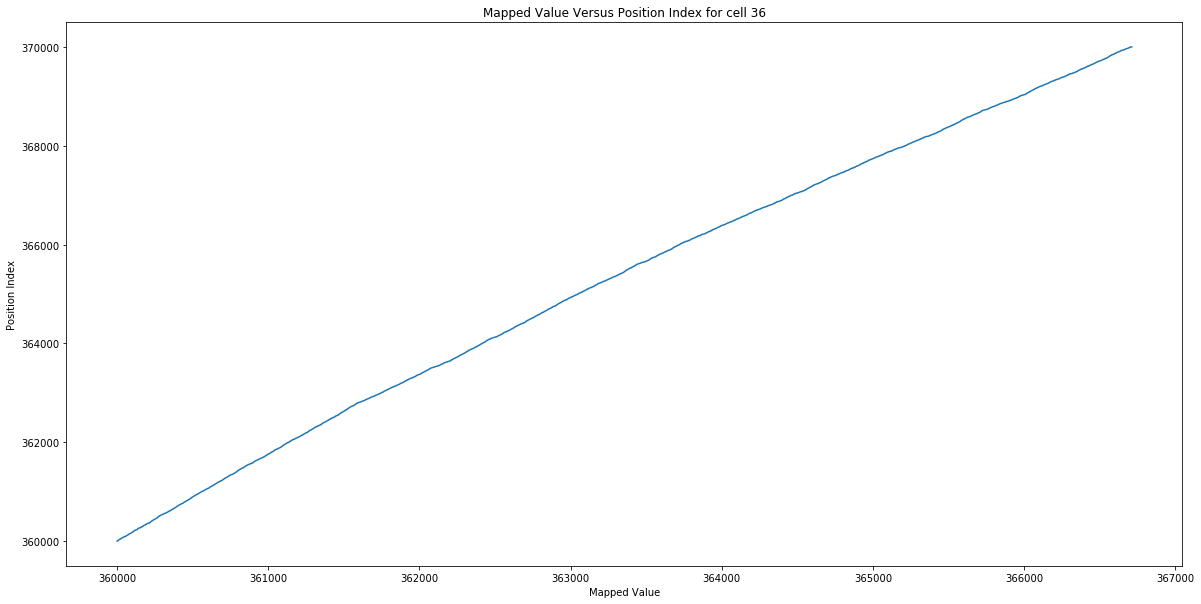

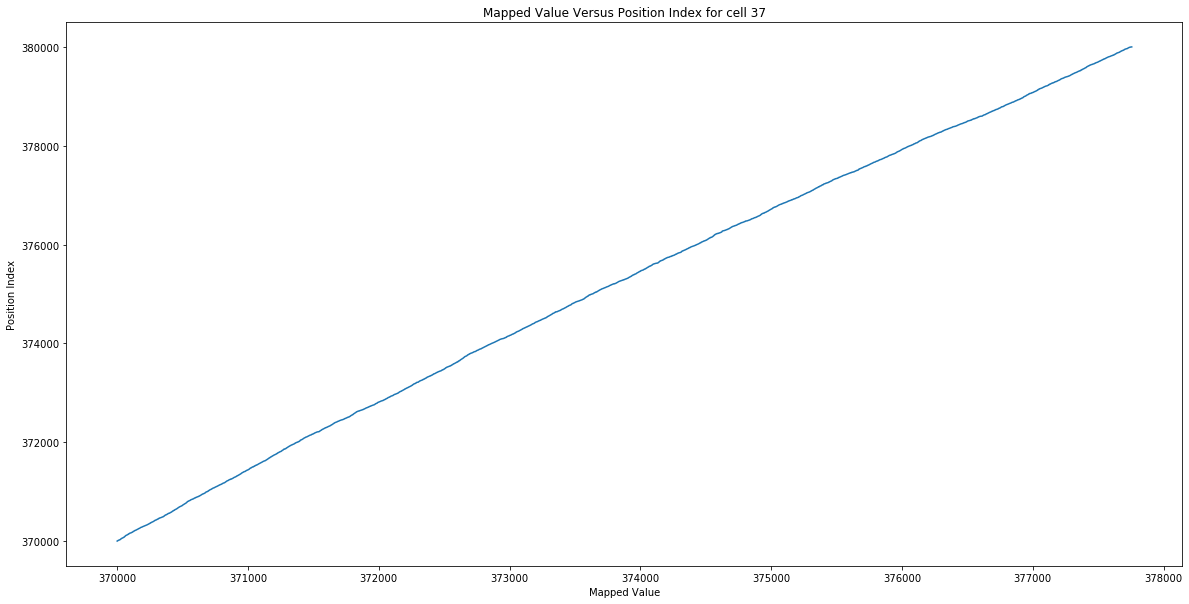

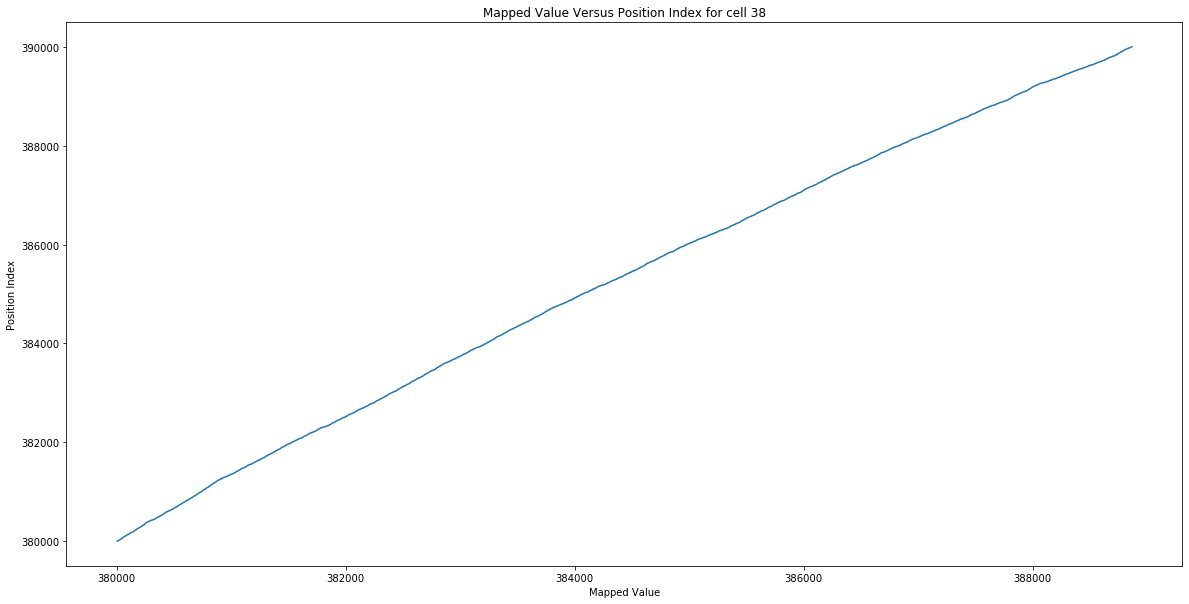

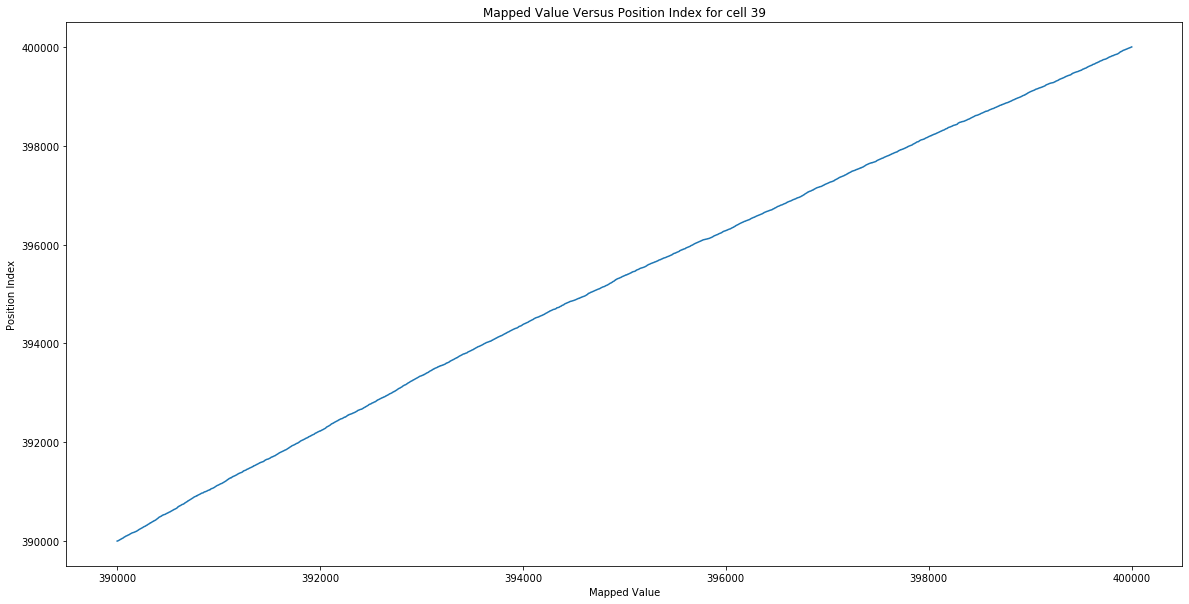

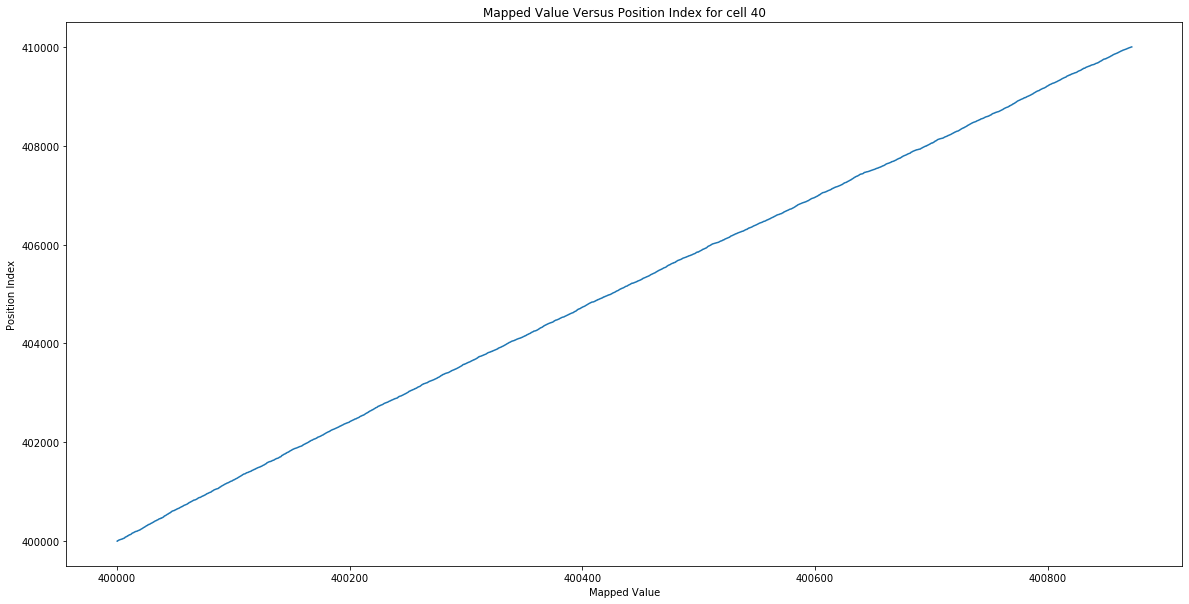

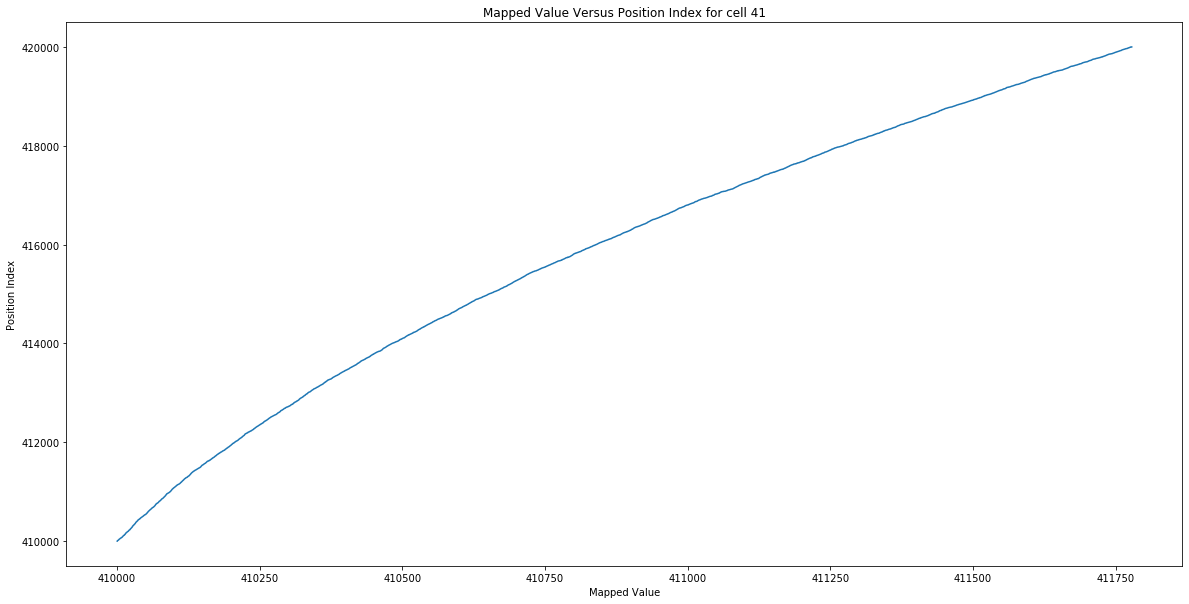

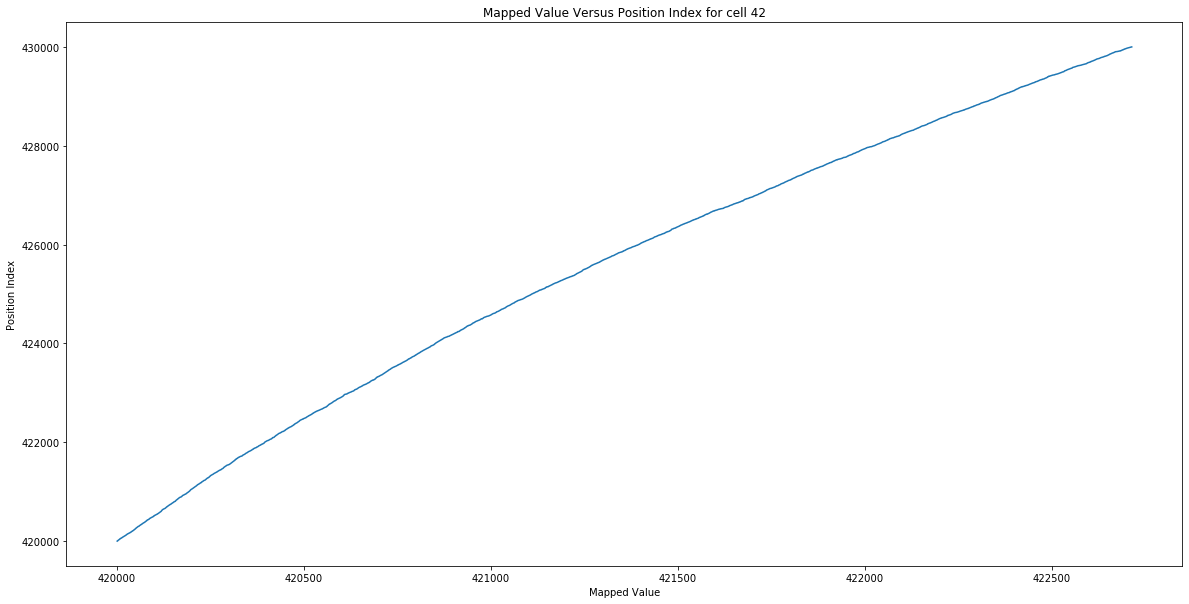

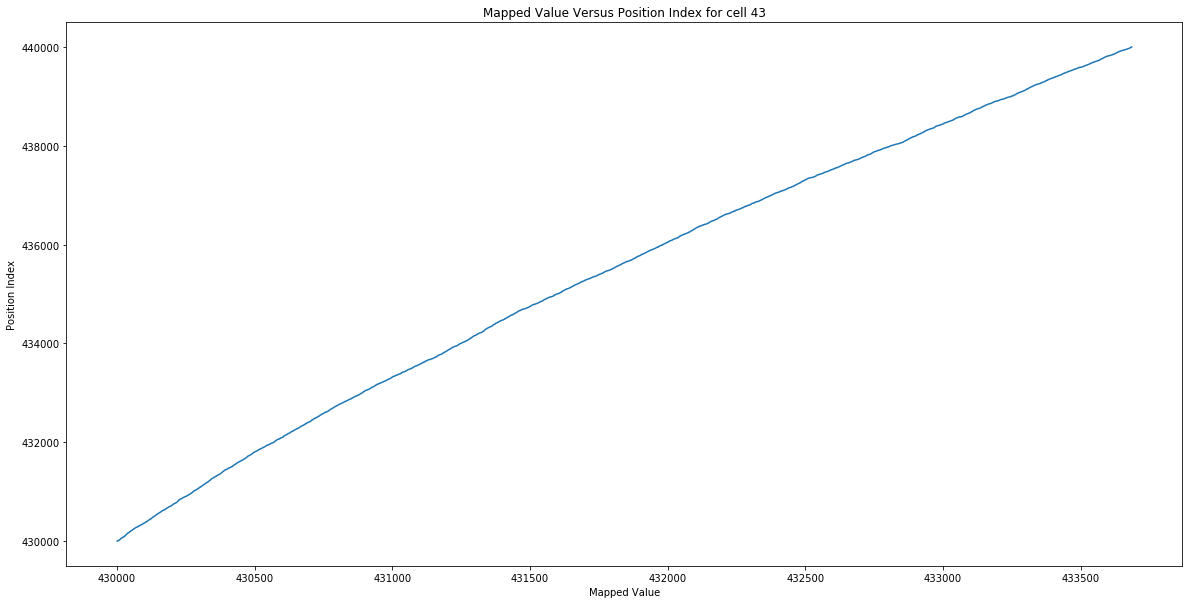

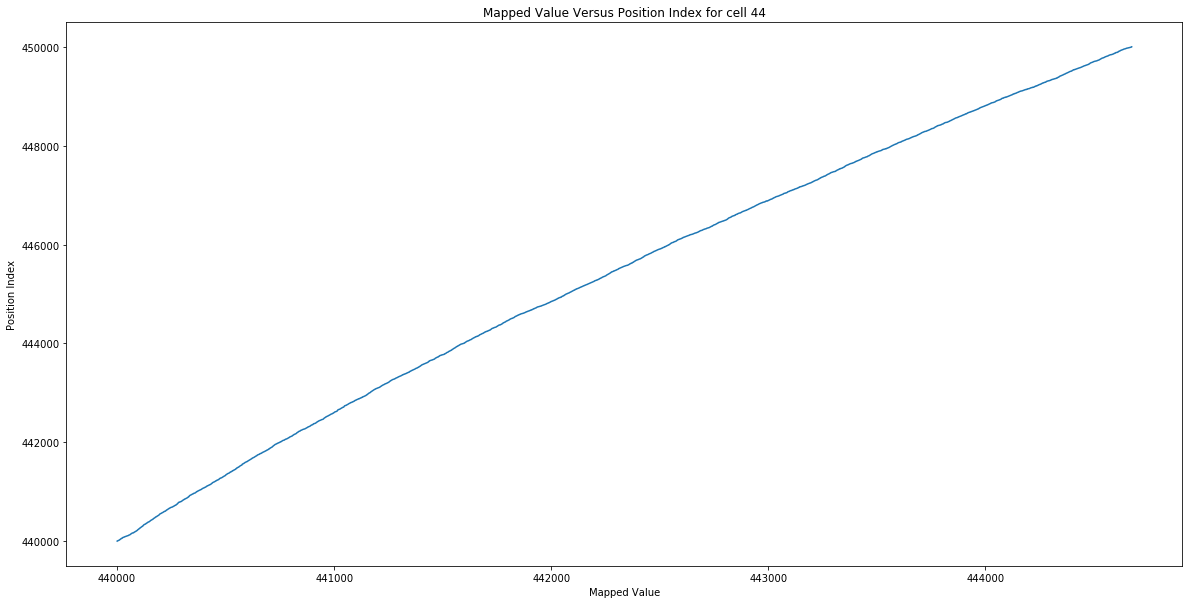

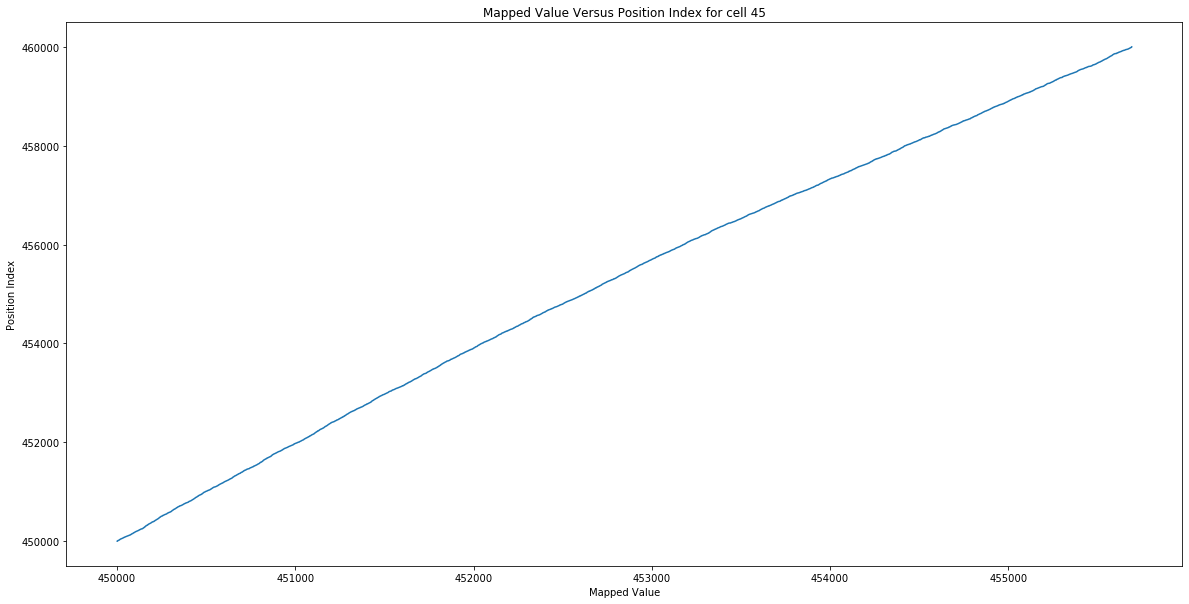

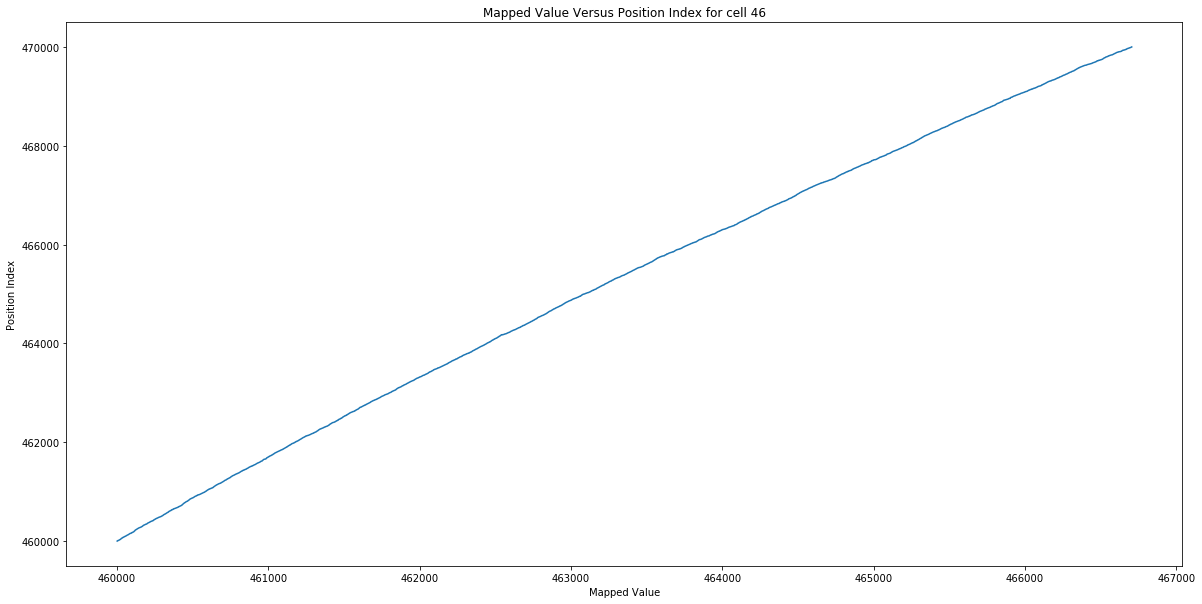

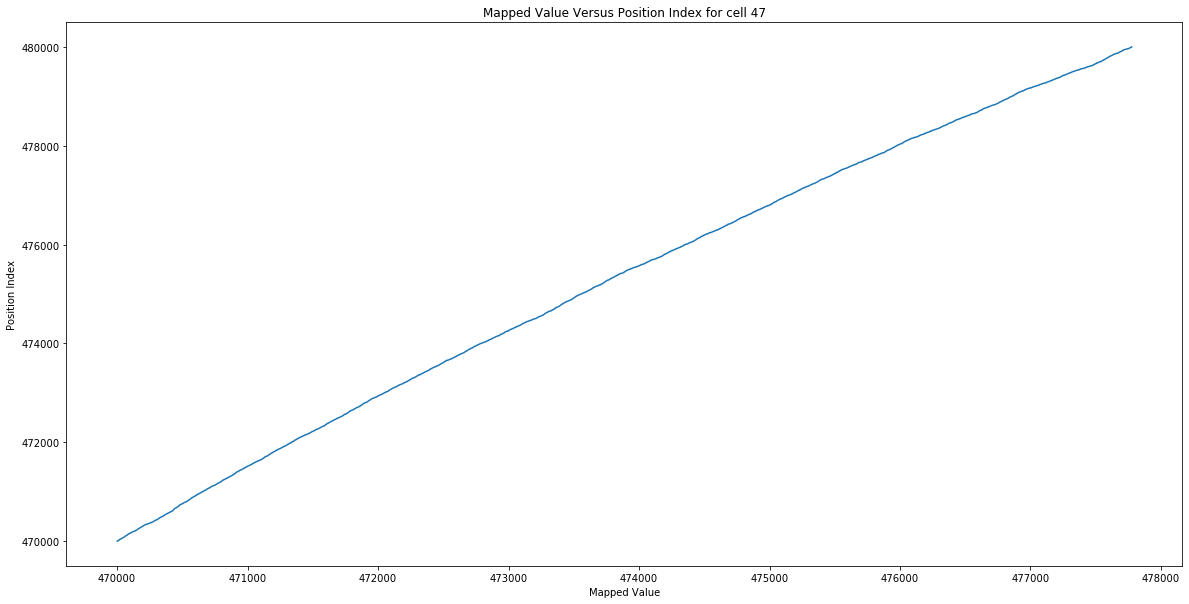

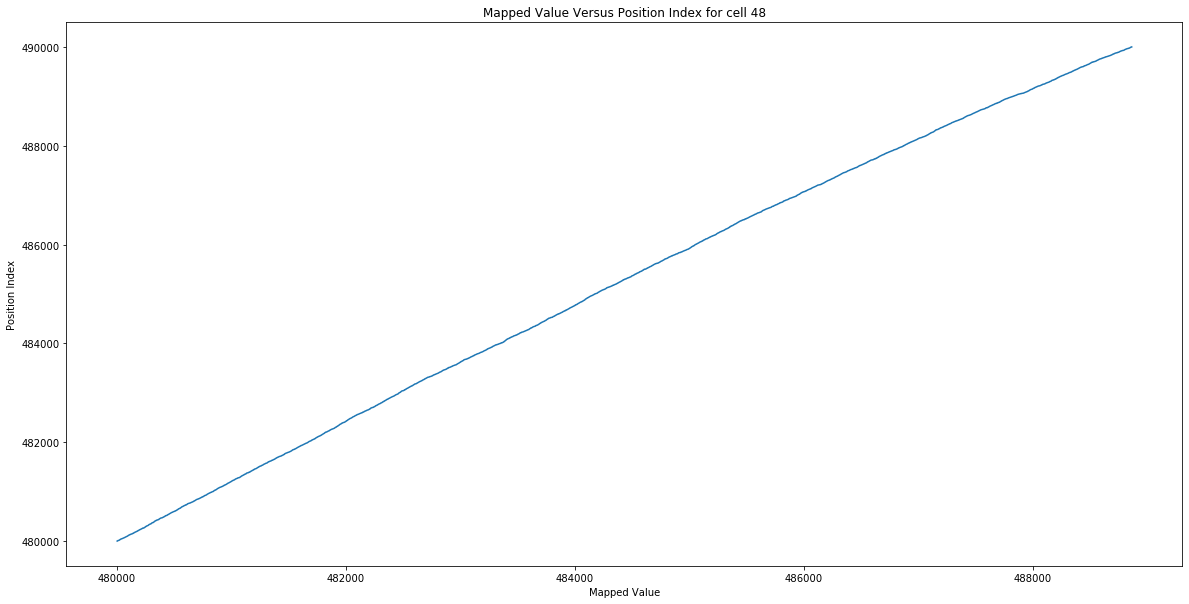

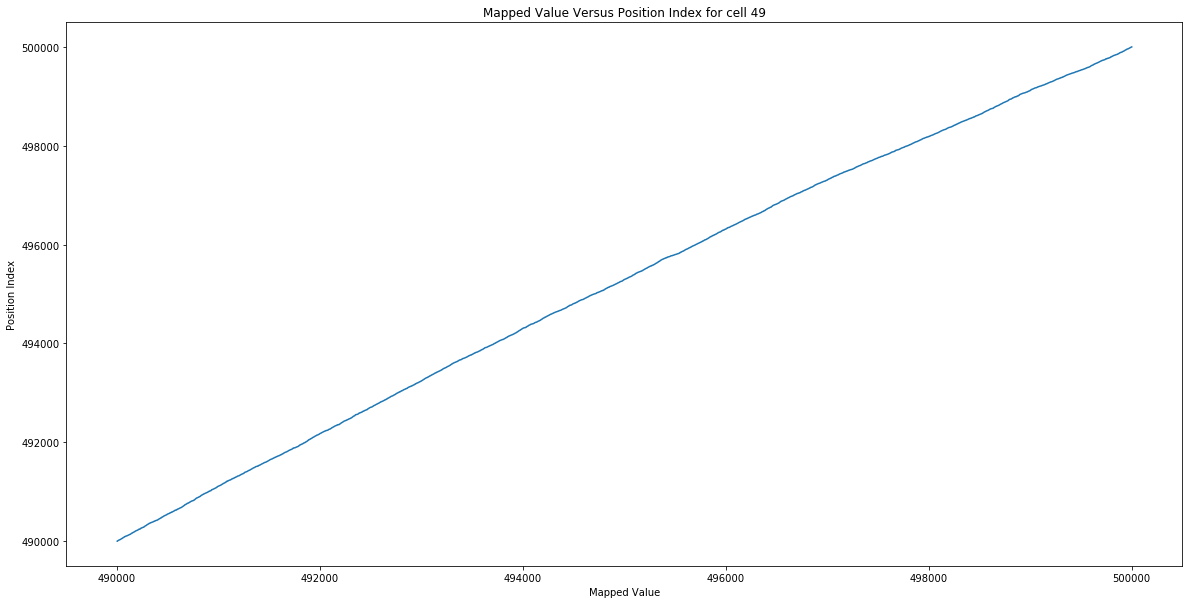

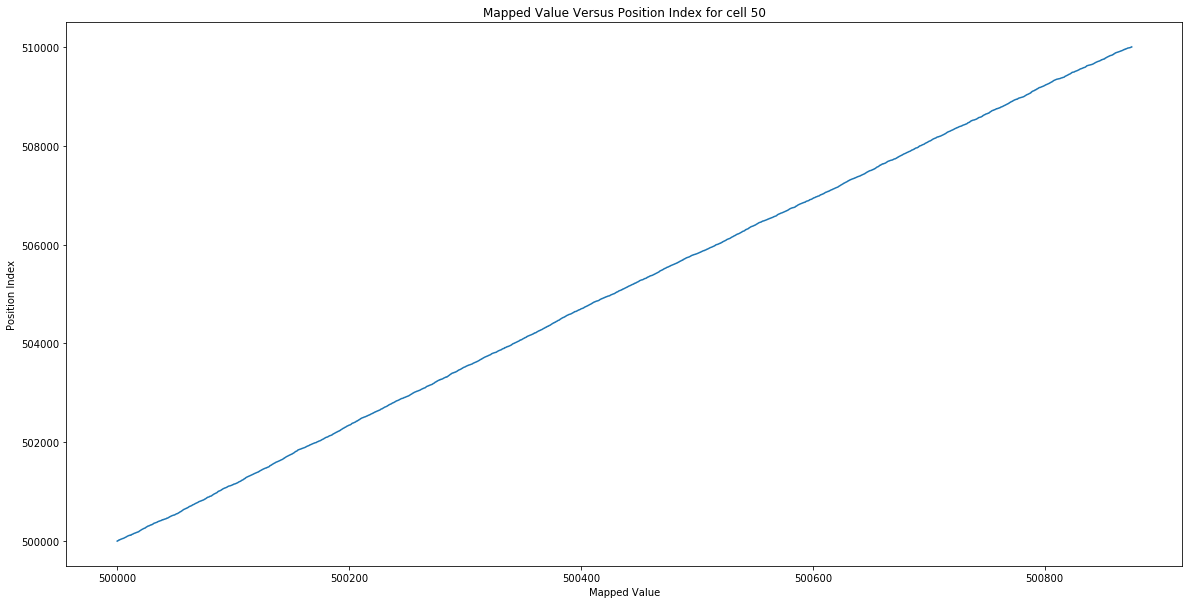

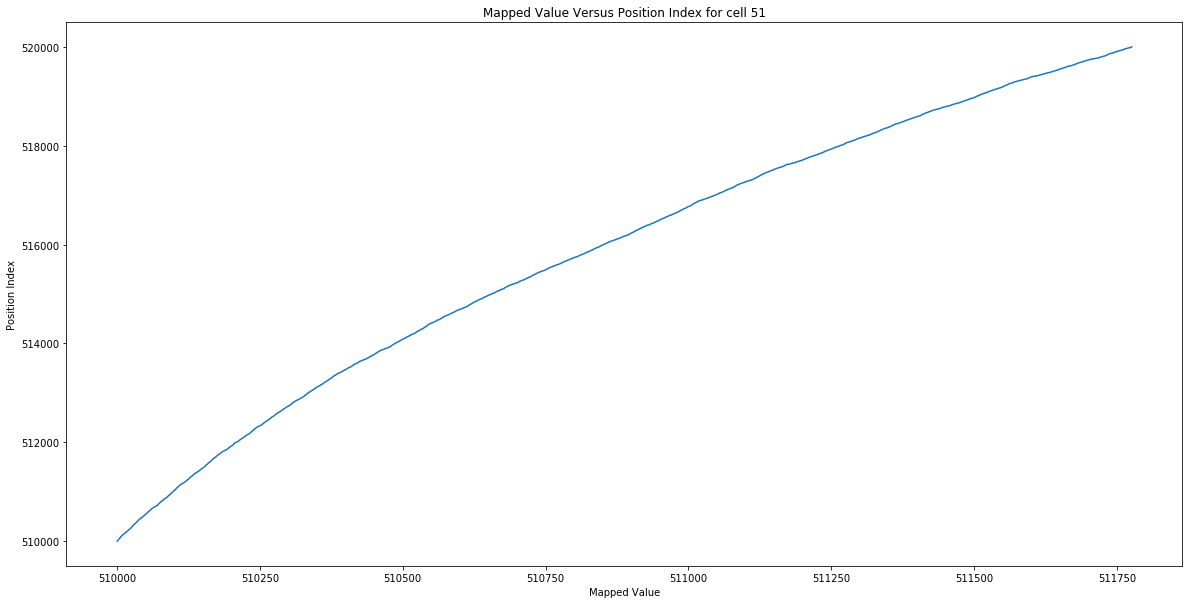

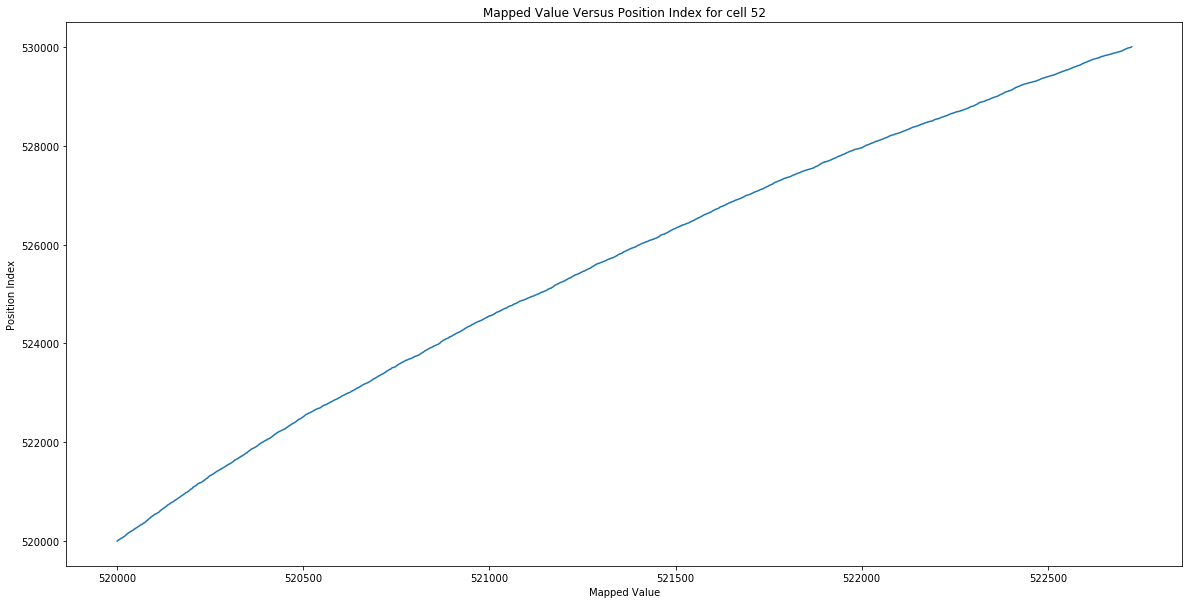

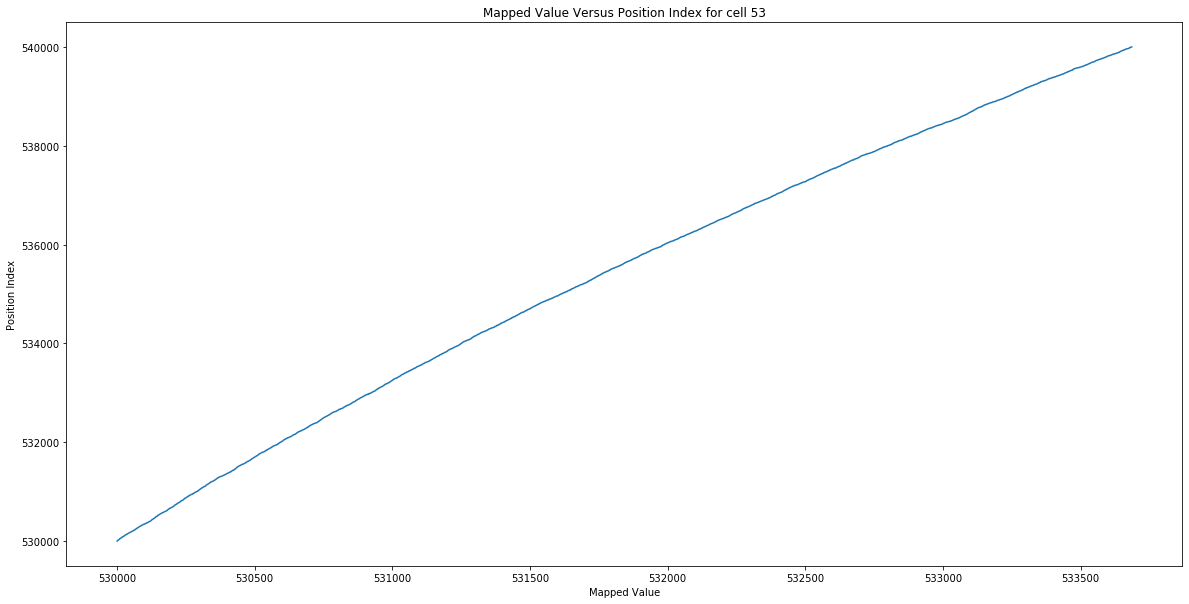

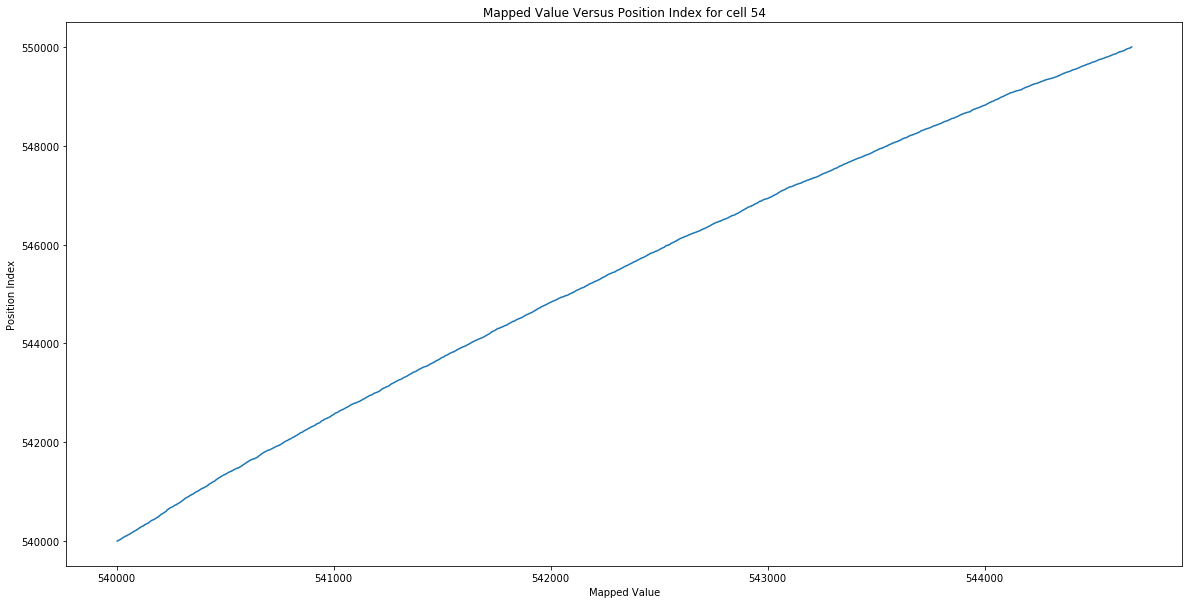

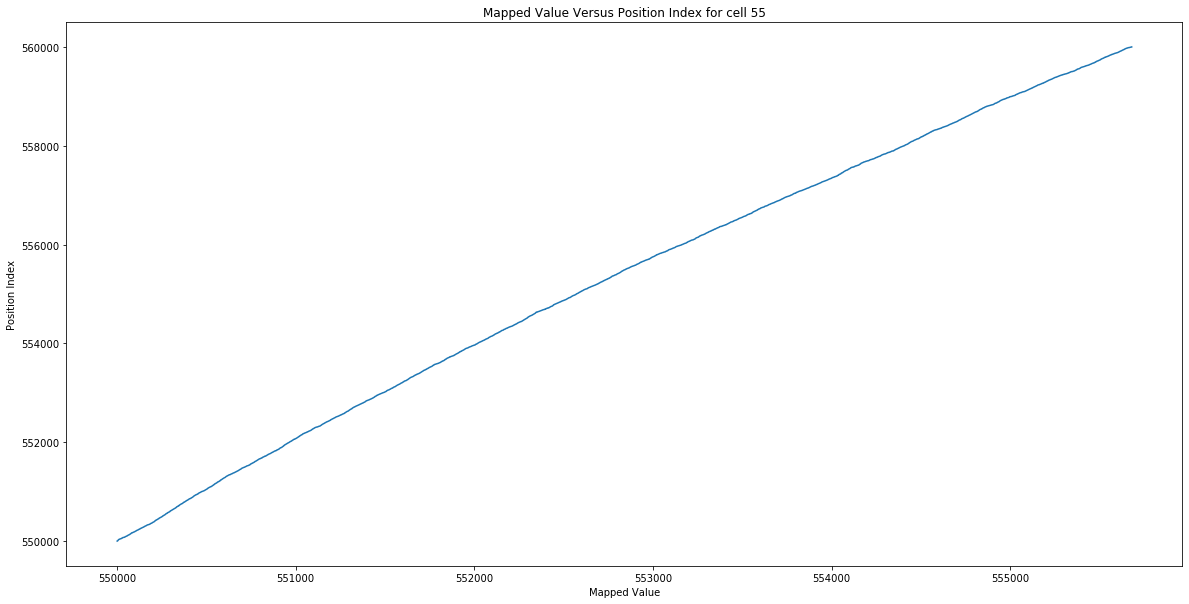

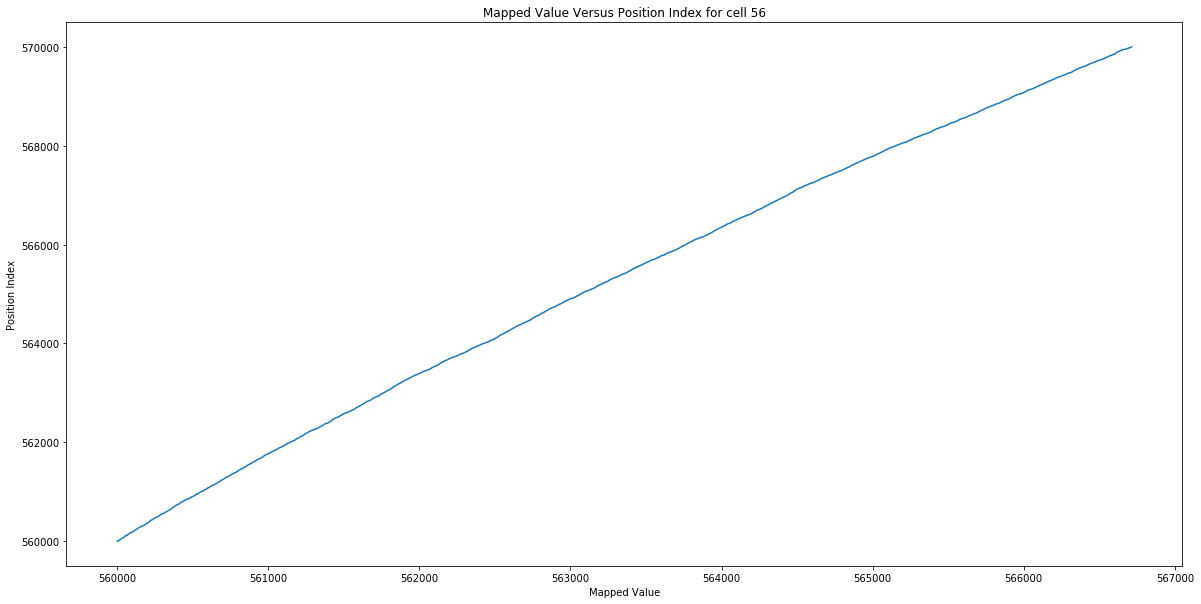

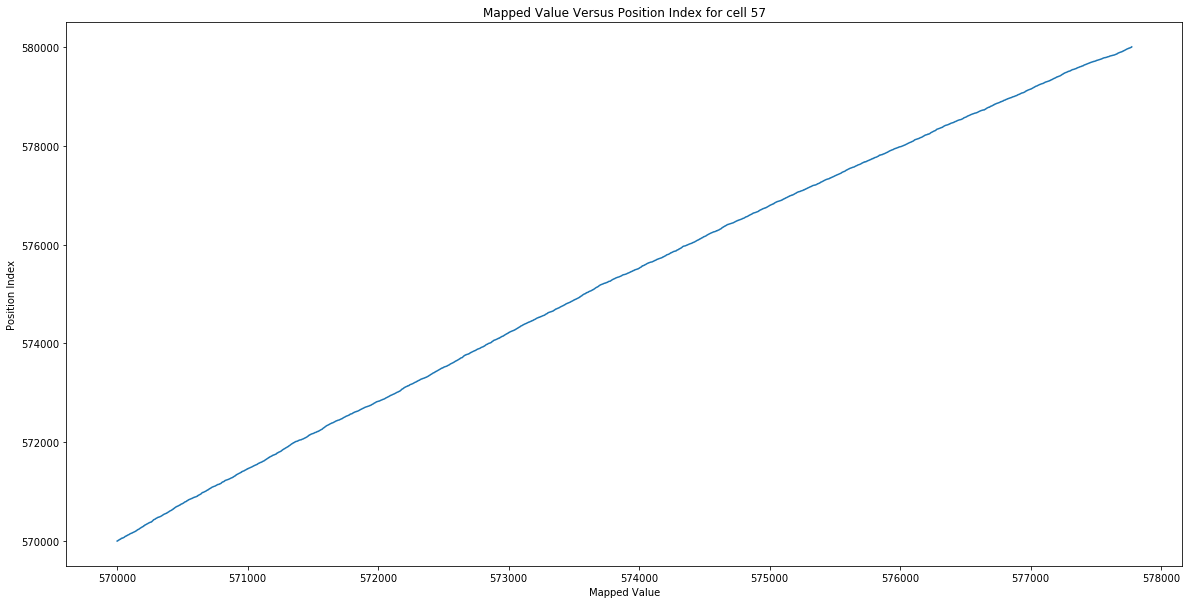

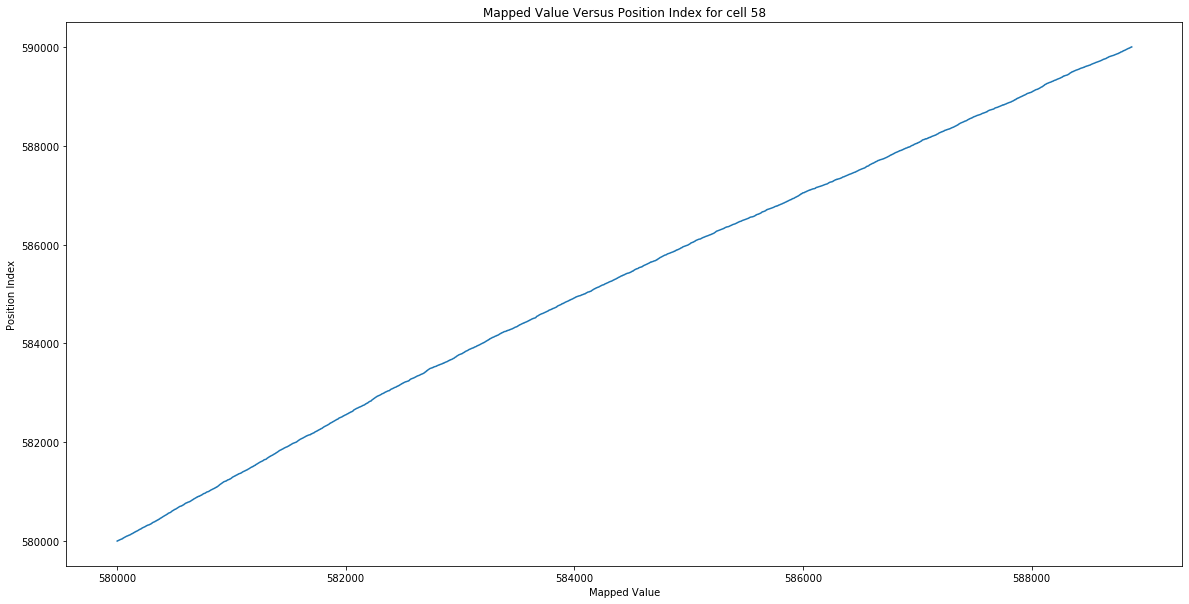

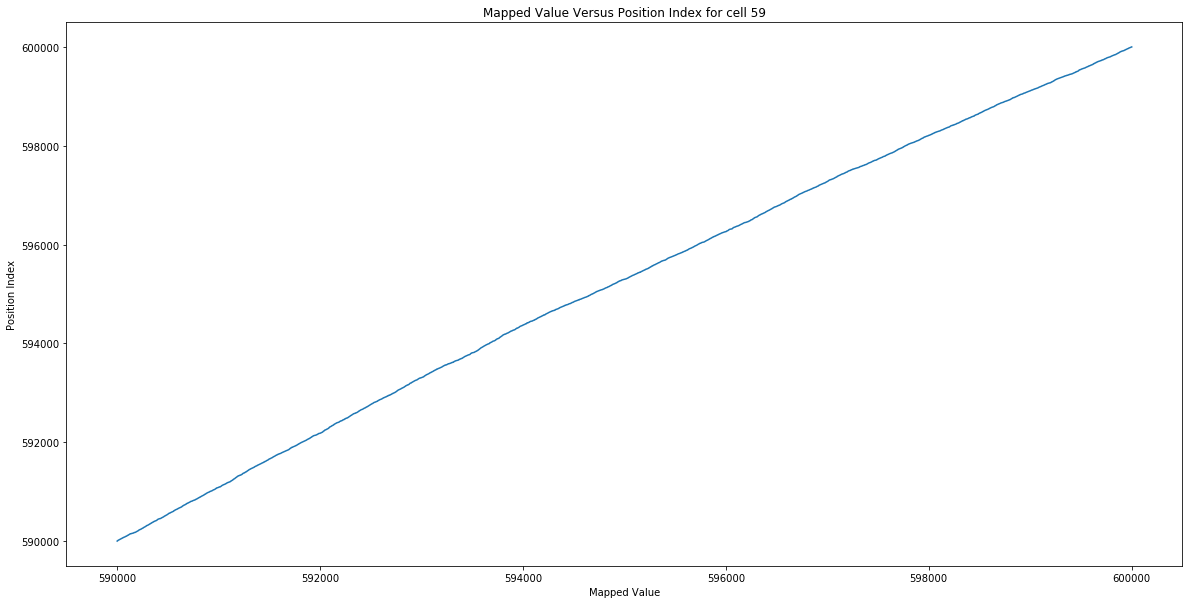

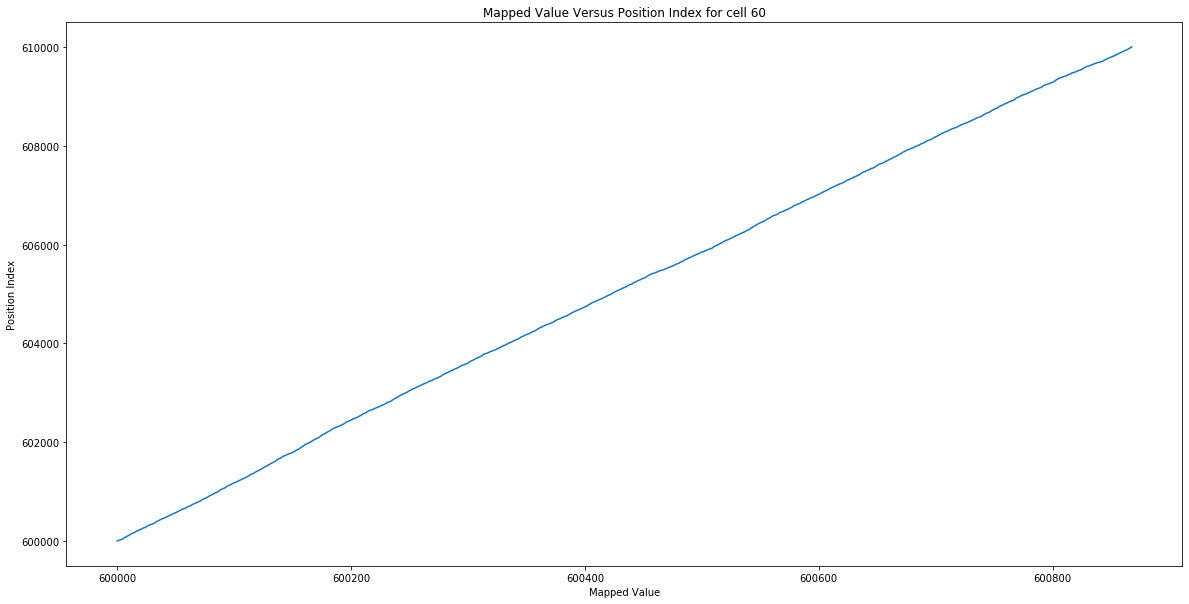

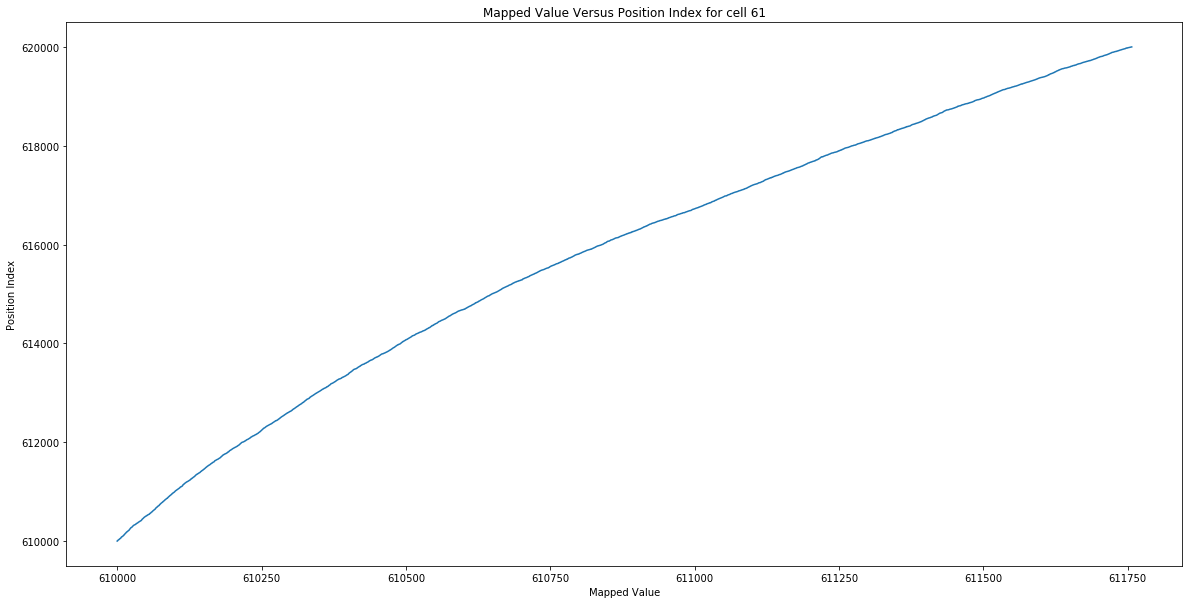

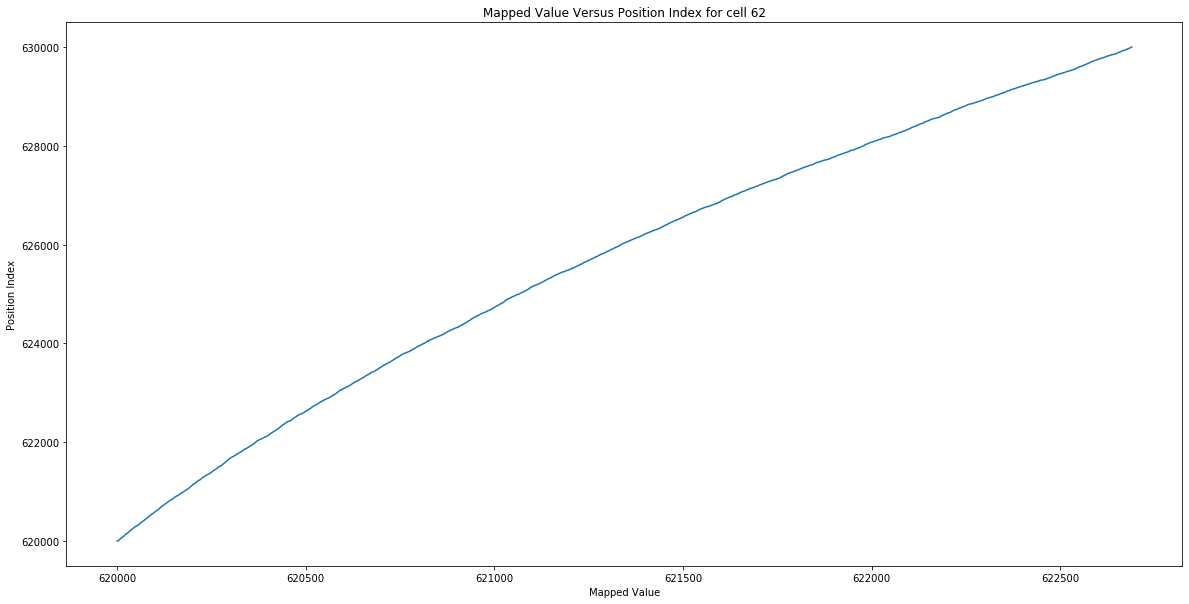

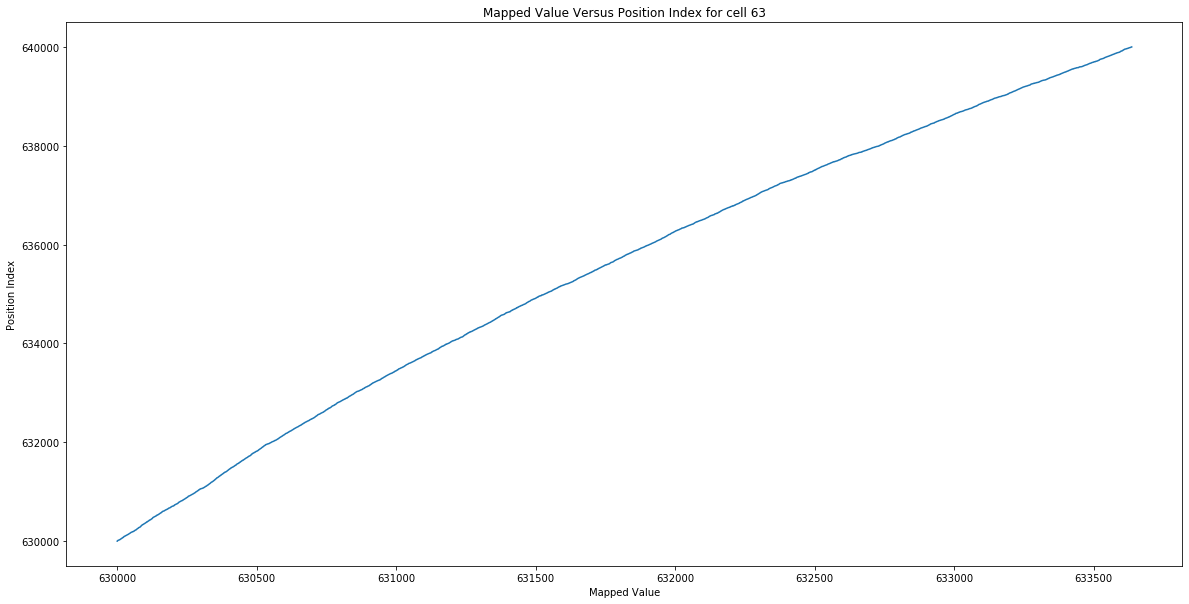

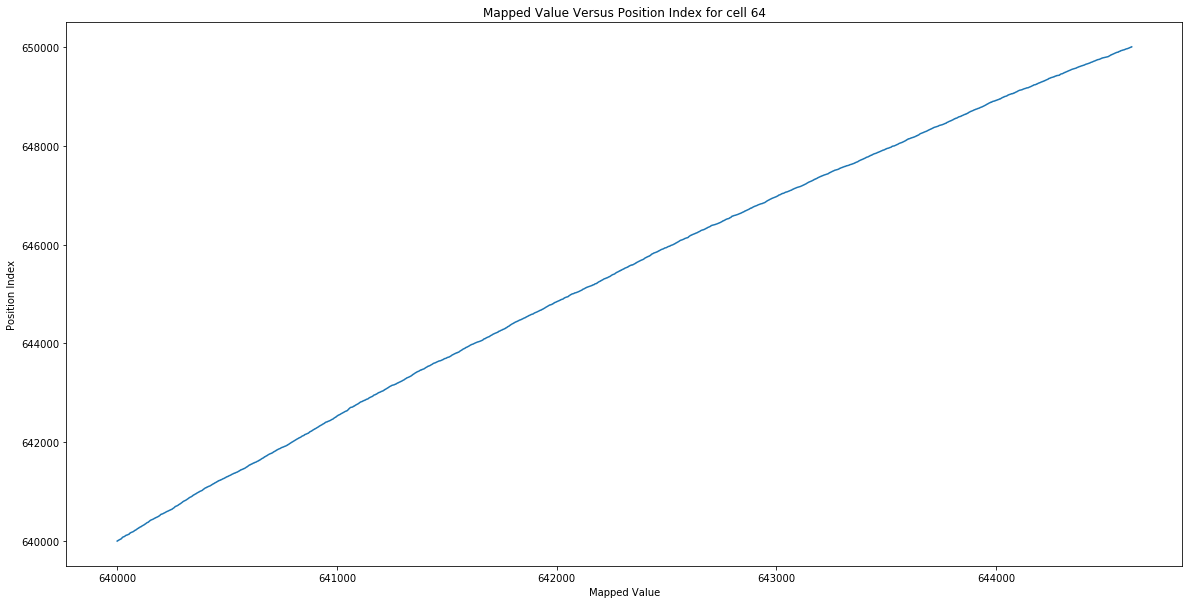

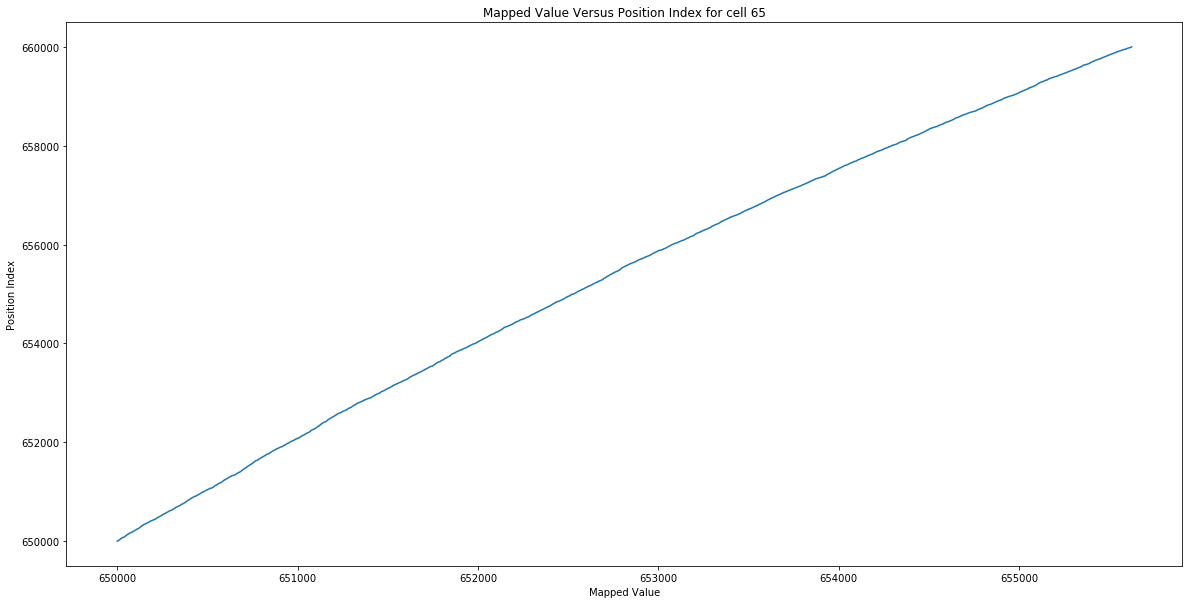

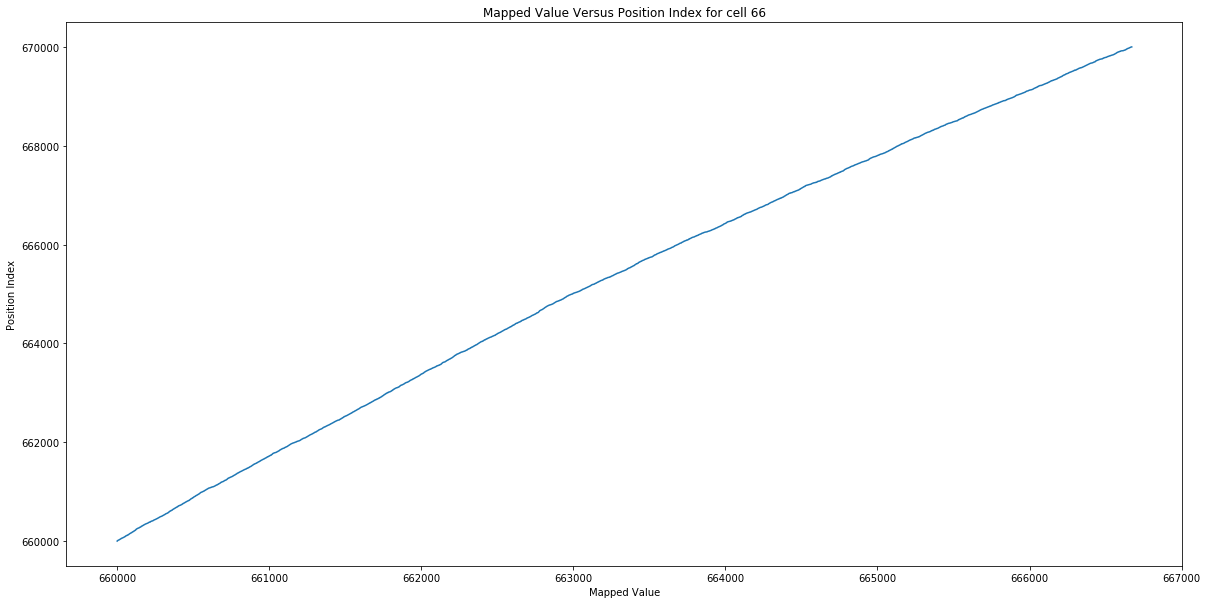

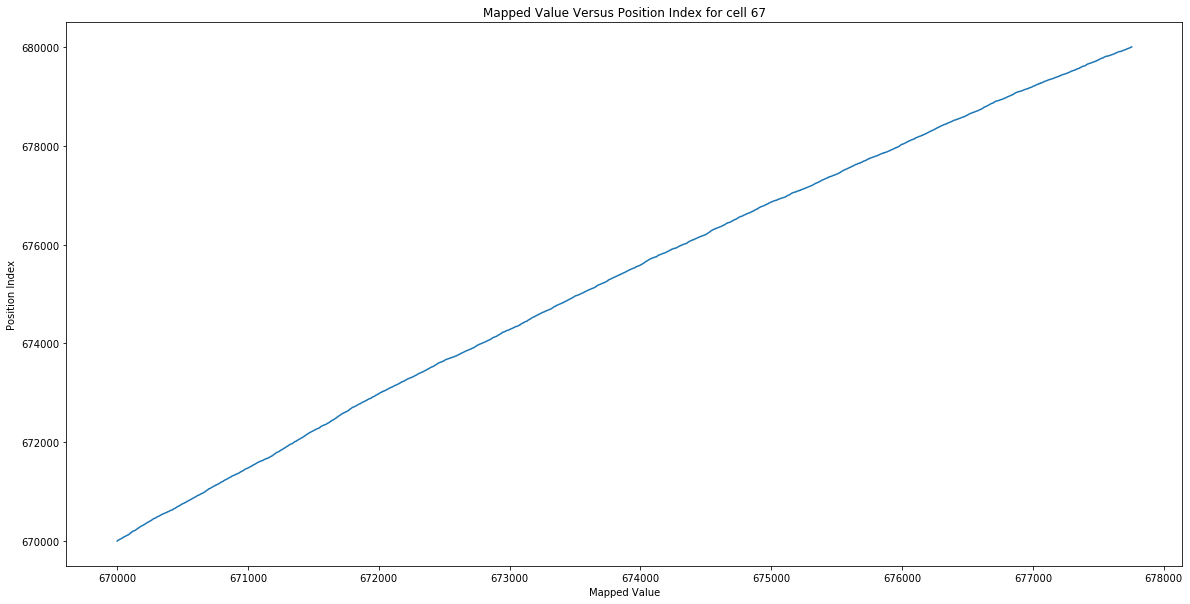

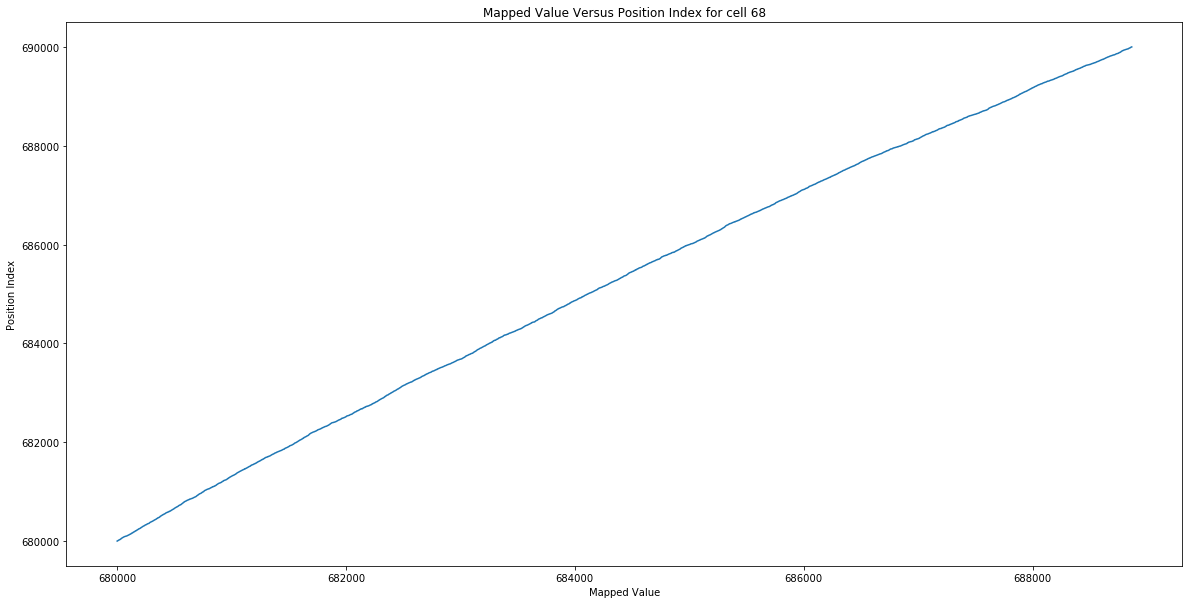

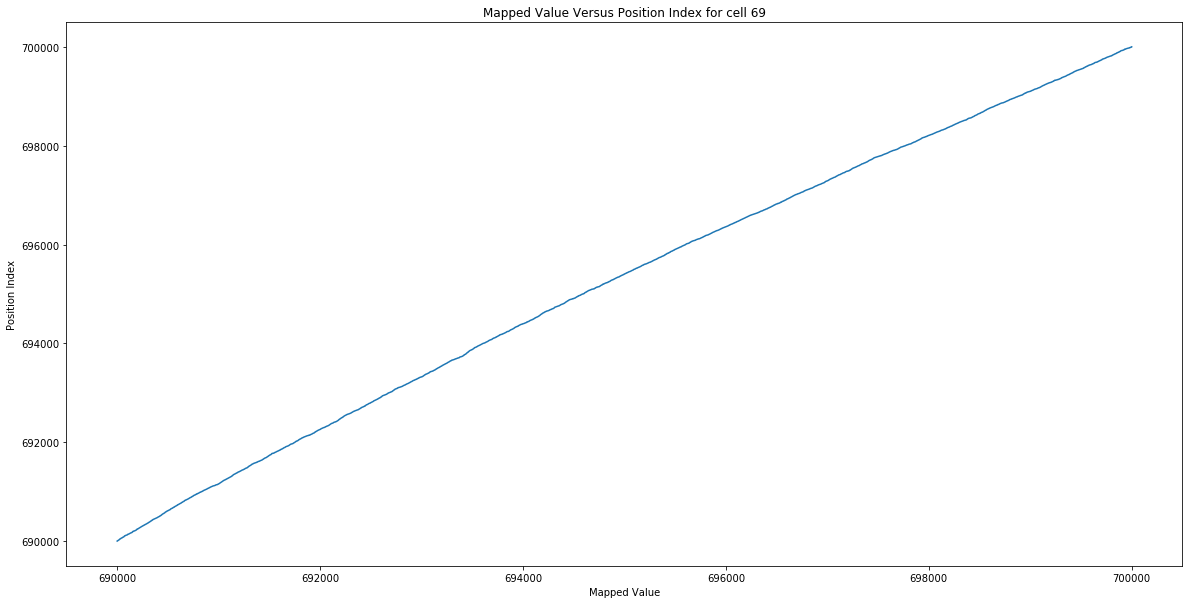

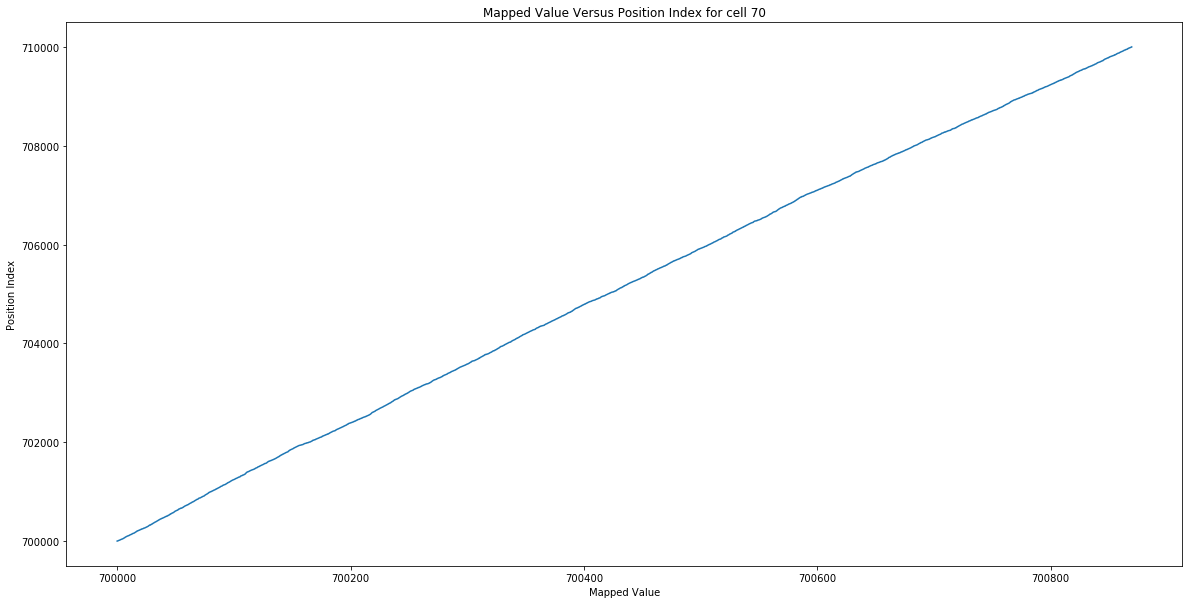

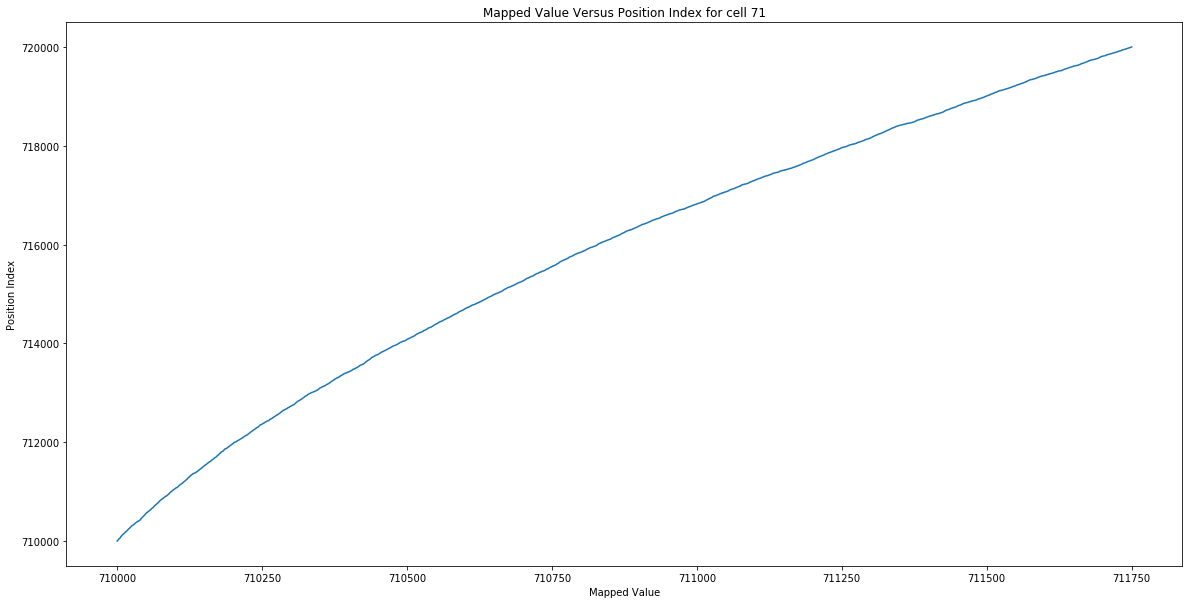

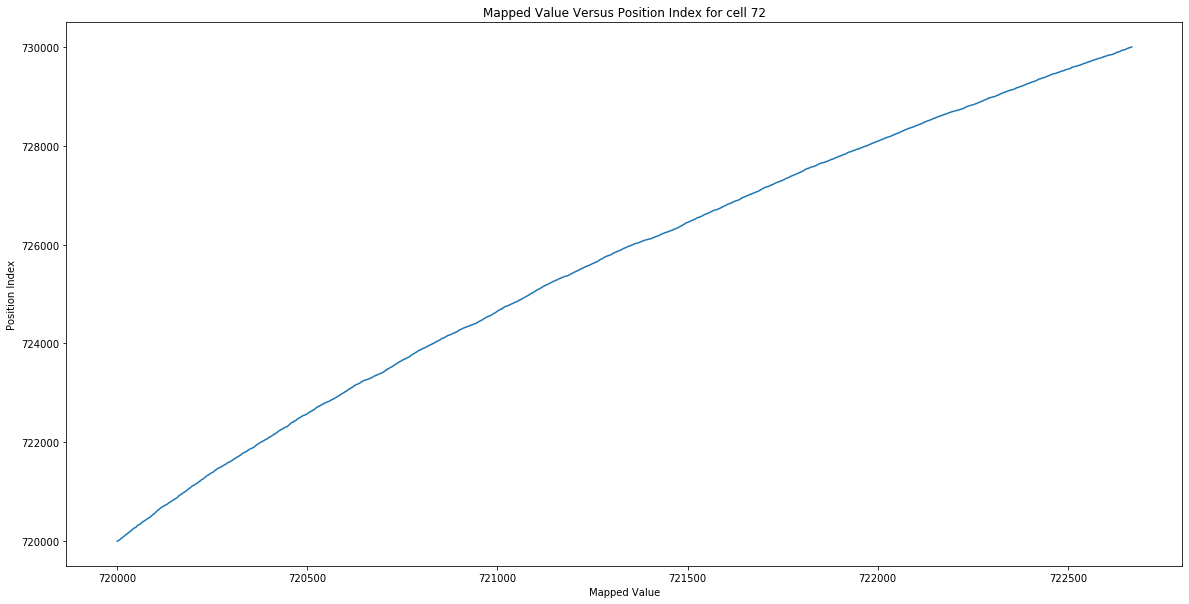

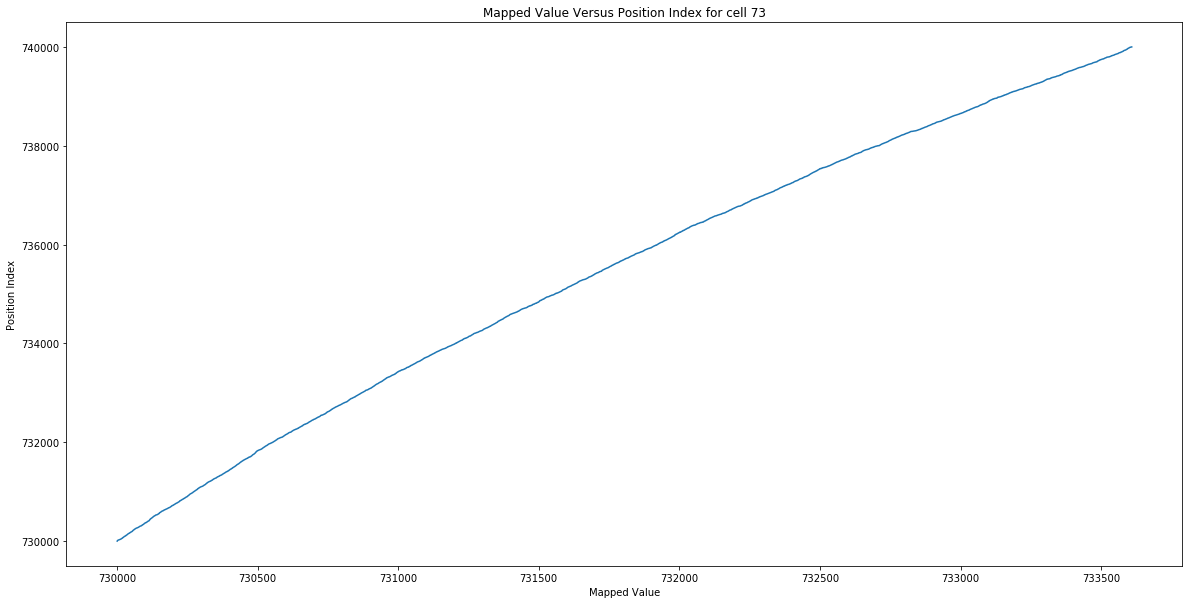

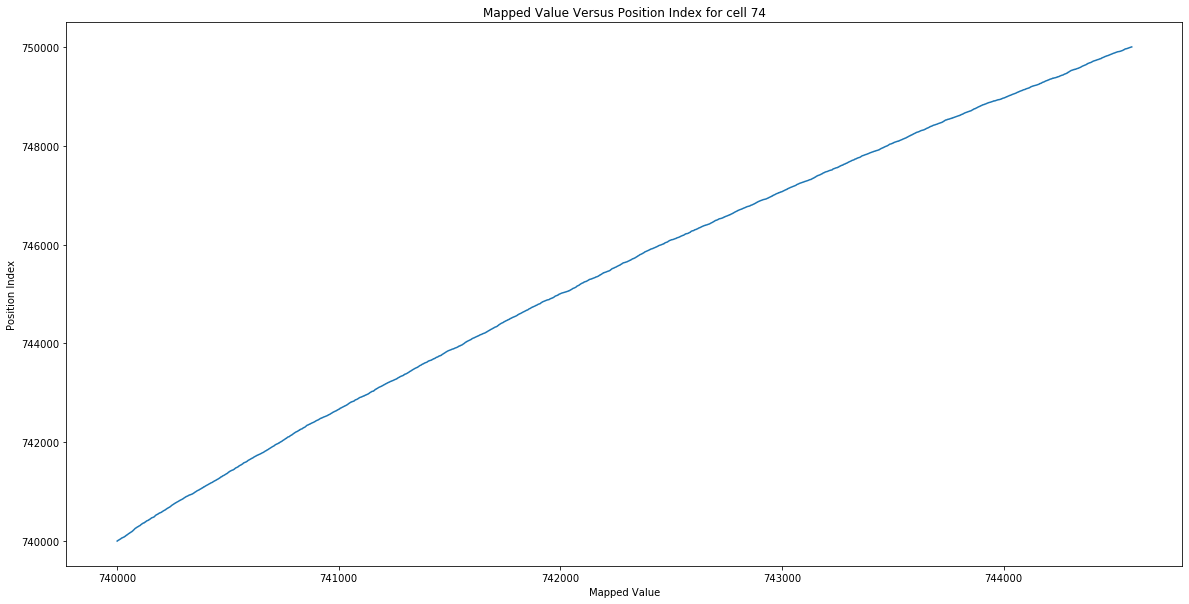

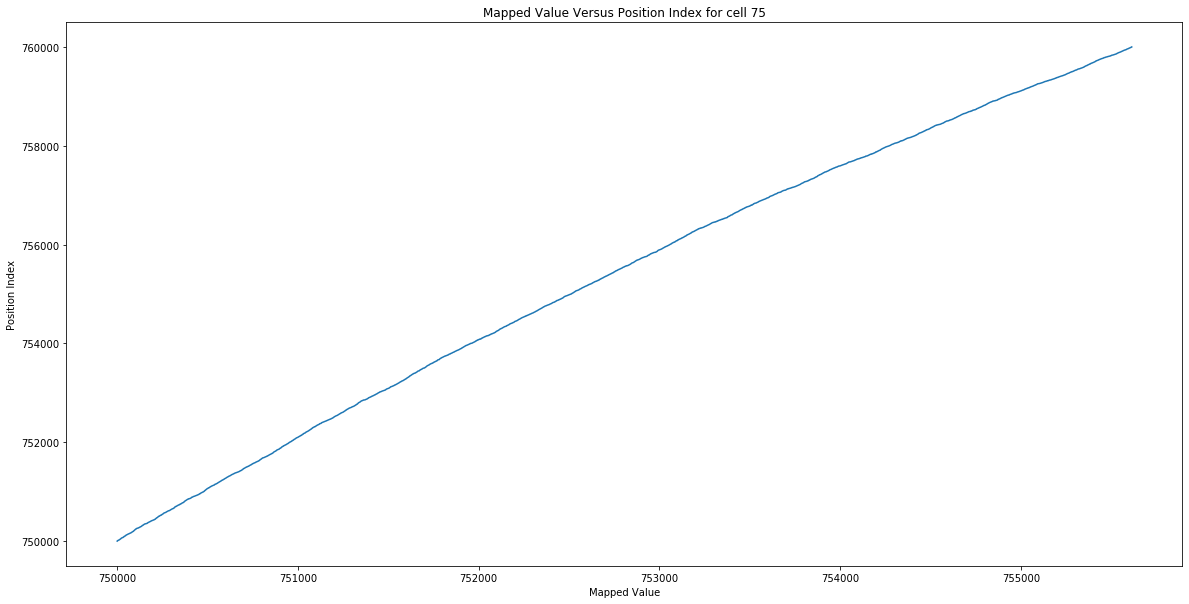

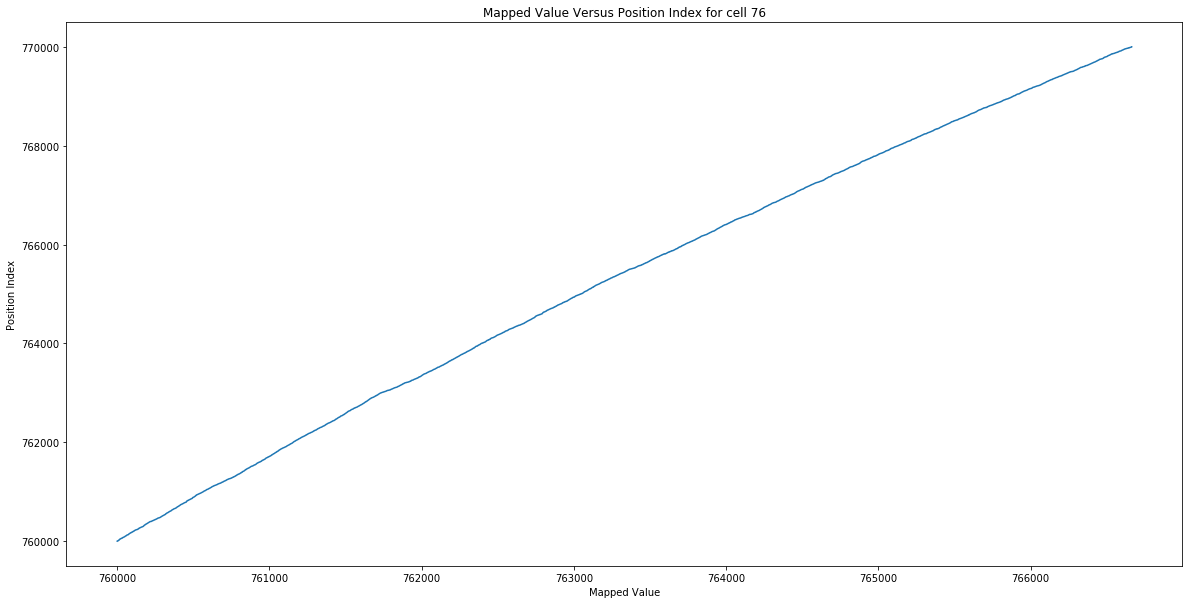

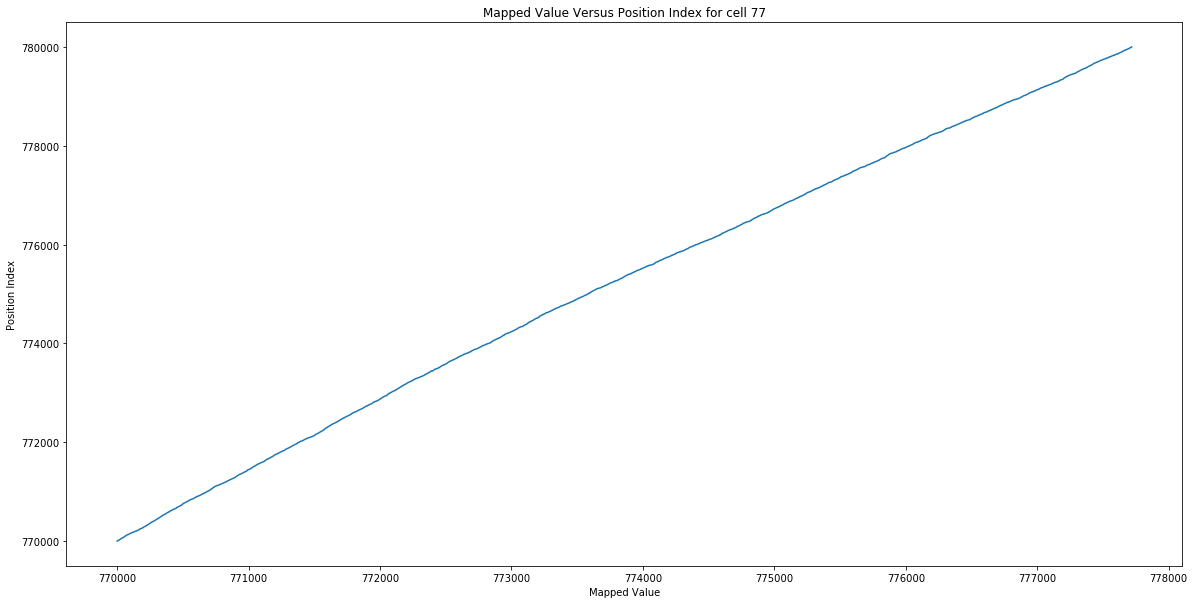

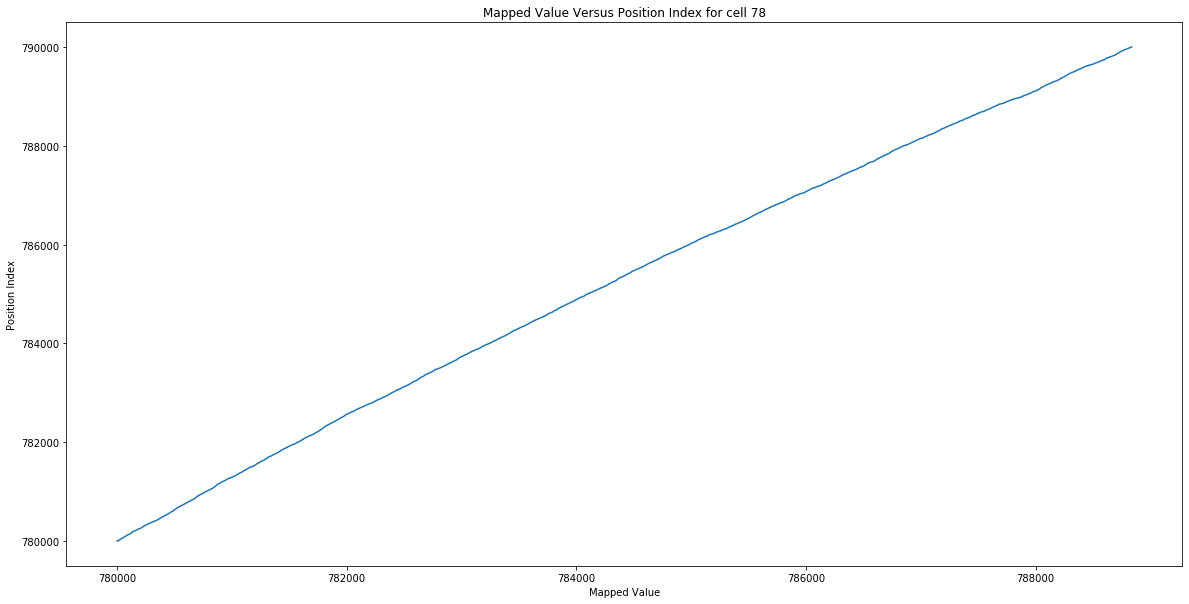

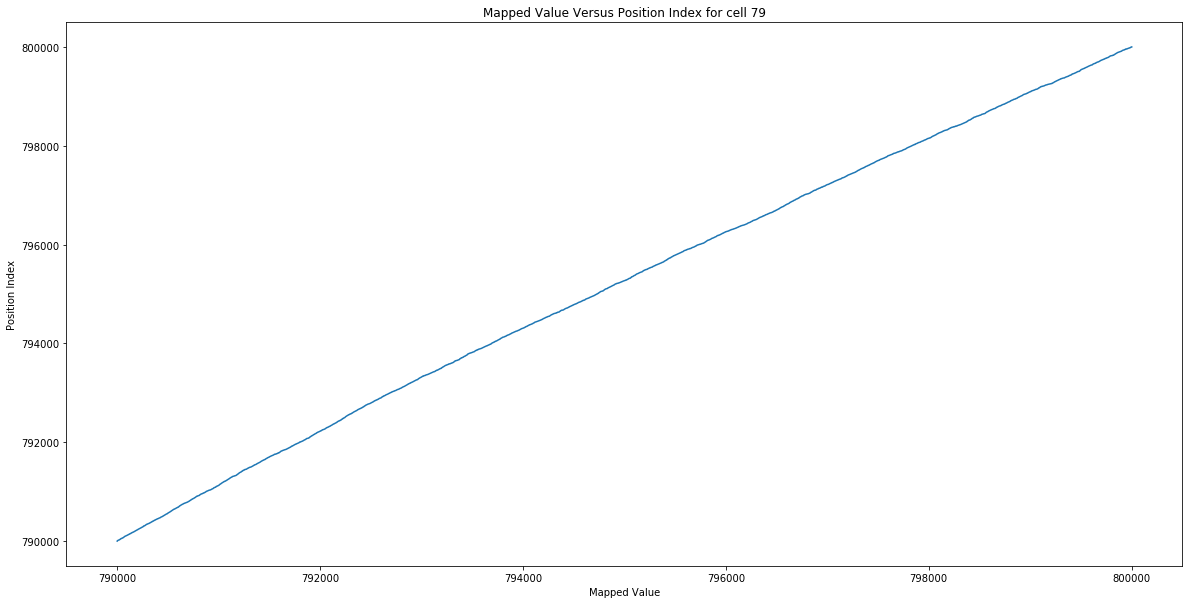

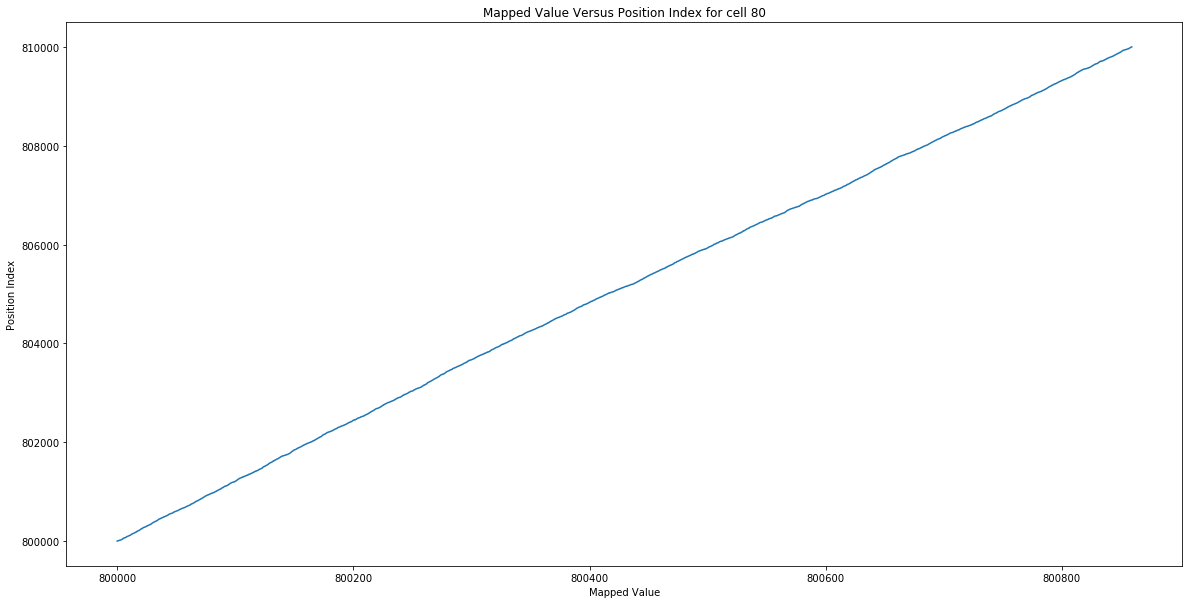

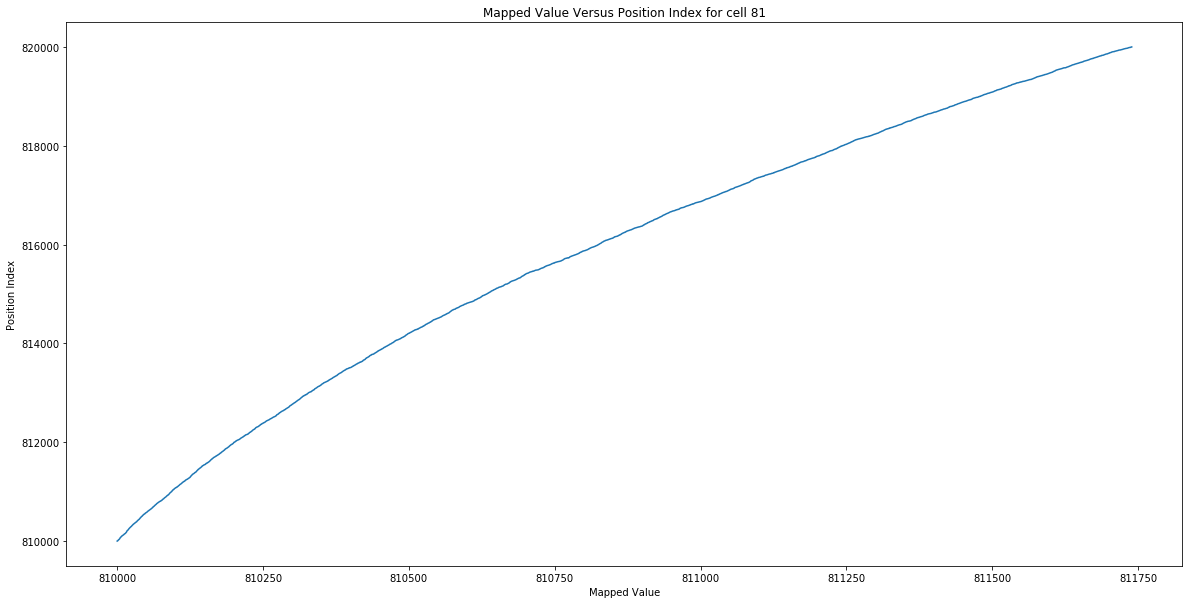

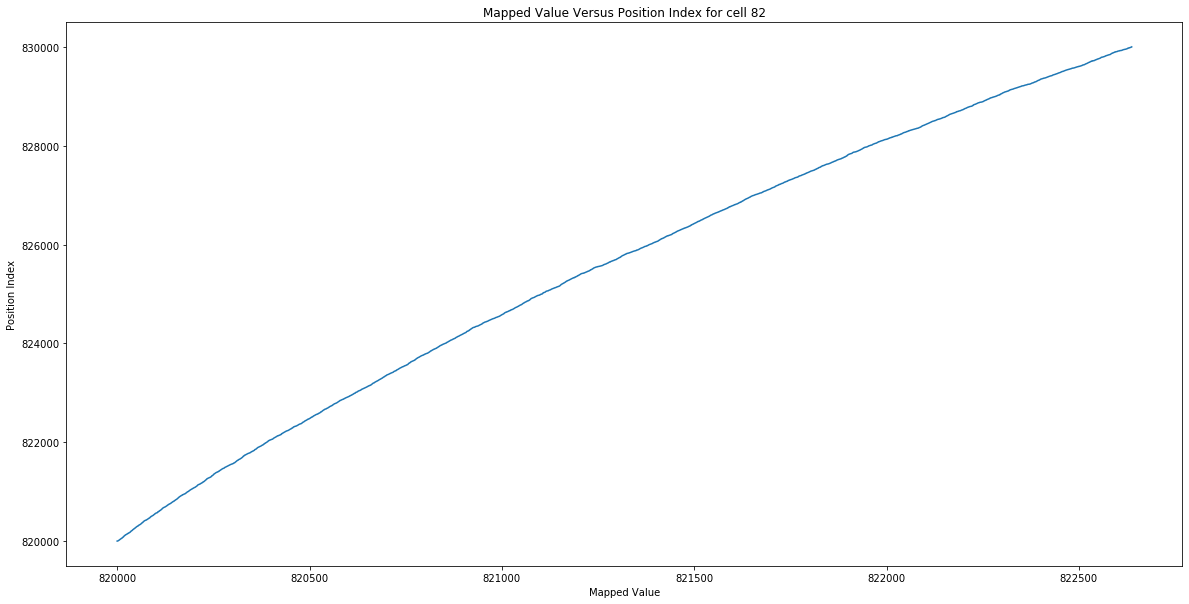

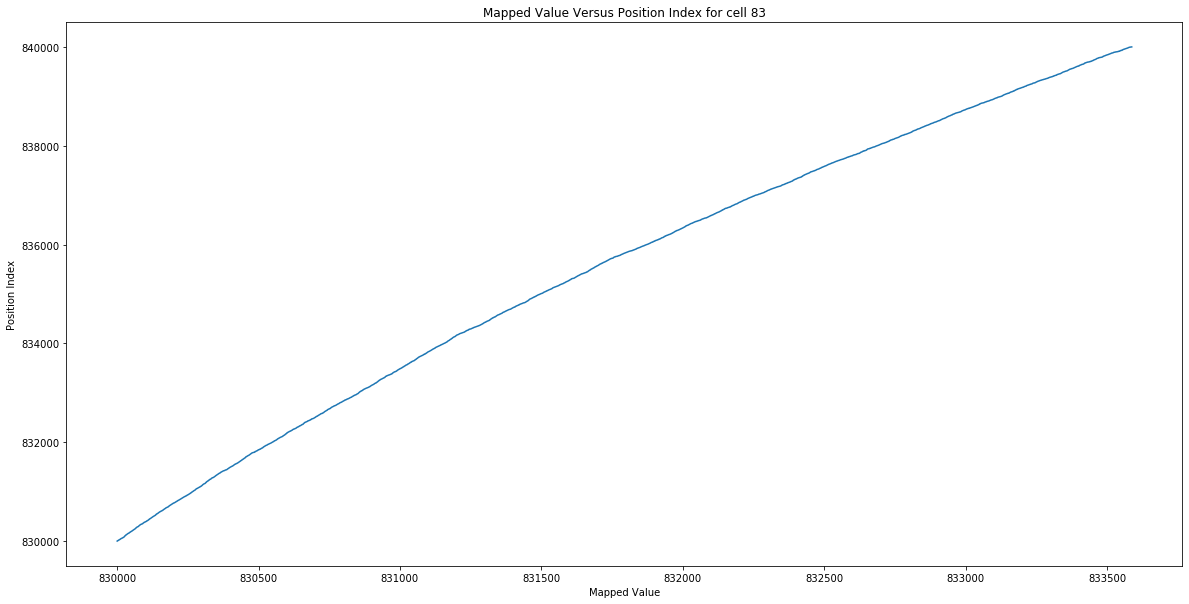

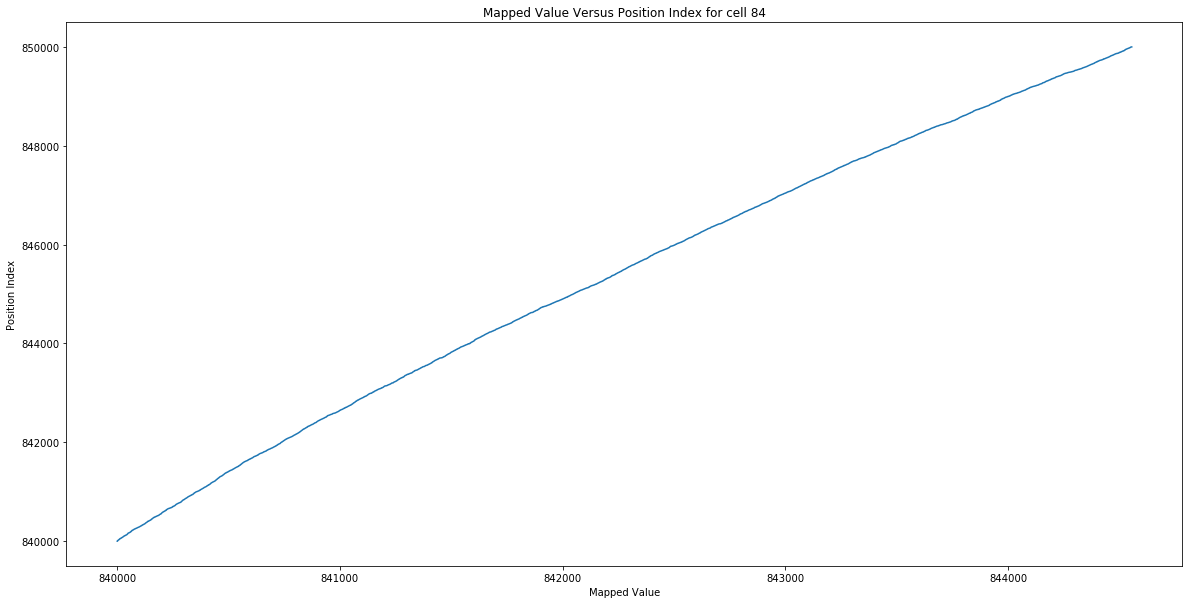

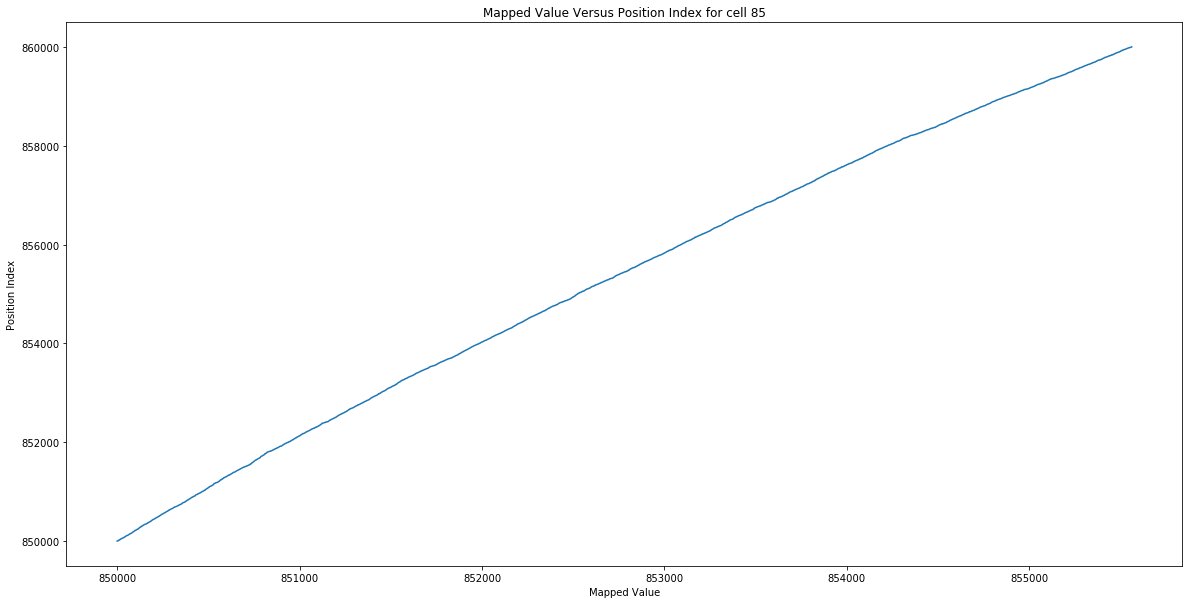

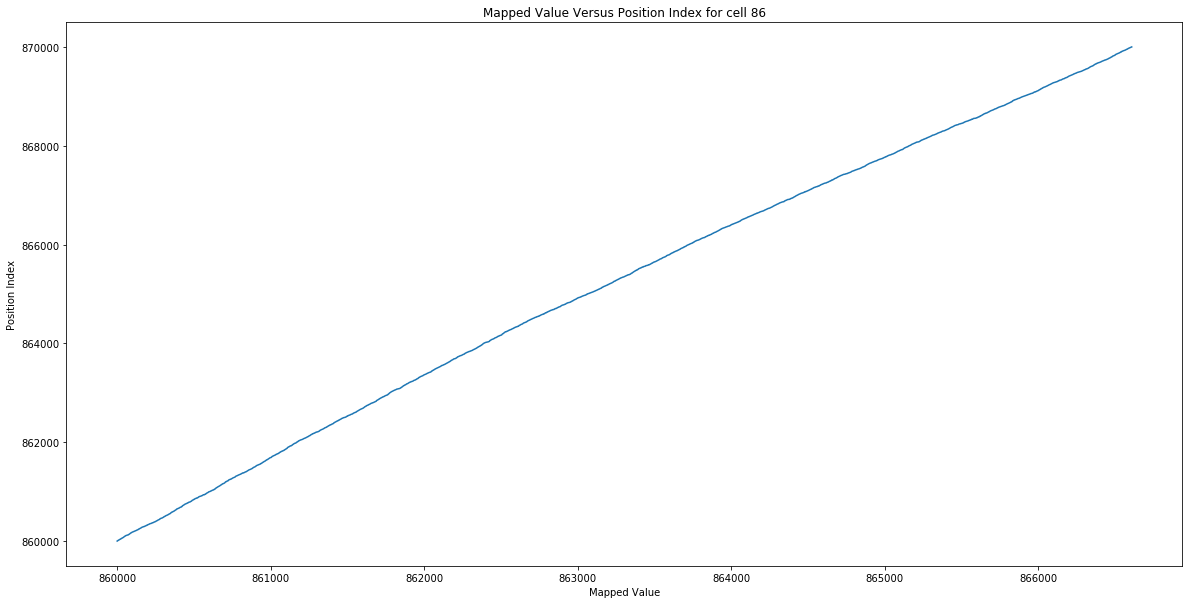

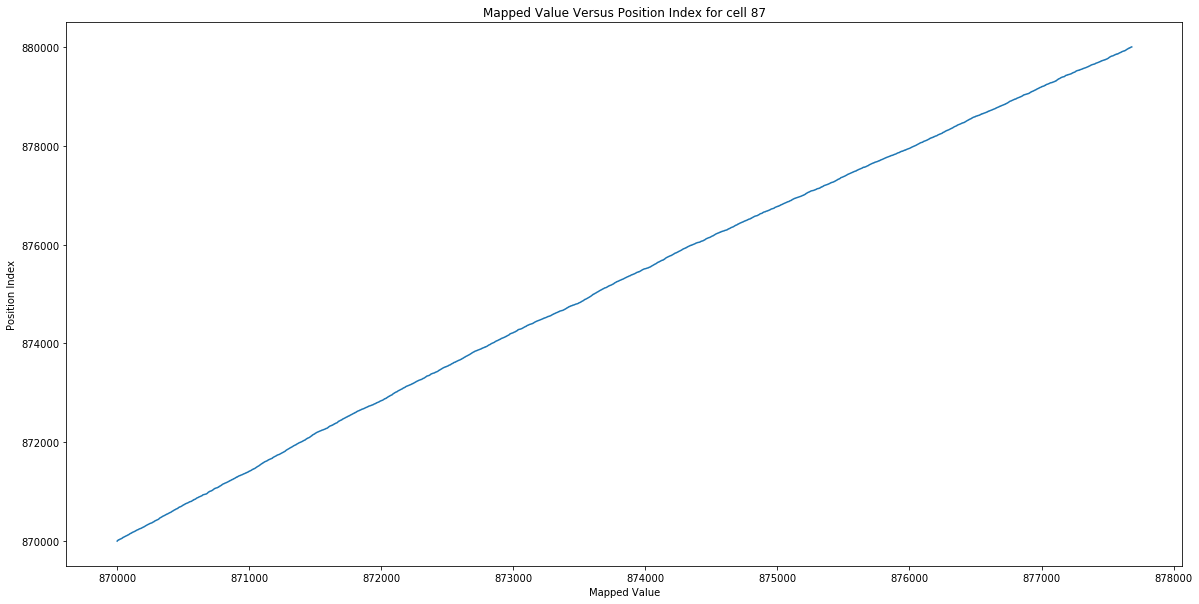

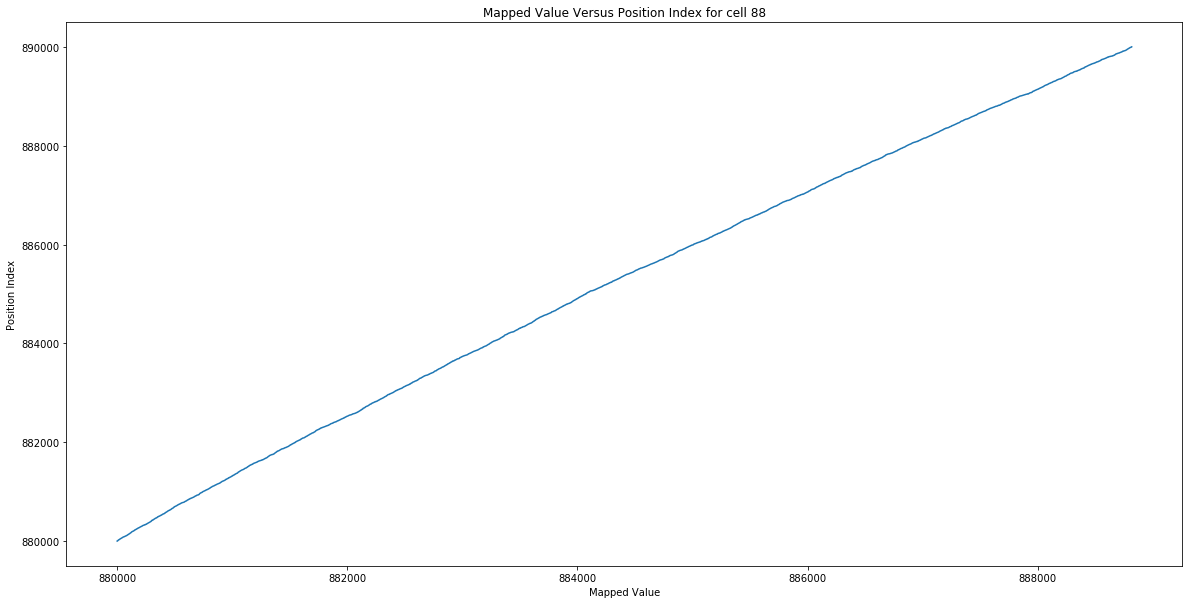

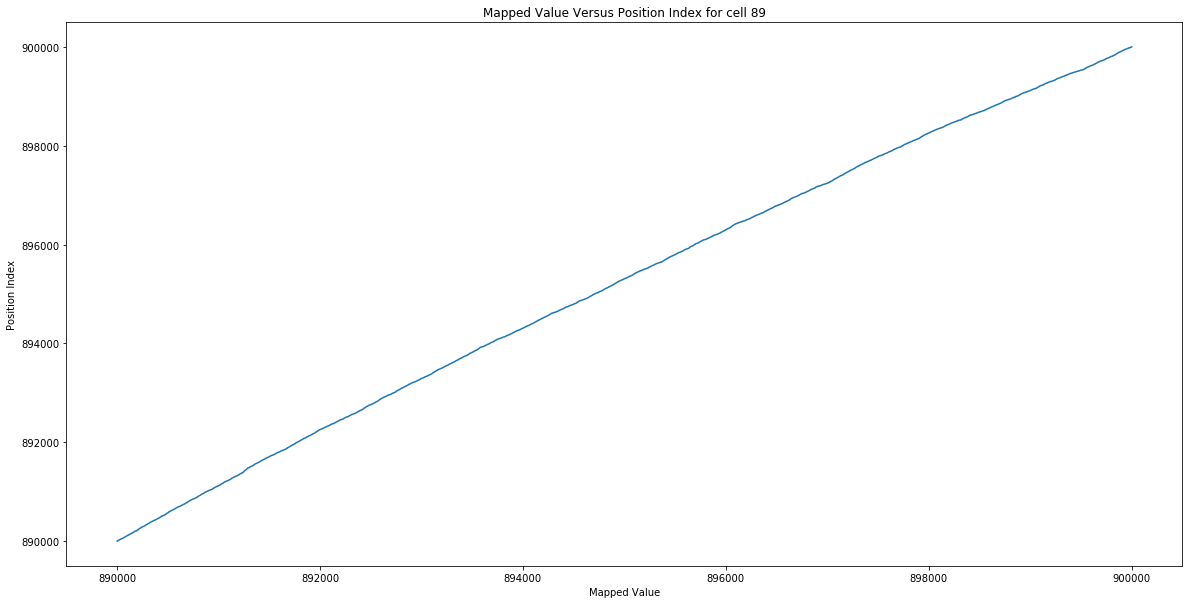

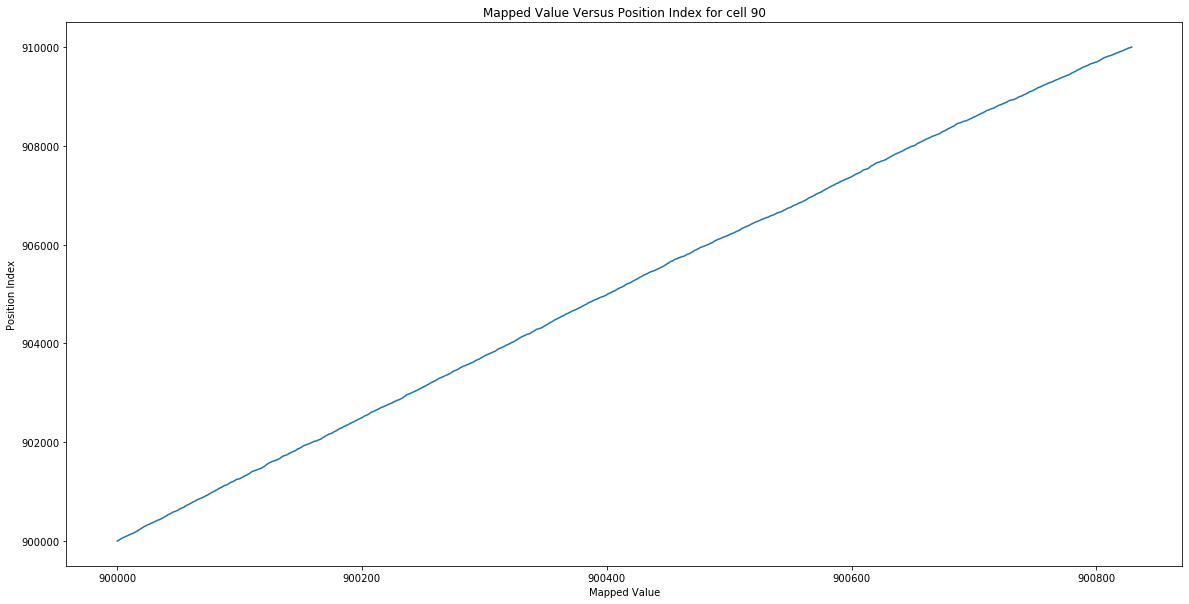

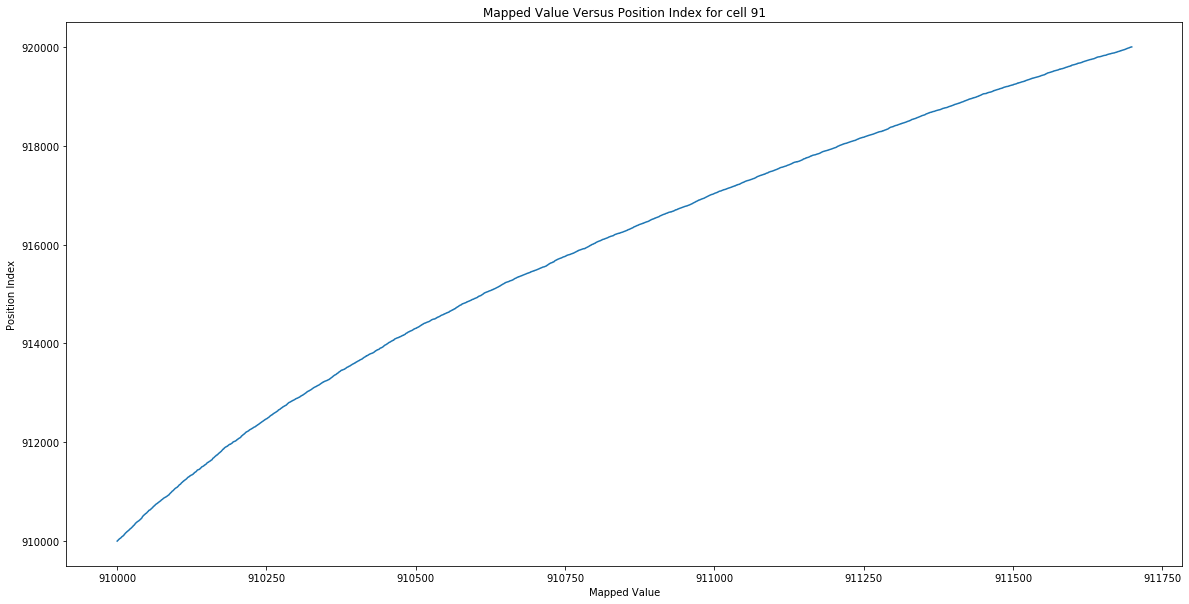

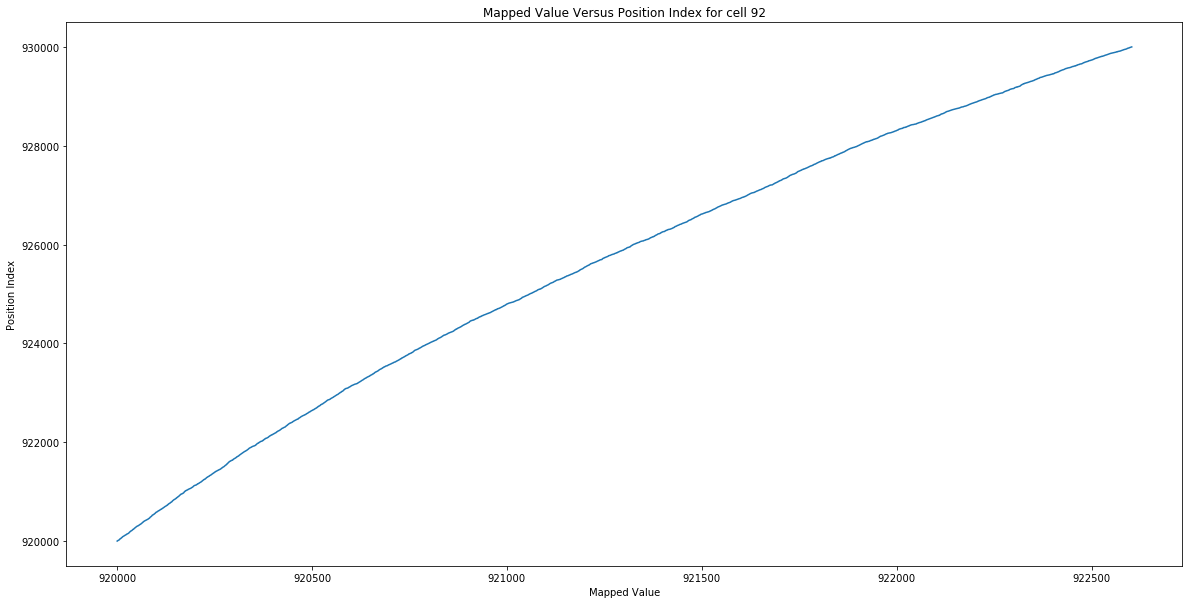

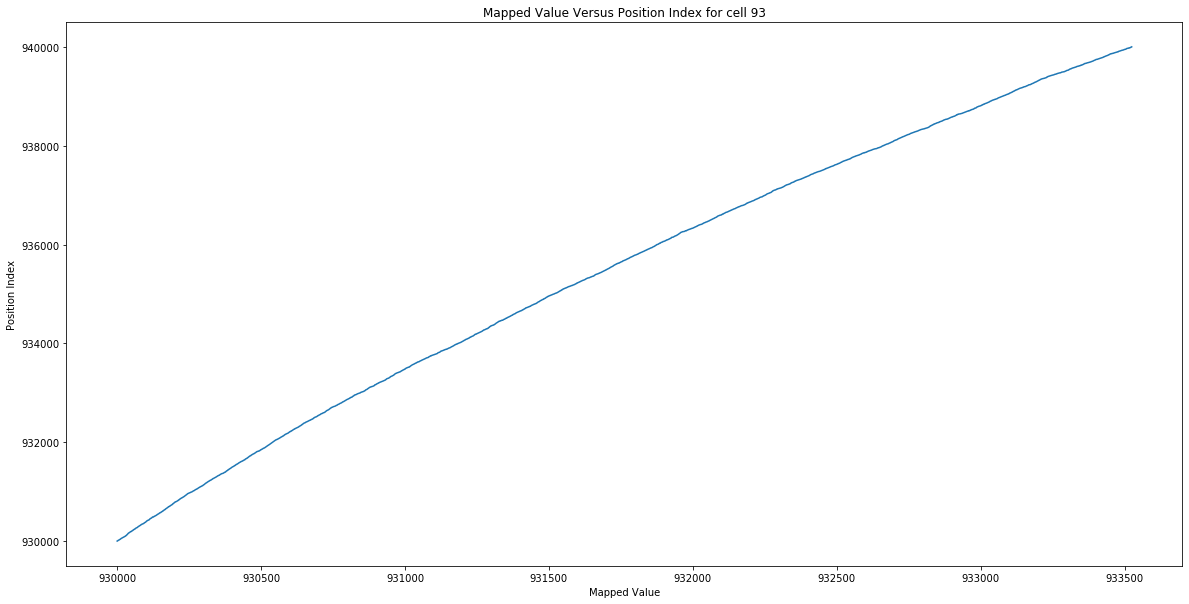

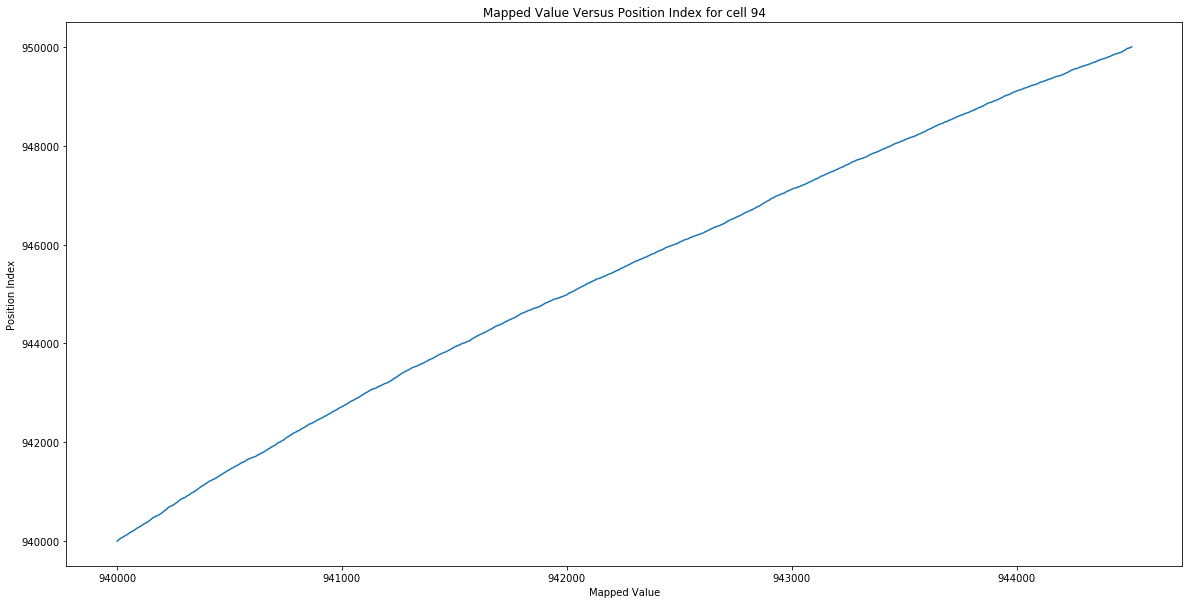

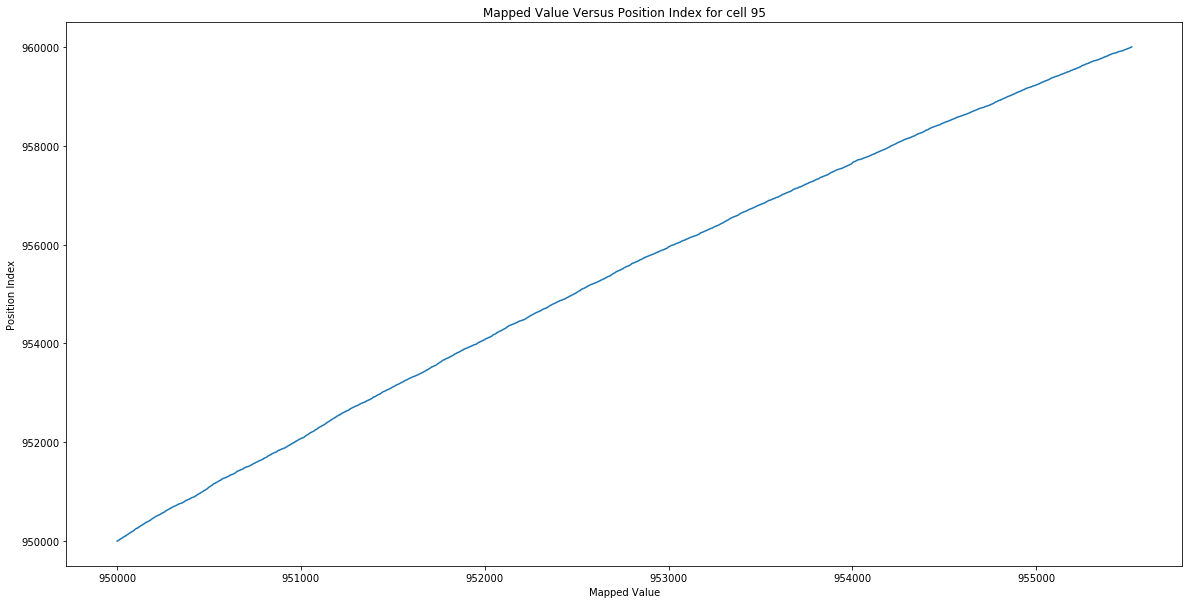

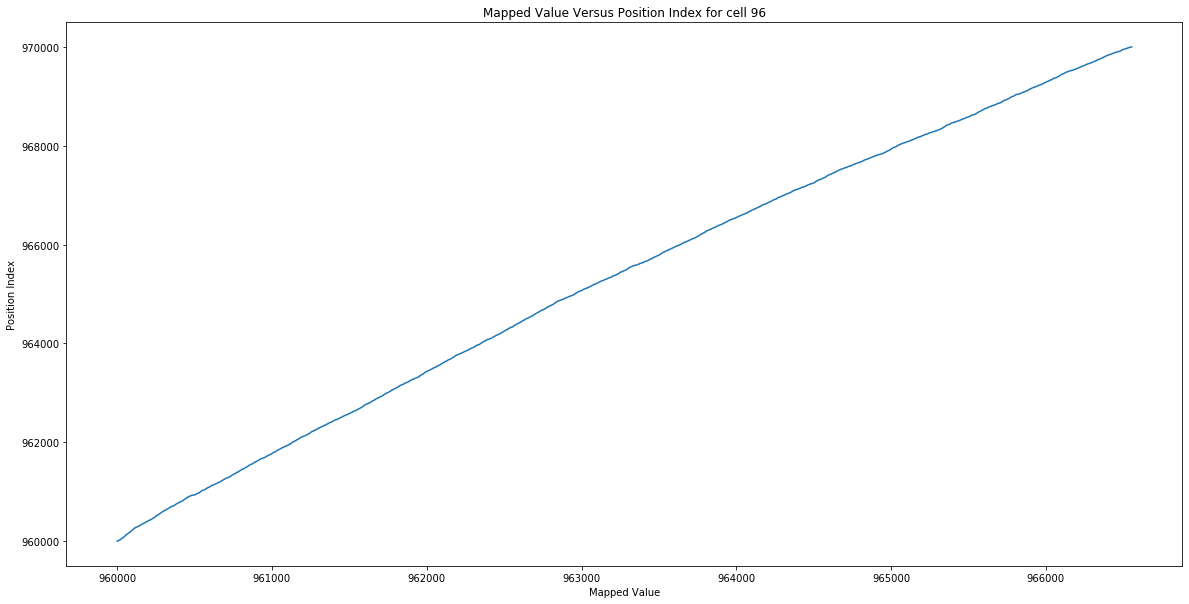

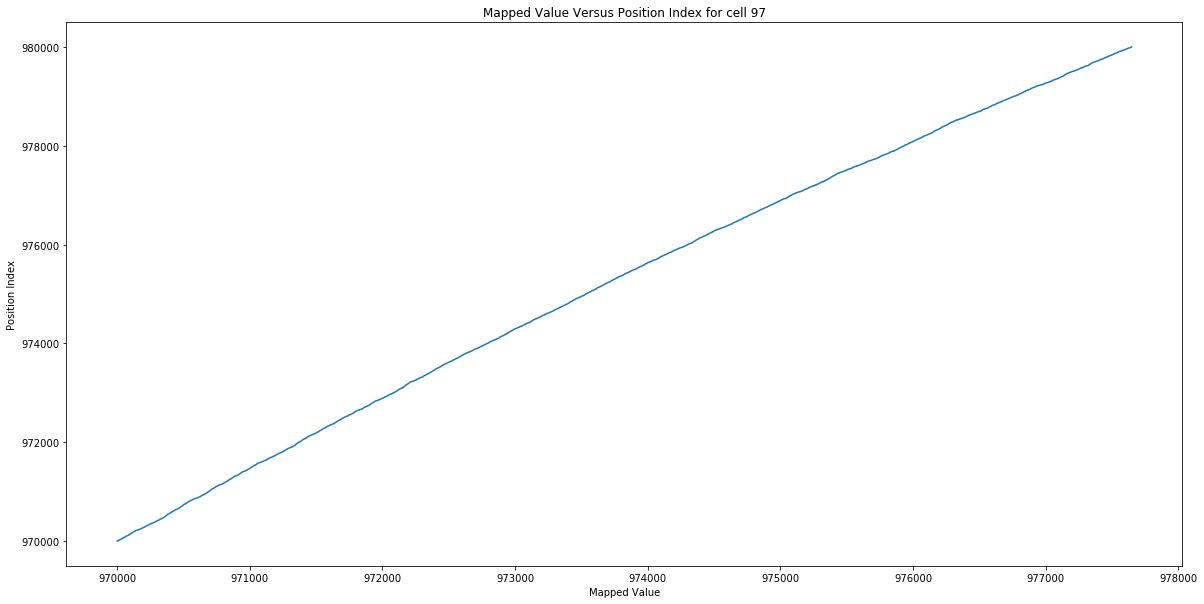

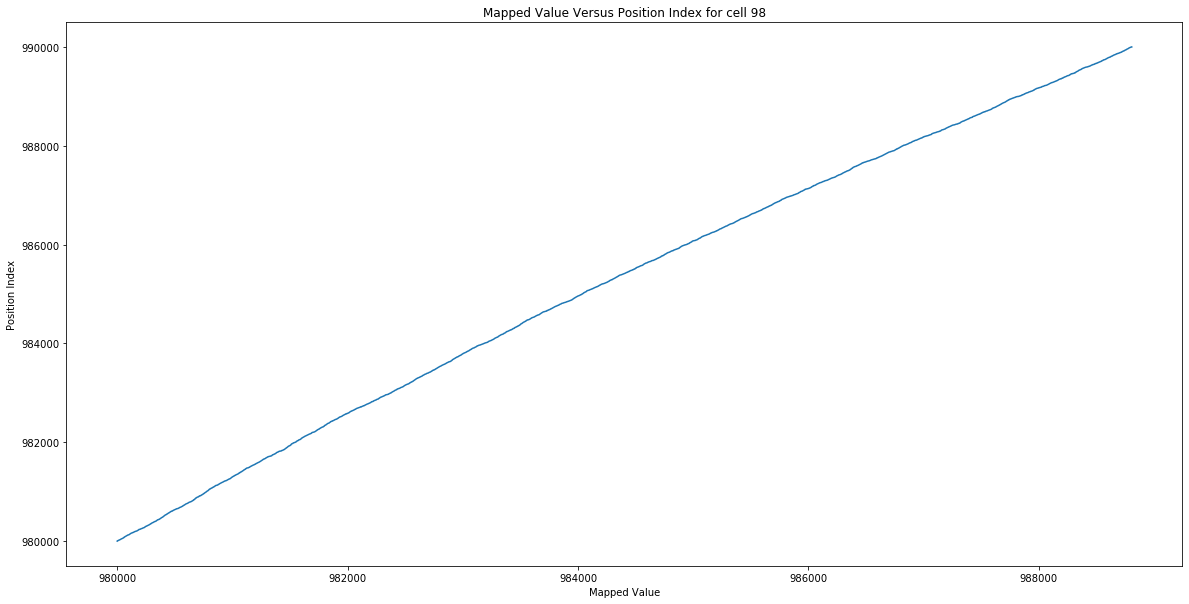

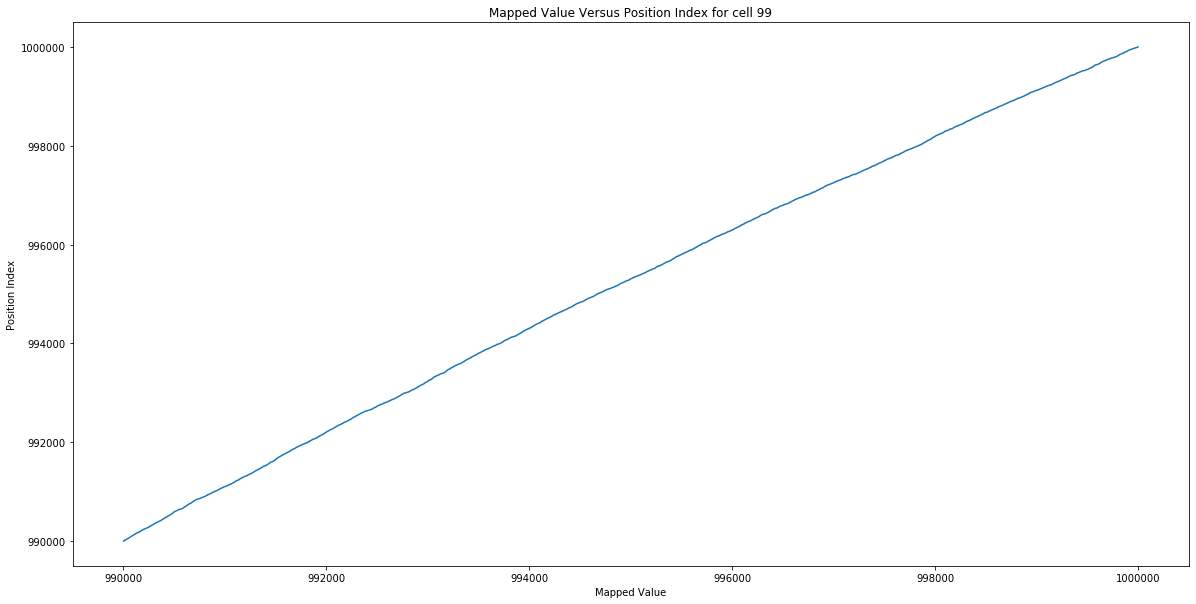

In [58]:
for i in range(CellSize*CellSize):

    plt.figure(figsize=(20,10))
    plt.plot(in_data_arr[i*KeysPerCell:i*KeysPerCell+KeysPerCell,3], in_data_arr[i*KeysPerCell:i*KeysPerCell+KeysPerCell,2])
    plt.xlabel('Mapped Value')
    plt.ylabel('Position Index')
    plt.title("Mapped Value Versus Position Index for cell %d"%(i))
    plt.show()